In [1]:
## Catálogo das Abordagens
#  A1: Cadastro
#  A2: Medidas
#      A2.1: Medidas Importantes
#      A2.2: Select KBeast
#  A3: Estatística
#  A4: Doenças
#      A4.1: Select KBest
#  A5: Doenças sem Hipotensão e Normotenso
#  A6: Escolho Doença
#  A7: Categorias
#  A8: Extratificação Sexo Masculino
#  A9: Extratificação Sexo Feminino
#  A10: Sistólicas
#  A11: Diastólicas
#  A12: Medidas Mais Importantes

In [2]:
#contar os itens de uma lista
from collections import Counter
from IPython.display import Image

#visualizar graficos
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np
#bibliotecas pandas de leitura de arquivos
import pandas as pd
from pathlib import Path
#caracter 
import re

#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
#biblioteca do kmeans
from sklearn.cluster import KMeans
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score

from sklearn import svm
# AIX - Explanability
import lime
from lime import lime_tabular

from sklearn.ensemble import RandomForestClassifier

#from sklearn_extra.cluster import KMedoids

In [3]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIR_DATASET = DIR_PREFIXO / "PA_clean" / "dataset"
DIR_KMEANS = DIR_PREFIXO / "PA_clean" / "KMeansRandom"


In [4]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset_apos_tratamento = pd.read_csv(DIR_DATASET / "dados_tratados" / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [5]:
dataset_apos_tratamento.loc[:,'Hipotensao':].head()

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0           1                  0                   0        0            0   
1           1                  0                   0        0            0   
2           1                  0                   0        0            1   
3           1                  0                   0        1            0   
4           1                  0                   0        1            0   

   Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  ...  \
0                0                1              0       0          0  ...   
1                0                1              0       0          0  ...   
2                0                0              0       0          1  ...   
3                0                0              0       0          1  ...   
4                0                0              0       0          0  ...   

   Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                       61.0                9545.5                 4902.0   
1                       62.0                8586.5                 5034.5   
2                       80.0               10674.0                 6154.0   
3                       80.5               10679.5                 6420.5   
4                       77.0                9141.5                 6118.0   

   AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0          3748.0             841.5                16.58   
1          2915.0             606.0                 7.38   
2          3721.0             751.5                12.48   
3          3642.0             602.5                16.14   
4          2405.0             566.0                11.88   

   DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                 10.99               15                39   
1                  6.89                9                23   
2                 13.02               19                20   
3                 10.58               23                11   
4                 12.65               14                15   

   Diferença % Dipping  
0                0.966  
1                0.969  
2                1.056  
3                1.107  
4                1.137  

[5 rows x 37 columns]

In [6]:
#!pip install scikit-learn-extra

In [7]:
############################### FUNÇÕES ##########################################

#Funções para inicializar o valor de K para entregar ao método k-means.fit

# sum_of_squares_medidas = calculate_wcss(dados_medidas_sem_id)
# num_otimo_clusters_medidas = optimal_number_of_clusters(sum_of_squares_medidas)

def calculate_wcss(data):
    """
    Inicialização do valor de k:
    A partir de X que recebe o dataset recortado de cada abordagem. 
    Varia o valor inicial de k de 2 a 20 vezes e, em cada uma dessas iterações calcula 
    a soma dos quadrados das distâncias das amostras em relação ao centroide (intra-clusters).
    Guarda esses 20 valores de distância na lista wcss que será entregue à função 'optimal_number_of_clusters'
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    Returns
    -------
    wcss : lista contendo os valores calculados das distâncias da soma de quadrados intra-cluster
    """
    
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        #     iniciando com o mínimo de 2 clusters
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Objetivo: Identificar qual o valor de k que tenha a maior distância 
    entre os pontos calculadas pela somas dos quadrados iterando com a lista wcss 
    calculada com a função `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    # começa com x1 = 2 porque foi designado assim. y1 é o 1o. elemento da lista wcss
    # x2 = 20 porque foi designado assim, y2 é o último elemento da lista wcss
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [8]:
dataset_apos_tratamento['IMC']

0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19145    27.5
19146    26.9
19147    33.3
19148    25.0
19149    30.9
Name: IMC, Length: 19150, dtype: float64

##  Tratar campos para Categorias

In [9]:
# Cálculo do Indice de Massa Corporal:
#         IMC entre 18,0 e 24,9 Kg/m2: normal
#         IMC menor do que 18,0 Kg/m2: baixo peso
#         IMC entre 25,0 e 29,9 Kg/m2: sobrepeso 
#         IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I 
#         IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II 
#         IMC maior do que 40,0 Kg/m2: obesidade grau III  

def faixas_imc(imc):

    classes = ["Peso normal","Sobrepeso", "Obesidade"]
    intervalos = [(0, 25),(25, 30),(30, 1000)]
#    classes = ["Baixo Peso","Normal","Sobrepeso","Obesidade grau I","Obesidade grau II","Obesidade Grau III"]
#    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]

def faixas_imc_13(imc):
    classes = ["Peso normal", "Obesidade"]
    intervalos = [(0, 30),(30, 1000)]

    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
        

def faixas_imc_classe(imc):
    classes = [1, 2, 3]
    intervalos = [(0, 25),(25, 30),(30, 1000)]
#    classes = [1, 2, 3, 4, 5, 6]
#    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_imc_classe_13(imc):
    classes = [1, 2]
    intervalos = [(0, 30),(30, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_etarias(idade):
    classes = ["Adultos","Meia-idade","Idoso"]
    intervalos = [(0, 50),(50, 65),(65, 200)]
#    classes = ["Jovens","Adultos","Meia-idade","Idoso", "Ancião","Velhice extrema"]
#    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
def faixas_etarias_13(idade):
    classes = ["Adultos","Idoso"]
    intervalos = [(0, 65),(65, 200)]
 
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
        
def faixas_etarias_classe(idade):
    classes = [1, 2, 3]
    intervalos = [(0, 50),(50, 65),(65, 200)]    
#    classes = [1, 2, 3, 4, 5, 6]
#    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
def faixas_etarias_classe_13(idade):
    classes = [1, 2]
    intervalos = [(0, 65),(65, 200)]
      
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

In [10]:
#dataset_apos_tratamento['idade'] = dataset_apos_tratamento['idade'].fillna(-1)
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['idade'] != -1]

In [11]:
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura_normalizada'] <= 2.5]
#dataset_apos_tratamento = pd.concat([dataset_apos_tratamento.loc[:,'numero_identificacao':'altura'],
#                                     dataset_apos_tratamento['IMC'],
#                                    dataset_apos_tratamento.loc[:,'data_exame':'Picos Diastolica']],
#                                    axis=1)
#
#print(len(dataset_apos_tratamento))
## Dataset com IMC e tratamento de Nans com a política de normalização
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_completos_tratados.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_com_tab.csv", 
#                        sep="\t", encoding="latin1", index=False)

In [12]:
dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0               1                  0                   0        0   
1               1                  0                   0        0   
2               1                  0                   0        0   
3               1                  0                   0        1   
4               1                  0                   0        1   
...           ...                ...                 ...      ...   
19145           1                  0                   0        1   
19146           1                  0                   0        0   
19147           1                  0                   0        0   
19148           1                  0                   0        0   
19149           1                  0                   0        0   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0                0                0                1              0       0   
1                0                0                1              0       0   
2                1                0                0              0       0   
3                0                0                0              0       0   
4                0                0                0              0       0   
...            ...              ...              ...            ...     ...   
19145            0                0                0              1       0   
19146            1                0                0              0       0   
19147            1                0                0              0       0   
19148            0                1                0              0       0   
19149            0                0                1              0       0   

       Whitecoat  Normotenso  
0              0           0  
1              0           0  
2              1           0  
3              1           0  
4              0           0  
...          ...         ...  
19145          1           0  
19146          1           0  
19147          1           0  
19148          0           0  
19149          1           0  

[19150 rows x 11 columns]

In [13]:
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [14]:
dataset_por_classes = pd.DataFrame()
dataset_por_classes['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_por_classes['genero'] = dataset_apos_tratamento['genero']
dataset_por_classes['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe)
dataset_por_classes['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe)
dataset_por_classes = pd.concat([dataset_por_classes, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_por_classes[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_por_classes

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19145                 21786       1      1    2      163.0      198.0   
19146                 21787       1      1    2      114.0      120.0   
19147                 21788       0      1    3      107.0      110.0   
19148                 21792       0      3    2       94.0      107.0   
19149                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0  ...           1   
1           82.0      104.0        98.0       106.0  ...           1   
2          156.0      140.0       130.0       132.0  ...           1   
3          142.0      137.0       135.0       177.0  ...           1   
4          101.0      108.0       111.0       111.0  ...           1   
...          ...        ...         ...         ...  ...         ...   
19145      172.0      148.0       161.0       156.0  ...           1   
19146      164.0      116.0       119.0       126.0  ...           1   
19147      103.0      105.0       108.0       111.0  ...           1   
19148      112.0      124.0       120.0        94.0  ...           1   
19149      103.0      101.0        97.0       110.0  ...           1   

       Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0                      0                   0        0            0   
1                      0                   0        0            0   
2                      0                   0        0            1   
3                      0                   0        1            0   
4                      0                   0        1            0   
...                  ...                 ...      ...          ...   
19145                  0                   0        1            0   
19146                  0                   0        0            1   
19147                  0                   0        0            1   
19148                  0                   0        0            0   
19149                  0                   0        0            0   

       Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  
0                    0                1              0       0          0  
1                    0                1              0       0          0  
2                    0                0              0       0          1  
3                    0                0              0       0          1  
4                    0                0              0       0          0  
...                ...              ...            ...     ...        ...  
19145                0                0              1       0          1  
19146                0                0              0       0          1  
19147                0                0              0       0          1  
19148                1                0              0       0          0  
19149                0                1              0       0          1  

[19150 rows x 178 columns]

In [15]:
dataset_apos_tratamento['IMC'].unique

<bound method Series.unique of 0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19145    27.5
19146    26.9
19147    33.3
19148    25.0
19149    30.9
Name: IMC, Length: 19150, dtype: float64>

In [16]:
1 == True, 0 == False

(True, True)

In [17]:
dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0               1                  0                   0        0   
1               1                  0                   0        0   
2               1                  0                   0        0   
3               1                  0                   0        1   
4               1                  0                   0        1   
...           ...                ...                 ...      ...   
19145           1                  0                   0        1   
19146           1                  0                   0        0   
19147           1                  0                   0        0   
19148           1                  0                   0        0   
19149           1                  0                   0        0   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0                0                0                1              0       0   
1                0                0                1              0       0   
2                1                0                0              0       0   
3                0                0                0              0       0   
4                0                0                0              0       0   
...            ...              ...              ...            ...     ...   
19145            0                0                0              1       0   
19146            1                0                0              0       0   
19147            1                0                0              0       0   
19148            0                1                0              0       0   
19149            0                0                1              0       0   

       Whitecoat  Normotenso  
0              0           0  
1              0           0  
2              1           0  
3              1           0  
4              0           0  
...          ...         ...  
19145          1           0  
19146          1           0  
19147          1           0  
19148          0           0  
19149          1           0  

[19150 rows x 11 columns]

In [18]:
df_media_sist_diast = pd.DataFrame()
df_media_sist_diast['Media Sistolica'] = [np.round(dataset_apos_tratamento.loc[:,'sist 9:00':'sist 8:45'].mean(axis=1).mean(), 2)]
df_media_sist_diast['Media Diastolica'] = [np.round(dataset_apos_tratamento.loc[:,'diast 9:00':'diast 8:45'].mean(axis=1).mean(), 2)]
df_media_sist_diast


Media Sistolica  Media Diastolica
0           122.87             76.89

In [19]:
dataset_apos_tratamento['Hipotensao'].describe()

count    19150.00000
mean         0.90094
std          0.29875
min          0.00000
25%          1.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: Hipotensao, dtype: float64

In [20]:
# Dataset com cadastro, IMC e medidas
dataset_cadastro = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                             dataset_apos_tratamento['genero'],dataset_apos_tratamento['idade'],
                             dataset_apos_tratamento['IMC'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com as medidas
dataset_medidas = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
dataset_estatistica = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
dataset_doenca = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']],axis=1)

# Dataset separado por masculino
dataset_masc = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 1]

dataset_masc_medidas =  pd.concat([dataset_masc['numero_identificacao'],
                     dataset_masc.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset separado por feminino
dataset_fem = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 0]

dataset_fem_medidas =  pd.concat([dataset_fem['numero_identificacao'],
                     dataset_fem.loc[:,'sist 9:00':'diast 8:45']],axis=1)

In [21]:
print(f'Quantidade F: {len(dataset_fem_medidas)}\nQuantidade M: {len(dataset_masc_medidas)}')

Quantidade F: 10446
Quantidade M: 8704


## Função K-Means

In [22]:
import time
inicio = time.time()
inicio

1679671512.7884827

In [23]:
fim = time.time()
fim

1679671512.8044405

In [24]:
round(fim - inicio,3)

0.016

In [25]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)

    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_compara_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    if (abordagem == 'medidas'):
        try:
            df_grupo123 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 1) | (todos_dados_grupo['grupo'] == 2) | (todos_dados_grupo['grupo'] == 3)]
            df_grupo123.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo123.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo45 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 4) | (todos_dados_grupo['grupo'] == 5)]
            df_grupo45.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo45.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo67 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 6) | (todos_dados_grupo['grupo'] == 7)]
            df_grupo67.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo67.csv", 
                            sep=";", encoding="latin1", index=False)
        except:
            pass

In [26]:
#  Ao final, é calculado os centroides gerando uma matriz cujas colunas são os grupos e as linhas são as features
#
def aplica_kmeans(dados_sem_id, abordagem):
    inicio = time.time()
    dados_array = np.array(dados_sem_id)
    sum_of_squares = calculate_wcss(dados_array)
    num_otimo_clusters = optimal_number_of_clusters(sum_of_squares)
    print('\n\nNumero otimo de cluster - Abordagem {1}: {0}\n\n'.format(num_otimo_clusters, abordagem))
    
    #habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
    kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=42).fit(dados_array)
    
    #listar os grupos 
    grupos = kmeans.fit_predict(dados_array) + 1
    
    #Centroides
    centros = kmeans.cluster_centers_
    dici = {}
    for cluster,centro in enumerate(centros):
        dici[f"c{cluster+1}"] = centro
    
    df_centroides = pd.DataFrame(dici)
    
    df_centroides.to_excel(DIR_KMEANS / "centroide" /  f'centroide_kmeans_{abordagem.lower().replace(" ","_")}.xlsx', 
                         encoding="latin1", index=False)
    
    fim = time.time()
    print(f'Tempo de execucao: {round(fim - inicio,3)} s\n\n')
    return grupos



In [27]:
dados_cadastro_sem_id = dataset_cadastro.loc[:,'genero':'diast 8:45']
dados_cadastro_array = np.array(dados_cadastro_sem_id)

grupos_cadastro_funcao = aplica_kmeans(dados_cadastro_sem_id, 'Cadastro')
print(grupos_cadastro_funcao)



Numero otimo de cluster - Abordagem Cadastro: 7


Tempo de execucao: 56.678 s


[1 7 3 ... 7 2 5]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


In [28]:
def grafico_barras_grupos(grupos,abordagem,caminho):
    classes = []
    qtds = []
    contagem = Counter(grupos)
    
    for i in range(1,len(set(grupos)) + 1):
        classes.append(i)
        qtds.append(contagem[i])

    plt.bar(classes,qtds,color="#a8ddb5")
    plt.xticks(classes)
    plt.ylabel('Quantidade de Pacientes')
    plt.xlabel('Grupo gerado por kmeans')
    plt.title(f'Número de Pacientes x Grupos do K-means na {abordagem}')
    fig = plt.gcf()
    fig.savefig(caminho,format="svg")
    plt.show()
    return classes


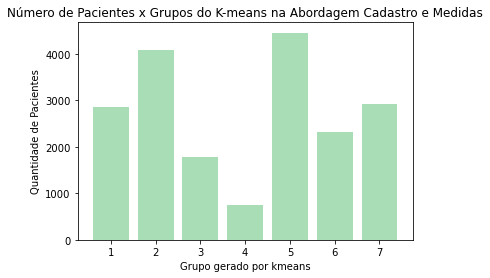

In [29]:
grupos = grupos_cadastro_funcao
abordagem = 'Abordagem Cadastro e Medidas'
caminho = DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg'
classes_cadastro = grafico_barras_grupos(grupos,abordagem,caminho)

In [30]:
def aplica_elbow(dados_sem_id,abordagem,caminho):
    inicio = time.time()
    dados_array = np.array(dados_sem_id)
    Sum_of_squared_distances = []
    
    eixo_x = list(range(1,20))
    
    for k in range(1,20):
        km = KMeans(n_clusters=k)
        km = km.fit(dados_cadastro_array)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(eixo_x, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Soma das Distâncias ao Quadrado')
    plt.title(f'Metodo Elbow Para Otimizar k - {abordagem}')
    fig = plt.gcf() 
    fig.savefig( caminho, format="svg")
    plt.show()
    fim = time.time()
    print(f'Tempo de execucao: {round(fim - inicio,3)} s\n\n')

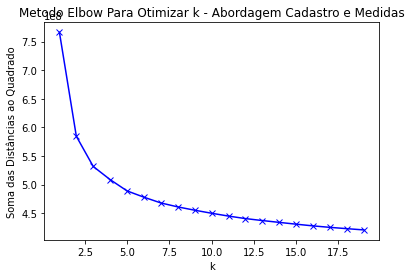

Tempo de execucao: 41.35 s




In [31]:
grupos = grupos_cadastro_funcao
abordagem = 'Abordagem Cadastro e Medidas'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_cadastro_sem_id,abordagem,caminho)

## Gráfico Silhouette para avaliar qualidade dos clusters

In [32]:
def aplica_silhouette(dados_sem_id,grupos,abordagem):
    inicio = time.time()
    dados_array = np.array(dados_sem_id)
    range_n_clusters = range(2,len(set(grupos)) + 1)
    for n_clusters in range_n_clusters:    
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        # O 1st subplot é o grafico silhouette
        # O coeficiente silhouette  um range de -1, 1 but in this example all
        # Os exemplos vão ficar em [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
        # Para gerar destaque
        ax1.set_ylim([0, len(dados_array) + (n_clusters + 1) * 10])
        # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
        # seed 10.
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(dados_array)
    # O silhouette_score fornece o valor médio para todas as amostras.
        # Isso dá uma perspectiva sobre a densidade e separação das formas
        # clusters
        #  Cálculo de toda a matriz que entra no cálculo do Silhouette
        silhouette_avg = silhouette_score(dados_array, cluster_labels)
        print("Para n_clusters =", n_clusters,
              "O score_silhouette medio e :", silhouette_avg)
        # Calcule as pontuações da silhueta para cada amostra
        sample_silhouette_values = silhouette_samples(dados_array, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            # Agregue as pontuações de silhueta para amostras pertencentes a
            # cluster i, e classifica-los
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color,       alpha=0.7)
            # Rotule os gráficos de silhueta com seus números de cluster no meio
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Calcule o novo y_lower para o próximo gráfico
            y_lower = y_upper + 10  #10 para as 0 amostras
        ax1.set_title("O grafico de silhueta para os varios clusters.")
        ax1.set_xlabel("O valor silhouette coefficient")
        ax1.set_ylabel("Cluster label")
        # A linha vertical para a pontuação média da silhueta de todos os valores
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Limpar os yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        # 2º gráfico mostrando os clusters reais formados
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(dados_array[:, 0], dados_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        # Labeling dos clusters
        centers = clusterer.cluster_centers_
        # Desenhe círculos brancos nos centros do cluster
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
        ax2.set_title("A visualizacao dos dados agrupados.")
        ax2.set_xlabel("Eixo X X0")
        ax2.set_ylabel("Eixo Y X1")
        plt.suptitle((f"Analise de silhueta para agrupamento KMeans na Abordagem {abordagem}"
                      "com n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        fig = plt.gcf()
        fig.savefig( DIR_KMEANS / 'graficos' / f'metodo_silhouette_{abordagem.lower().replace(" " ,"_")}_{n_clusters}.svg',
                    format="svg")

    plt.show()
    fim = time.time()
    print(f'Tempo de execucao: {round(fim - inicio,3)} s\n\n')

In [33]:
classes_cadastro

[1, 2, 3, 4, 5, 6, 7]

Para n_clusters = 2 O score_silhouette medio e : 0.20438485259688363
Para n_clusters = 3 O score_silhouette medio e : 0.12698921132073093
Para n_clusters = 4 O score_silhouette medio e : 0.08227575946144847
Para n_clusters = 5 O score_silhouette medio e : 0.07774326040264627
Para n_clusters = 6 O score_silhouette medio e : 0.06175755172991216
Para n_clusters = 7 O score_silhouette medio e : 0.05829610625432453


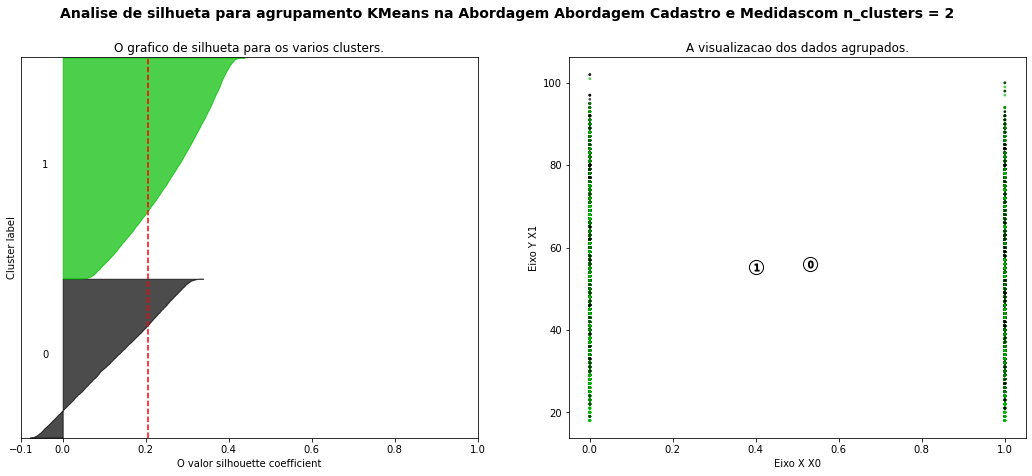

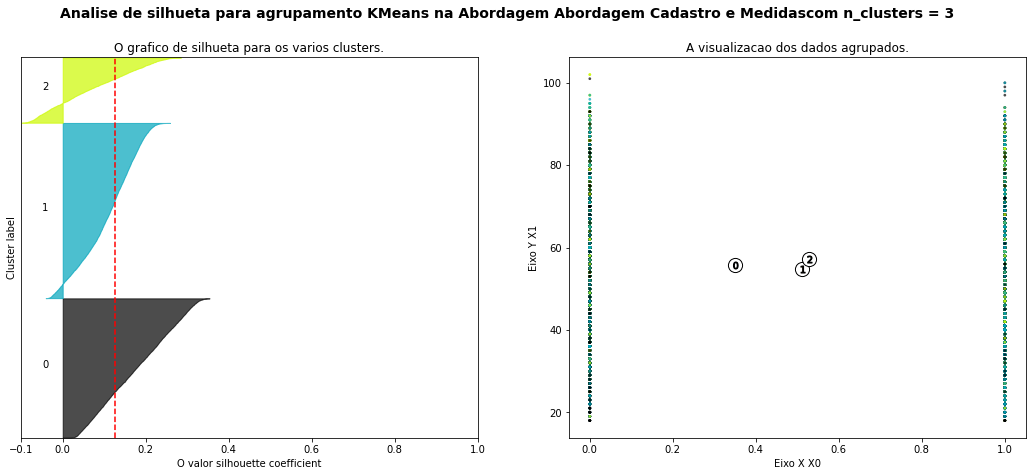

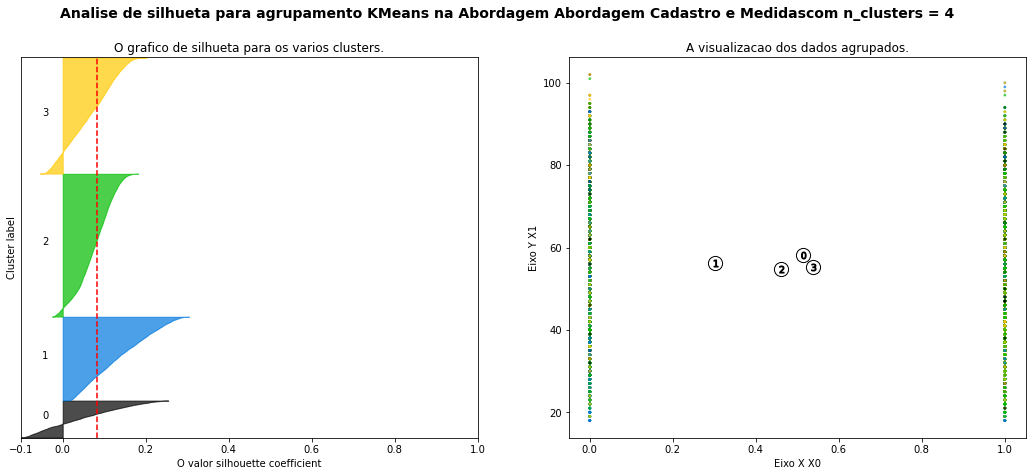

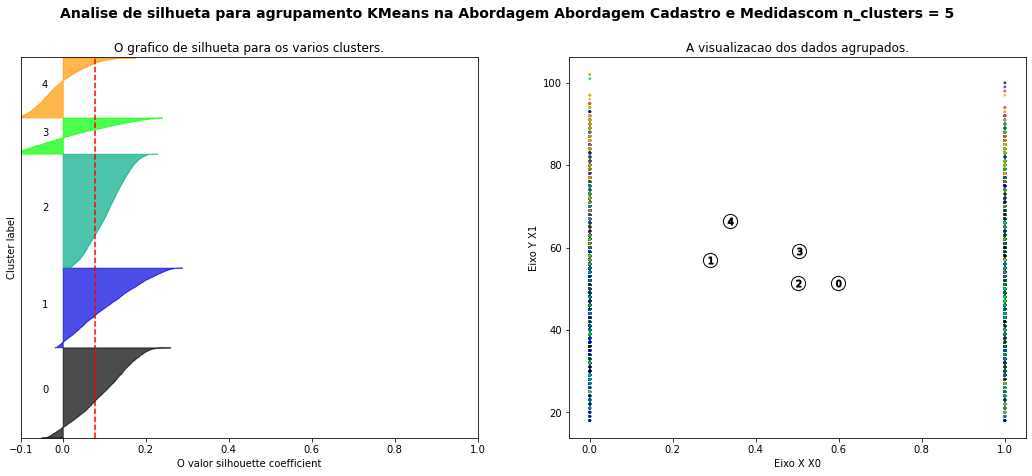

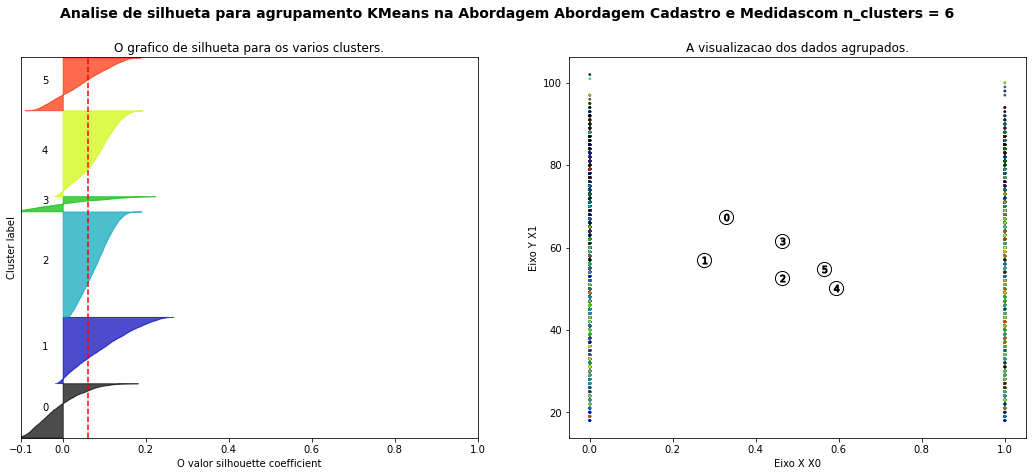

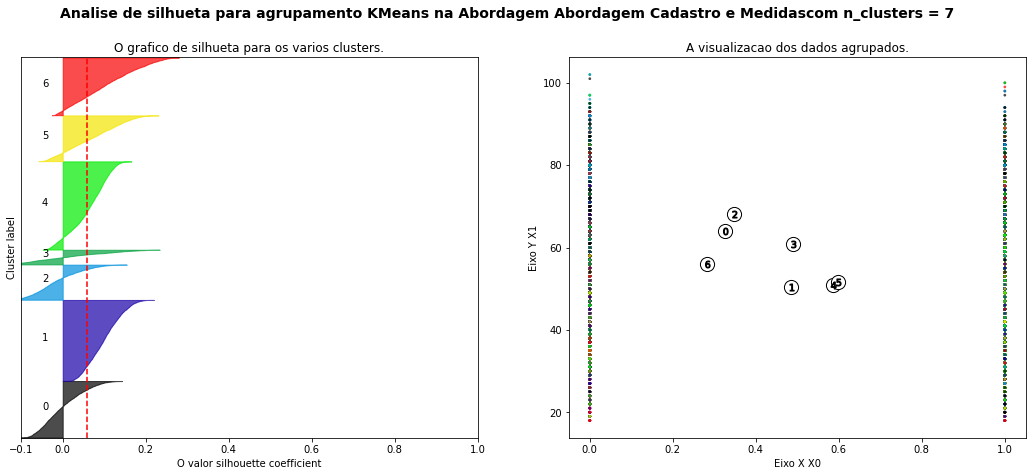

Tempo de execucao: 59.988 s




In [34]:
classes_cadastro
grupos = grupos_cadastro_funcao
abordagem = 'Abordagem Cadastro e Medidas'
caminho = DIR_KMEANS / 'graficos' / f'metodoelbow_cadastro.svg'
aplica_silhouette(dados_cadastro_sem_id,grupos,abordagem)

In [35]:
def aplica_random_forest(dados_sem_id,grupos,abordagem,classes):
    dados_array = np.array(dados_sem_id)
    random_forest = RandomForestClassifier(n_estimators=50)
    
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    # separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
    #  O parâmetro random_state=42 garante o rastreio do numero de identificação
    # 
    x_train, x_test, y_train, y_test = train_test_split(dados_array,grupos,test_size=1-train_ratio,random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(dados_array,grupos,test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)
    
    #treino
    random_forest.fit(x_train, y_train)
    
    #calcular acuracia, recall e f1
    y_prev_val = random_forest.predict(x_val)

    accuracy = np.round(accuracy_score(y_val, y_prev_val),2)
    recall = np.round(recall_score(y_val, y_prev_val,average='macro'),2)
    f1 = np.round(f1_score(y_val, y_prev_val,average='macro'),2)
    
    
    
    print("\n\n=================Validação==============\n\n")
    print(f'Accuracy: {accuracy:.2f} - Recall: {recall:.2f} - F1 Score: {f1:.2f}\n\n')
    
    #Matriz de Confusão Validação
    mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
    df_confusion_matrix_val = pd.DataFrame(mat,index = classes, columns = classes)
    
    print(df_confusion_matrix_val)
    
    #calcular acuracia, recall e f1
    y_prev_test = random_forest.predict(x_test)

    accuracy = np.round(accuracy_score(y_test, y_prev_test),2)
    recall = np.round(recall_score(y_test, y_prev_test,average='macro'),2)
    f1 = np.round(f1_score(y_test, y_prev_test,average='macro'),2)
    
    
    
    print("\n\n=================Teste==============\n\n")
    print(f'Accuracy: {accuracy:.2f} - Recall: {recall:.2f} - F1 Score: {f1:.2f}\n\n')
    
    #Matriz da Confusão Teste
    mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
    df_confusion_matrix_test = pd.DataFrame(mat,index = classes, columns = classes)
    
    print(df_confusion_matrix_test)
    
    
    
    ##validacao
    #pacientes_validacao_diast_sisto = x_val[['numero_identificacao']]
    #pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
    #pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val
    #
    #pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / f'pacientes_validacao_{abordagem.lower().replace(" " ,"_")}.csv', 
    #             sep=';',index=False,encoding='UTF-8')
    #
    ##teste
    #pacientes_teste_diast_sisto = x_test[['numero_identificacao']]
    #pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
    #pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test
    #
    #pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / f'pacientes_teste_{abordagem.lower().replace(" " ,"_")}.csv', 
    #             sep=';',index=False,encoding='UTF-8')
    #
    #
    
    cabecalho = list(dados_sem_id.columns)
    #calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
    importancia = pd.DataFrame({'features':cabecalho,'importance':np.round(random_forest.feature_importances_,3)})
    importancia = importancia.sort_values('importance',ascending=False)

    importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / f'importancia_features_{abordagem.lower().replace(" " ,"_")}.csv', 
                 sep=';',index=False,encoding='UTF-8')

    print("\n\n=================Importancia==============\n\n")
    print(importancia)
    return importancia

In [36]:
classes_cadastro
grupos = grupos_cadastro_funcao
abordagem = 'Abordagem Cadastro e Medidas'
importancia_cadastro = aplica_random_forest(dados_cadastro_sem_id,grupos,abordagem,classes_cadastro)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3    4     5     6     7
1  1723     0     0    0     0     0     0
2     0  2461     0    0     0     0     0
3     0     0  1054    0     0     0     0
4     0     0     0  454     0     0     0
5     0     0     0    0  2670     0     0
6     0     0     0    0     0  1410     0
7     0     0     0    0     0     0  1718


=================Teste==============


Accuracy: 0.91 - Recall: 0.89 - F1 Score: 0.90


      1     2    3    4     5    6     7
1  1018    58    9    0    29    0    23
2    26  1506    0    0    68    0    27
3    47     0  594    0    55   24     0
4     0     0   16  233     0   39     0
5    19    50   10    0  1697   11     0
6     0     0   10    2    97  794     0
7    22    58    0    0     0    0  1118


=================Importancia==============


        features  importance
74     sist 6:15       0.018
76     sist 6:45       0.015
122  diast

In [37]:
from sklearn.ensemble import RandomForestClassifier

#### Abordagem 2: Importância das Features Random Forest

# Abordagem 1: Cadastro e Medidas como entrada

## Abordagem 1: Número de Clusters gerado pelo k-Means

In [38]:
dados_cadastro_sem_id = dataset_cadastro.loc[:,'genero':'diast 8:45']
dados_cadastro_array = np.array(dados_cadastro_sem_id)

grupos_cadastro_funcao = aplica_kmeans(dados_cadastro_sem_id, 'Cadastro')
print(grupos_cadastro_funcao)



Numero otimo de cluster - Abordagem Cadastro: 7


Tempo de execucao: 36.903 s


[1 7 3 ... 7 2 5]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


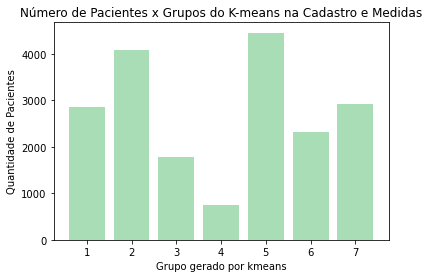

In [39]:
grupos = grupos_cadastro_funcao
abordagem = 'Cadastro e Medidas'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_cadastro = grafico_barras_grupos(grupos,abordagem,caminho)

## Abordagem 1: O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

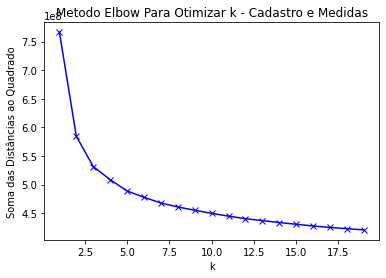

Tempo de execucao: 33.51 s




In [40]:
grupos = grupos_cadastro_funcao
abordagem = 'Cadastro e Medidas'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_cadastro_sem_id,abordagem,caminho)

## Abordagem 1: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20438485259688363
Para n_clusters = 3 O score_silhouette medio e : 0.12698921132073093
Para n_clusters = 4 O score_silhouette medio e : 0.08227575946144847
Para n_clusters = 5 O score_silhouette medio e : 0.07774326040264627
Para n_clusters = 6 O score_silhouette medio e : 0.06175755172991216
Para n_clusters = 7 O score_silhouette medio e : 0.05829610625432453


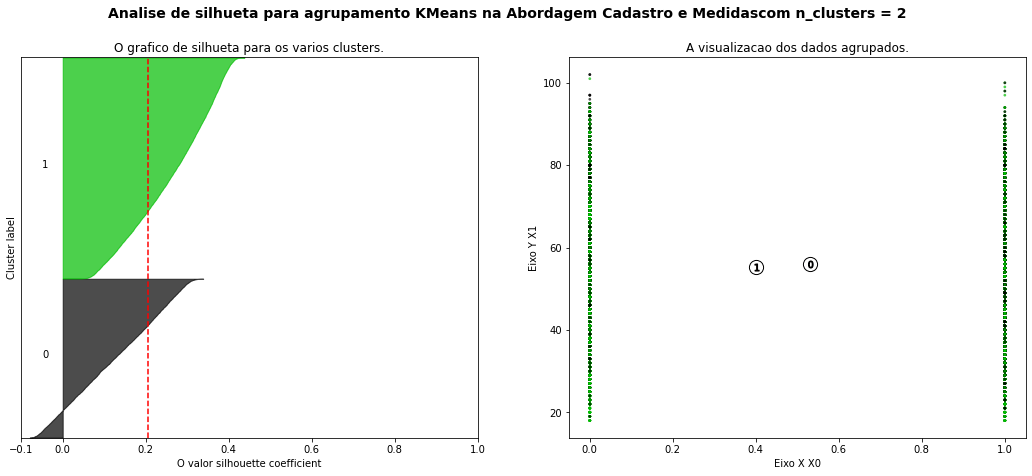

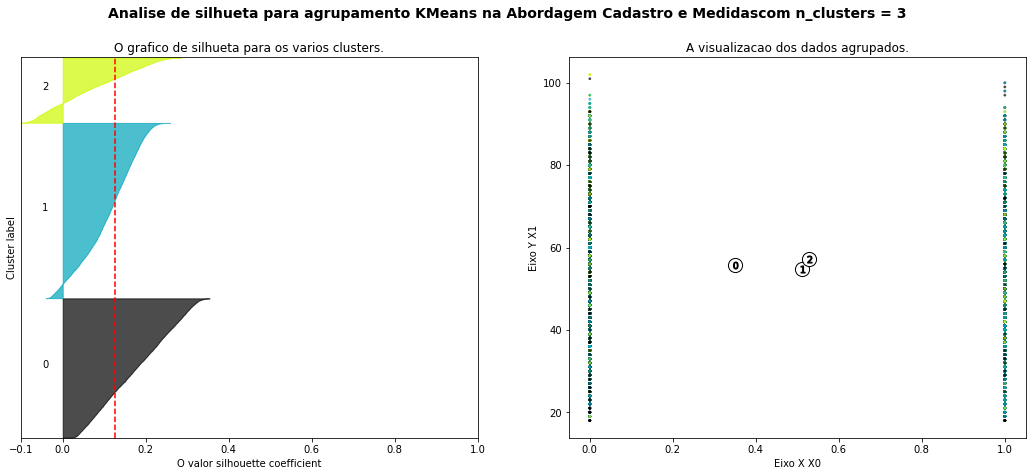

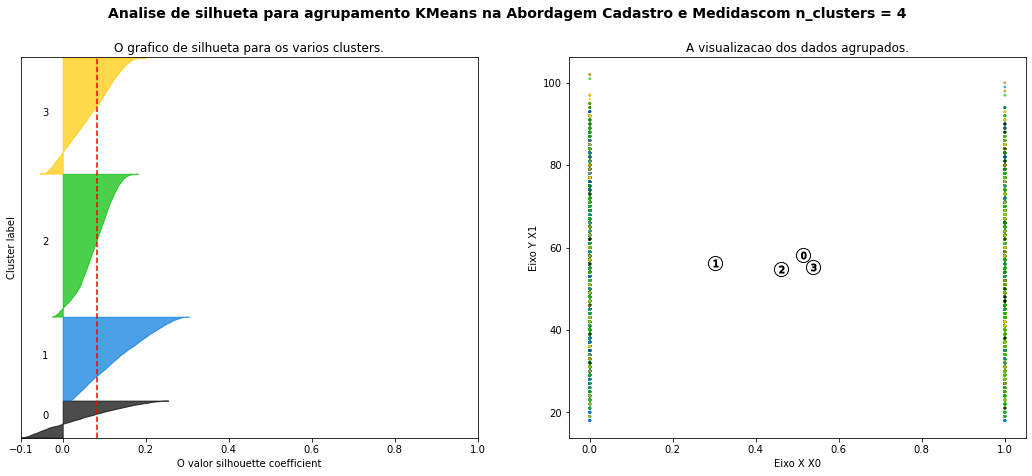

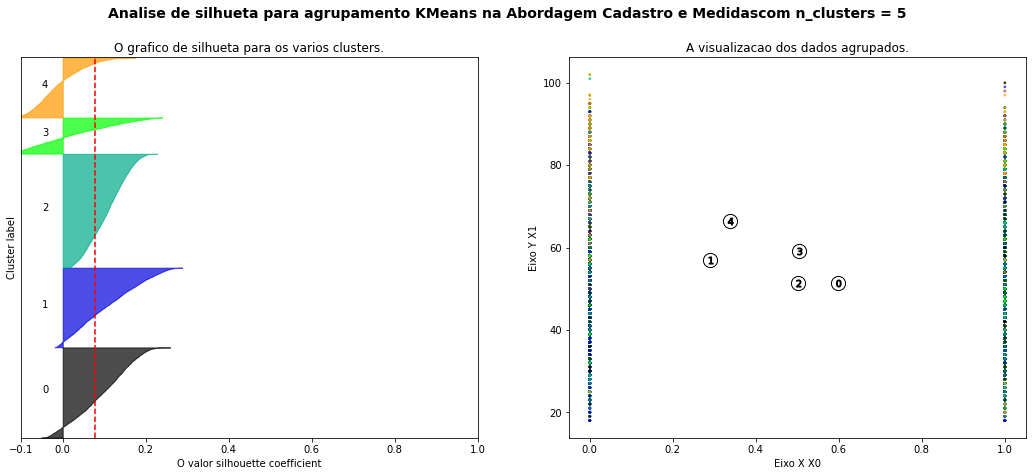

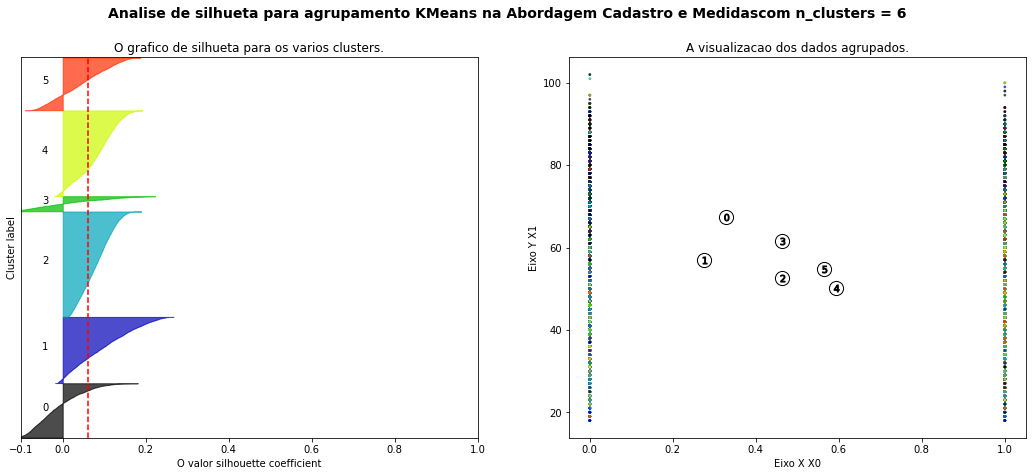

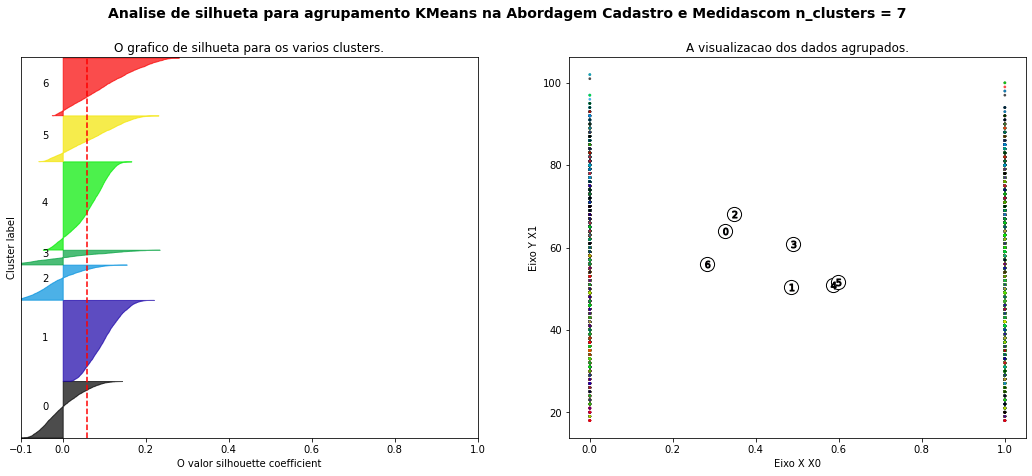

Tempo de execucao: 56.149 s




In [41]:
classes_cadastro
grupos = grupos_cadastro_funcao
abordagem = 'Cadastro e Medidas'
caminho = DIR_KMEANS / 'graficos' / f'metodo_silhouette_{abordagem.lower().replace(" ","_")}.svg'
aplica_silhouette(dados_cadastro_sem_id,grupos,abordagem)

### Não existe um valor de k clusters que não esteja se intersectando 

In [42]:
##dataset com grupos e com os dados de cadastro e medidas
## nume id, data exame, idade, peso, altura, medidas, 22 estaitsticos, 11 doenças em cada grupo 
#dataset_s_d = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_s_d['IMC'] = dataset_cadastro['IMC']
#dataset_s_d['grupo'] = grupos_cadastro
#dataset_s_d = pd.concat([dataset_s_d,dataset_apos_tratamento.loc[:,'sist 9:00':]],axis=1)
#dataset_s_d
#
## Salva dataset com dados completos após o K-Means com abordagem 1 (cadastro e medidas)
#dataset_s_d.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_cadastro.csv', 
#             sep=';',index=False,encoding='UTF-8')

## Abordagem 1: Random Forest

In [43]:
classes_cadastro
grupos = grupos_cadastro_funcao
abordagem = 'Cadastro e Medidas'
#caminho = DIR_KMEANS / 'graficos' / f'metodoelbow_cadastro.svg'
importancia_cadastro = aplica_random_forest(dados_cadastro_sem_id,grupos,abordagem,classes_cadastro)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3    4     5     6     7
1  1723     0     0    0     0     0     0
2     0  2461     0    0     0     0     0
3     0     0  1054    0     0     0     0
4     0     0     0  454     0     0     0
5     0     0     0    0  2670     0     0
6     0     0     0    0     0  1410     0
7     0     0     0    0     0     0  1718


=================Teste==============


Accuracy: 0.91 - Recall: 0.89 - F1 Score: 0.90


      1     2    3    4     5    6     7
1  1005    62   15    0    25    0    30
2    29  1507    0    0    69    0    22
3    53     0  594    3    53   17     0
4     0     0   12  237     0   39     0
5    16    50    8    0  1702   11     0
6     0     0   11    0    92  800     0
7    21    59    0    0     0    0  1118


=================Importancia==============


        features  importance
74     sist 6:15       0.016
76     sist 6:45       0.015
93   diast

In [44]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_cadastro_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_cadastro,'cadastro')

# Abordagem 2: Medidas como entrada

## Abordagem 2: Número de Clusters gerado pelo k-Means

In [45]:
dados_medidas_sem_id = dataset_medidas.loc[:,'sist 9:00':'diast 8:45']
dados_medidas_array = np.array(dados_medidas_sem_id)

grupos_medidas_funcao = aplica_kmeans(dados_medidas_sem_id, 'Medidas')
print(grupos_medidas_funcao)



Numero otimo de cluster - Abordagem Medidas: 7


Tempo de execucao: 40.78 s


[1 1 3 ... 1 2 7]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


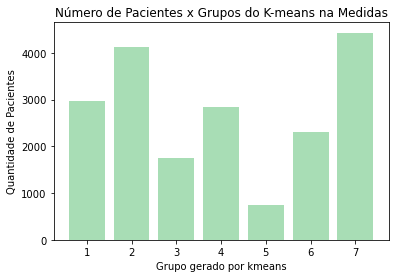

In [46]:
grupos = grupos_medidas_funcao
abordagem = 'Medidas'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_medidas = grafico_barras_grupos(grupos,abordagem,caminho)

###  Abordagem 2: Método Elbow
####  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
####  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

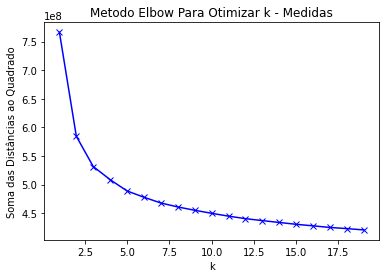

Tempo de execucao: 38.55 s




In [47]:
grupos = grupos_medidas_funcao
abordagem = 'Medidas'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_medidas_sem_id,abordagem,caminho)

### Abordagem 2: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20556068194132648
Para n_clusters = 3 O score_silhouette medio e : 0.12817200383813093
Para n_clusters = 4 O score_silhouette medio e : 0.0828335775668247
Para n_clusters = 5 O score_silhouette medio e : 0.07871120462971788
Para n_clusters = 6 O score_silhouette medio e : 0.06106949271057454
Para n_clusters = 7 O score_silhouette medio e : 0.059065673771412655


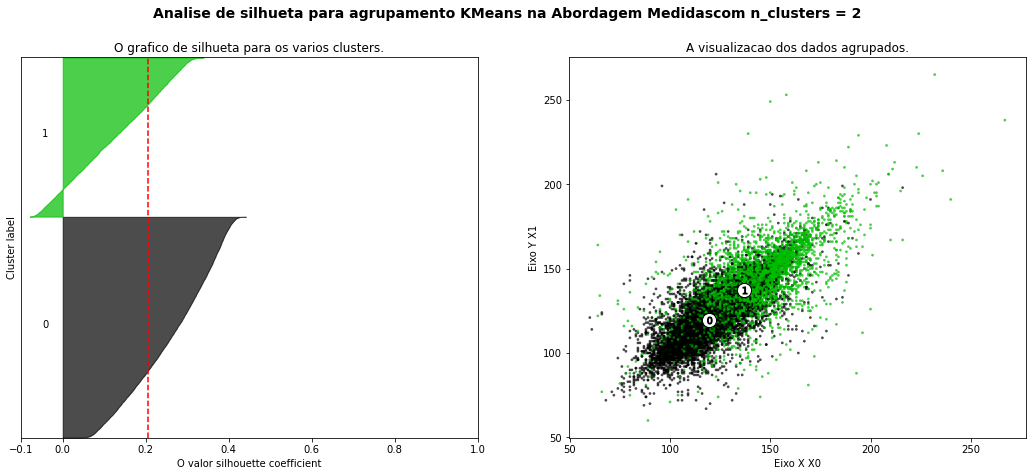

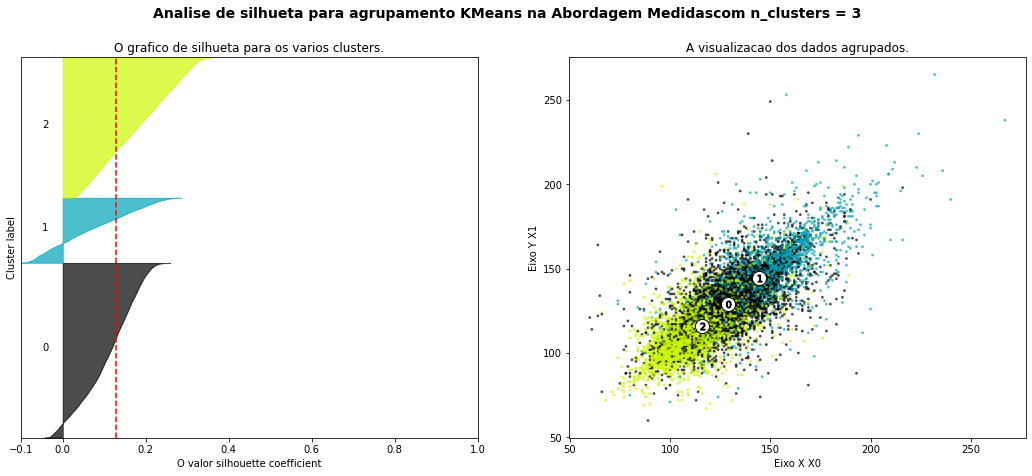

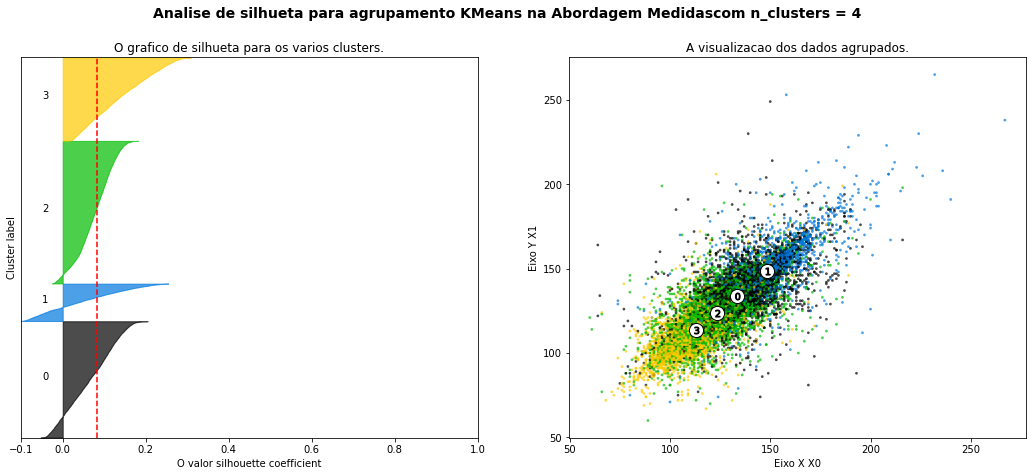

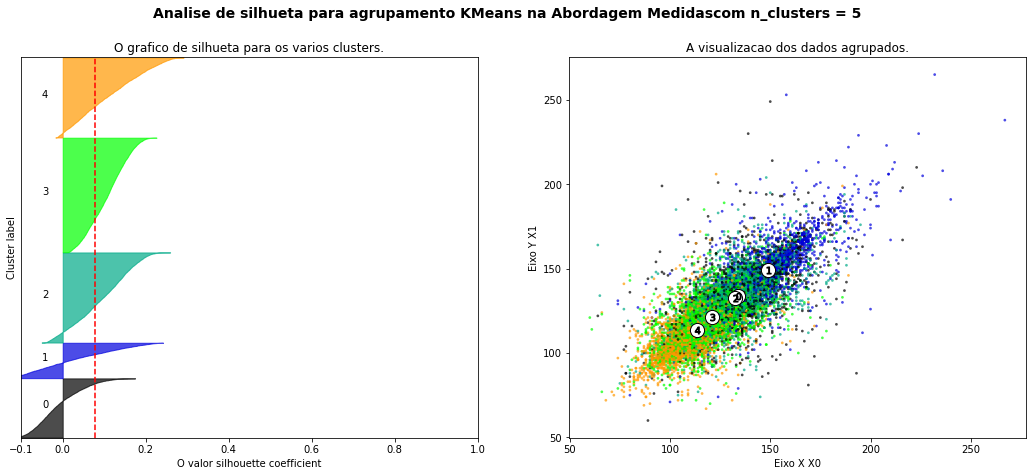

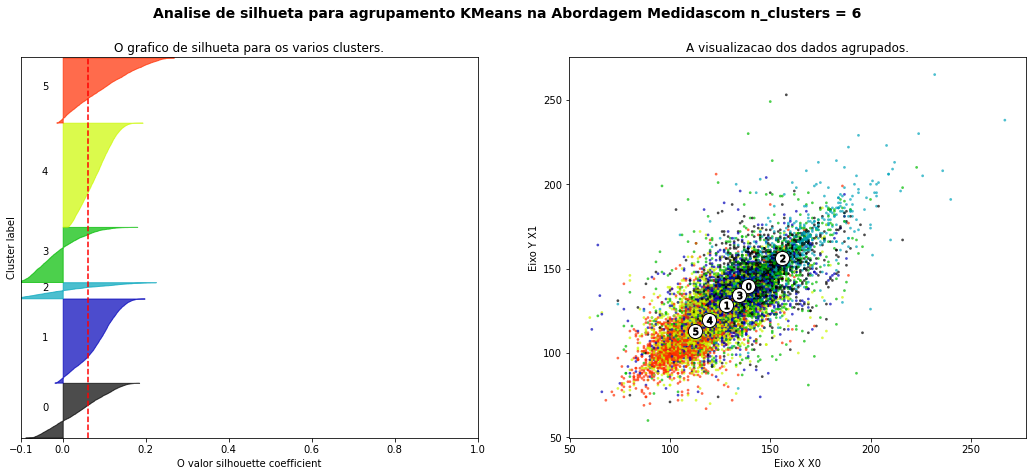

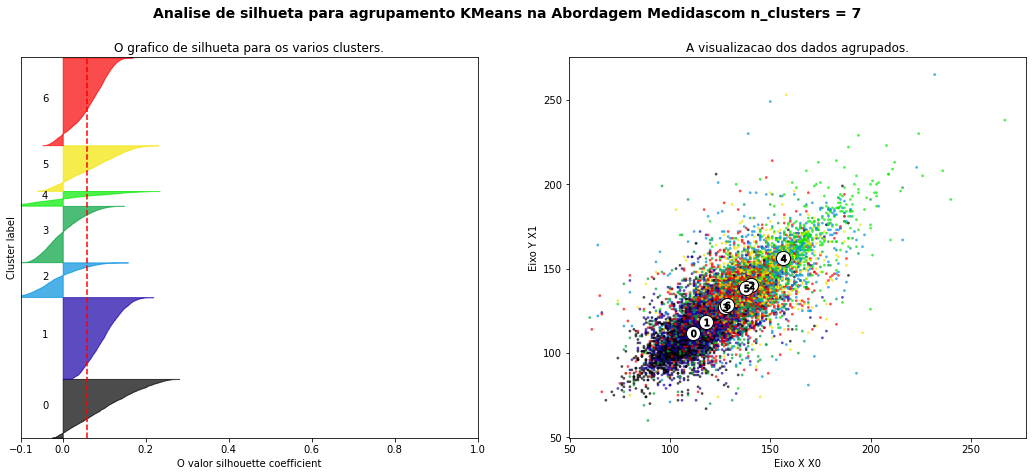

Tempo de execucao: 55.859 s




In [48]:
grupos = grupos_medidas_funcao
abordagem = 'Medidas'
aplica_silhouette(dados_medidas_sem_id,grupos,abordagem)

### Não existe um valor de k clusters que não esteja se intersectando¶

### Abordagem 2: Random Forest

In [49]:
grupos = grupos_medidas_funcao
abordagem = 'Medidas'
importancia_medidas = aplica_random_forest(dados_medidas_sem_id,grupos,abordagem,classes_medidas)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3     4    5     6     7
1  1749     0     0     0    0     0     0
2     0  2479     0     0    0     0     0
3     0     0  1042     0    0     0     0
4     0     0     0  1720    0     0     0
5     0     0     0     0  454     0     0
6     0     0     0     0    0  1403     0
7     0     0     0     0    0     0  2643


=================Teste==============


Accuracy: 0.91 - Recall: 0.89 - F1 Score: 0.91


      1     2    3    4    5    6     7
1  1155    43    0   19    0    0     0
2    36  1534    0   23    0    0    51
3     0     0  603   36    2   24    40
4    34    75   14  978    0    0    24
5     0     0   12    0  233   43     0
6     0     0   14    0    4  797    80
7     0    66    8   17    0   14  1681


=================Importancia==============


        features  importance
73     sist 6:45       0.017
71     sist 6:15       0.015
89   diast 10:45  

In [50]:
#dados_completos_sist = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
#                                    pd.DataFrame({'grupo':grupos_sist_funcao}),
#                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
#                                   axis=1)
#
#gera_arquivos_por_grupo(dados_completos_simples,'simplificado')

In [51]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_medidas_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

# Abordagem 2.1: Medidas Importantes

## Abordagem 2.1: Número de Clusters gerado pelo k-Means

In [52]:
ls_importantes = importancia_medidas['features'].iloc[:7].values
dados_medidas_importantes_sem_id = dataset_medidas[ls_importantes]
grupos_medidas_importantes_funcao = aplica_kmeans(dados_medidas_importantes_sem_id, 'Medidas Importantes')
print(grupos_medidas_importantes_funcao)



Numero otimo de cluster - Abordagem Medidas Importantes: 7


Tempo de execucao: 8.711 s


[6 5 2 ... 6 5 6]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


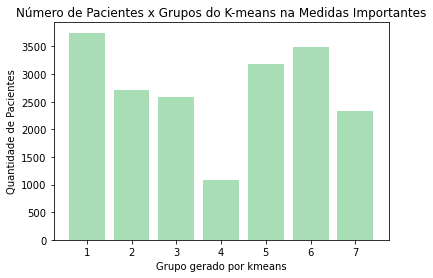

In [53]:
grupos = grupos_medidas_importantes_funcao
abordagem = 'Medidas Importantes'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_medidas_importantes = grafico_barras_grupos(grupos,abordagem,caminho)

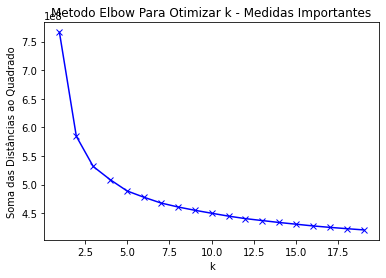

Tempo de execucao: 38.408 s




In [54]:
grupos = grupos_medidas_importantes_funcao
abordagem = 'Medidas Importantes'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_medidas_importantes_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.3128298568270646
Para n_clusters = 3 O score_silhouette medio e : 0.21903650050447526
Para n_clusters = 4 O score_silhouette medio e : 0.20740830753957432
Para n_clusters = 5 O score_silhouette medio e : 0.18337874445256783
Para n_clusters = 6 O score_silhouette medio e : 0.1703426840371563
Para n_clusters = 7 O score_silhouette medio e : 0.1695789490707995


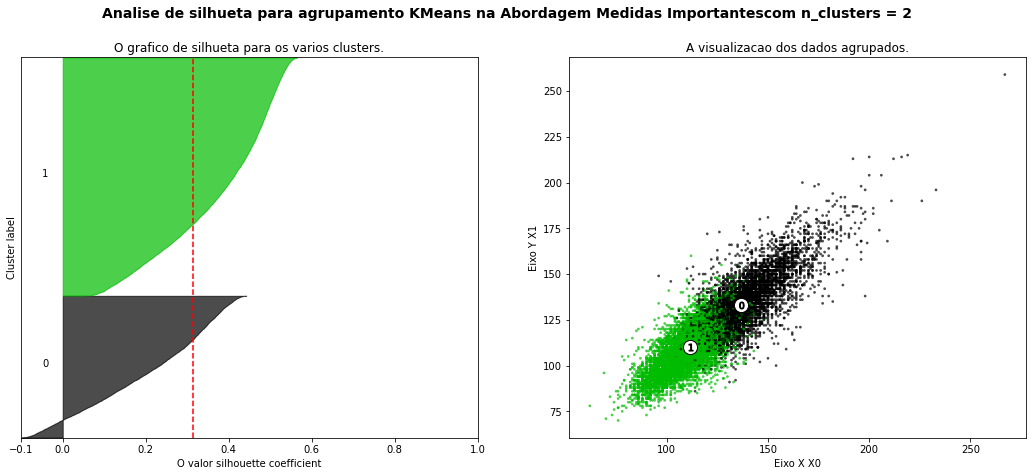

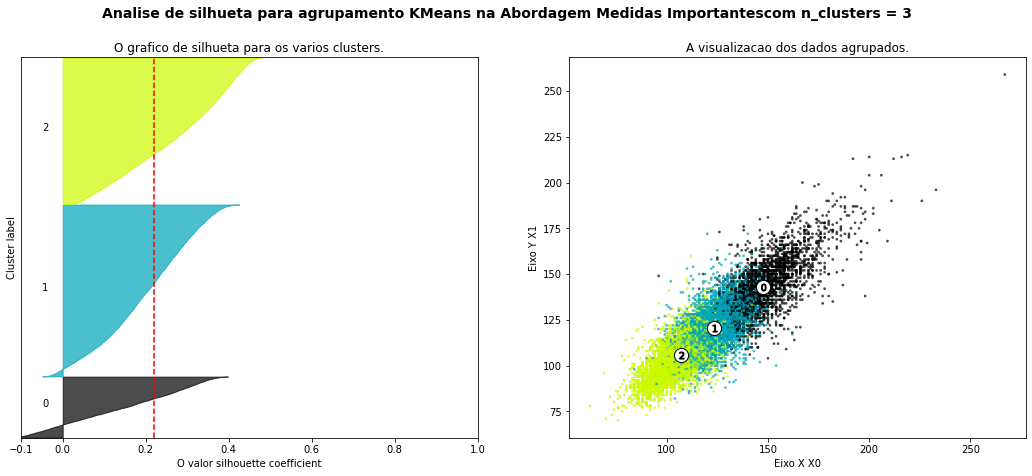

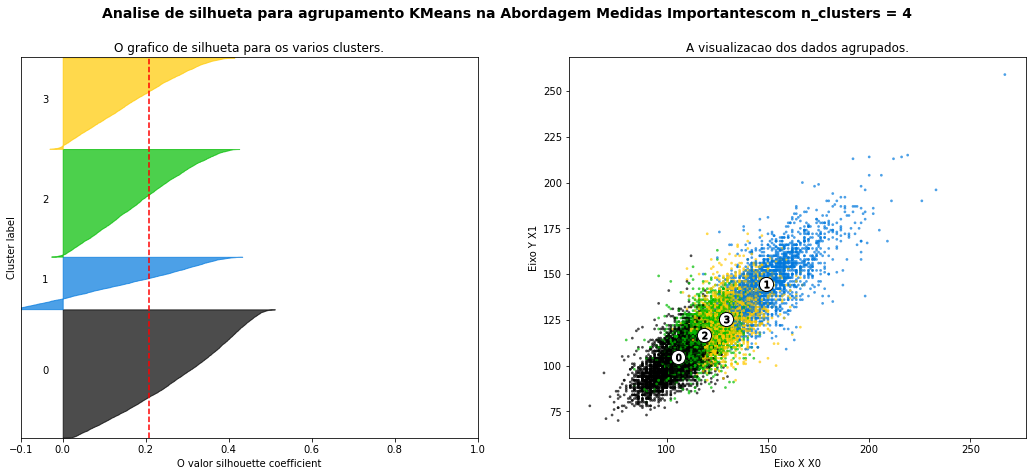

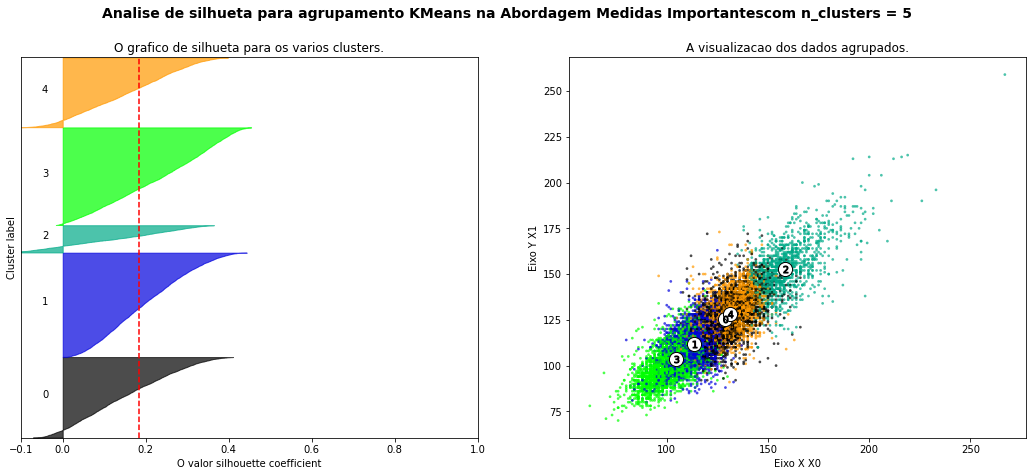

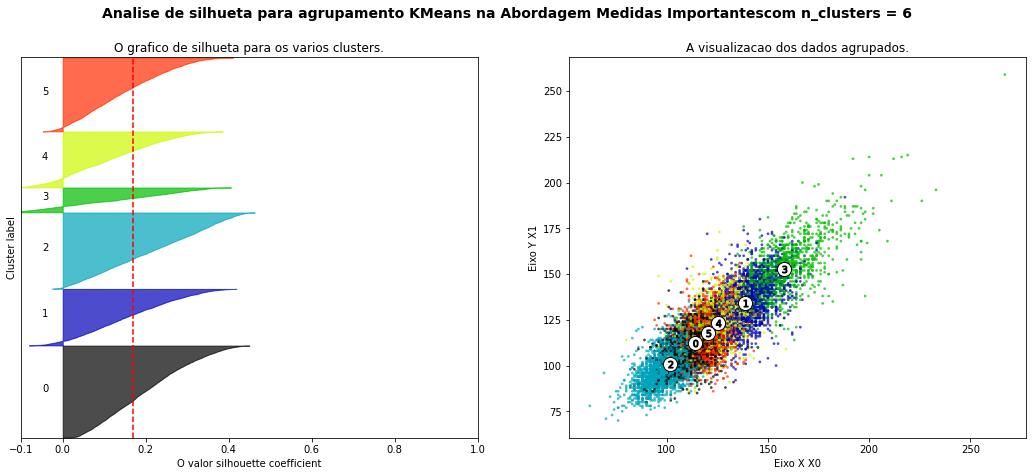

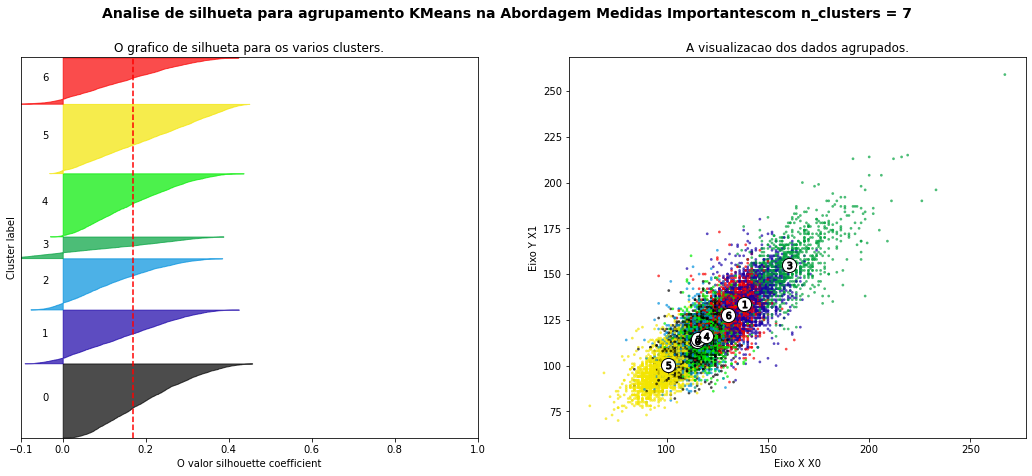

Tempo de execucao: 49.424 s




In [55]:
grupos = grupos_medidas_importantes_funcao
abordagem = 'Medidas Importantes'
aplica_silhouette(dados_medidas_importantes_sem_id,grupos,abordagem)

In [56]:
grupos = grupos_medidas_importantes_funcao
abordagem = 'Medidas Importantes'
importancia_medidas_importantes = aplica_random_forest(dados_medidas_importantes_sem_id,grupos,abordagem,classes_medidas_importantes)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3    4     5     6     7
1  2275     0     0    0     0     0     0
2     0  1600     0    0     0     0     0
3     0     0  1558    0     0     0     0
4     0     0     0  654     0     0     0
5     0     0     0    0  1900     0     0
6     0     0     0    0     0  2064     0
7     0     0     0    0     0     0  1439


=================Teste==============


Accuracy: 0.95 - Recall: 0.95 - F1 Score: 0.95


      1     2    3    4     5     6    7
1  1407     9   18    0    12    18    9
2    13  1051   10   10    11     0   15
3    23    14  965    0     3     5   16
4     0     7    0  419     0     0   10
5    18    29   13    0  1211    14    0
6     9     0    9    0    20  1395    0
7    15    16   10    6     0     0  850


=================Importancia==============


      features  importance
0    sist 6:45       0.221
3   sist 20:15       0.155
4   sist 20:00  

In [57]:
dados_completos_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_medidas_importantes_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_medidas_importantes,'medidas_importantes')

# Abordagem 2.2: Features Selection: Select Kbest na Abordagem 2

In [58]:
#  Uso do SelectKBest para identificar as melhores 5 features

#from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
dados_medidas_sem_id
#medidas_mais_importantes_ml = SelectKBest(chi2, k=7).fit_transform(dados_medidas_array, grupos_medidas)
medidas_mais_importantes_ml = SelectKBest(score_func=chi2, k=7).fit_transform(dados_medidas_sem_id.iloc[:,:-1], grupos_medidas_funcao)

In [59]:
ls_score = SelectKBest(chi2, k=7).score_func(dados_medidas_sem_id.iloc[:,:-1], grupos_medidas_funcao)[0]

ls_score_indice = []

for indice, score in enumerate(ls_score):
    ls_score_indice.append((score,indice+1))

for i in range(len(ls_score_indice)):
    for j in range(i+1,len(ls_score_indice)):
        if (ls_score_indice[j][0] > ls_score_indice[i][0]):
            aux = ls_score_indice[j]
            ls_score_indice[j] = ls_score_indice[i]
            ls_score_indice[i] = aux

#print(ls_score_indice[:7])

In [60]:
#SelectKBest(chi2, k=7).score_func(dados_medidas_sem_id.iloc[:,:-1], grupos_medidas_funcao)

In [61]:
#medidas_mais_importantes_ml

In [62]:
#medidas_transformadas[70]

In [63]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

medidas_mais_importantes = pd.DataFrame(medidas_mais_importantes_ml)

In [64]:
# identificação de quais colunas foram escolhidas
#
lista_colunas_escolhidas = []
#
## X é o dataset das doenças que precisa ser transformado em df
medidas_transformadas = pd.DataFrame(dados_medidas_array)


for coluna_ml in range(len(medidas_mais_importantes.columns)):
    for coluna_base in range(len(medidas_transformadas.columns)):
        # para identificar valores únicos
        if set(np.array(medidas_transformadas[coluna_base]) == np.array(medidas_mais_importantes[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

#lista_colunas_escolhidas,list(dados_medidas_sem_id.iloc[:,lista_colunas_escolhidas].columns)

In [65]:
#selecionando padrões de doencas

ls_medidas_kbest = ['sist 5:30', 'sist 6:00', 'sist 6:15', 'sist 6:30', 'sist 6:45', 'sist 7:00', 'sist 7:15']
ls_medidas_kbest = list(dados_medidas_sem_id.iloc[:,lista_colunas_escolhidas].columns)

dados_padrao_medidas_kbest =  dataset_apos_tratamento[ls_medidas_kbest]
#dados_padrao_medidas_kbest

## K-means para Abordagem 2.2: SelectKbest

In [66]:
dados_medidas_kbest_sem_id = dados_padrao_medidas_kbest
grupos_medidas_kbest_funcao = aplica_kmeans(dados_medidas_kbest_sem_id, 'Medidas Kbest')
print(grupos_medidas_kbest_funcao)



Numero otimo de cluster - Abordagem Medidas Kbest: 6


Tempo de execucao: 8.068 s


[3 4 2 ... 3 4 3]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


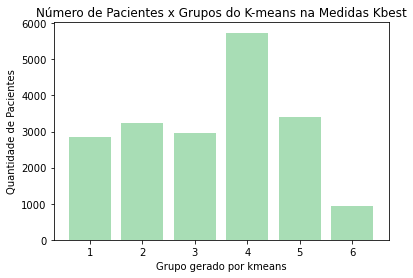

In [67]:
grupos = grupos_medidas_kbest_funcao
abordagem = 'Medidas Kbest'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_medidas_kbest = grafico_barras_grupos(grupos,abordagem,caminho)

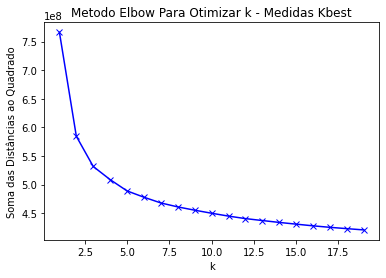

Tempo de execucao: 38.246 s




In [68]:
grupos = grupos_medidas_kbest_funcao
abordagem = 'Medidas Kbest'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_medidas_kbest_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.40707949337009786
Para n_clusters = 3 O score_silhouette medio e : 0.3134389964469621
Para n_clusters = 4 O score_silhouette medio e : 0.26322609305593536
Para n_clusters = 5 O score_silhouette medio e : 0.218757959172337
Para n_clusters = 6 O score_silhouette medio e : 0.21308925733038747


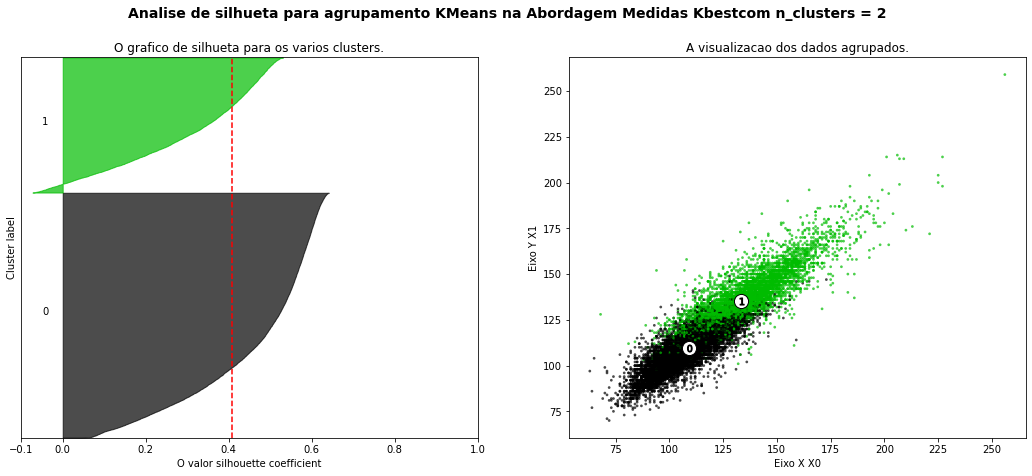

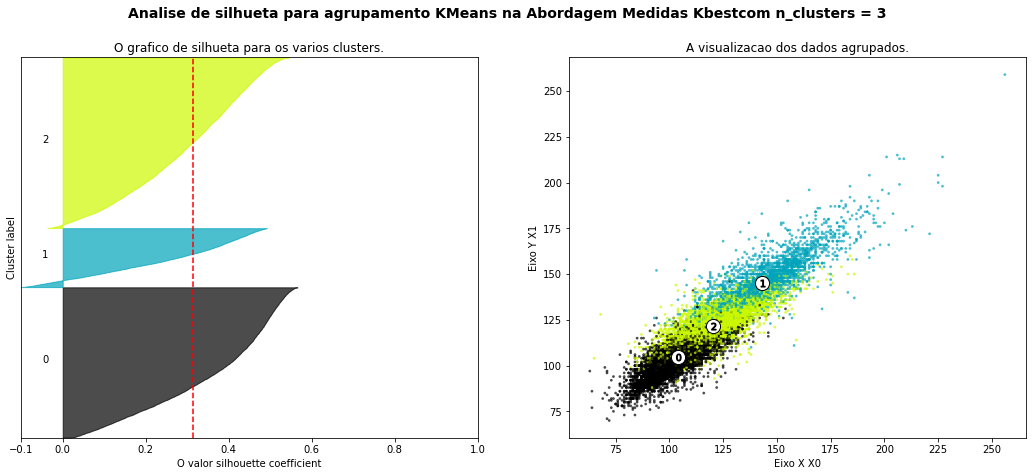

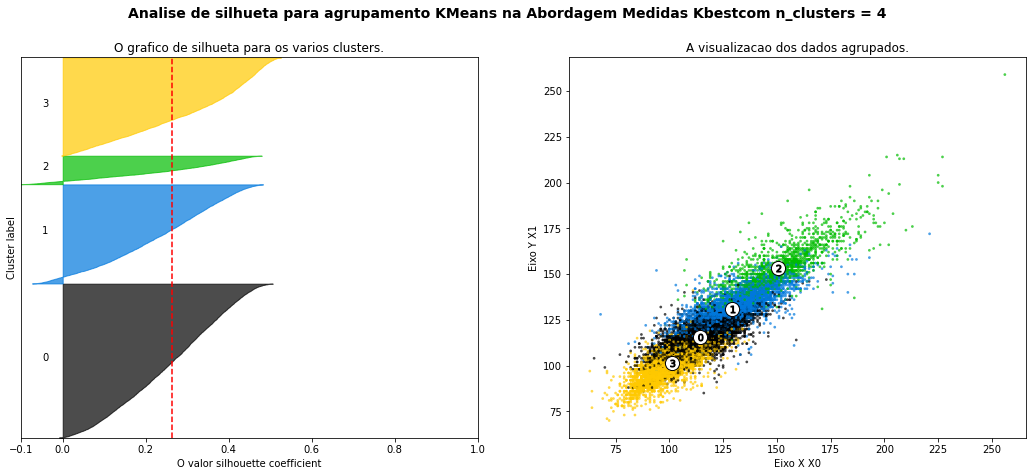

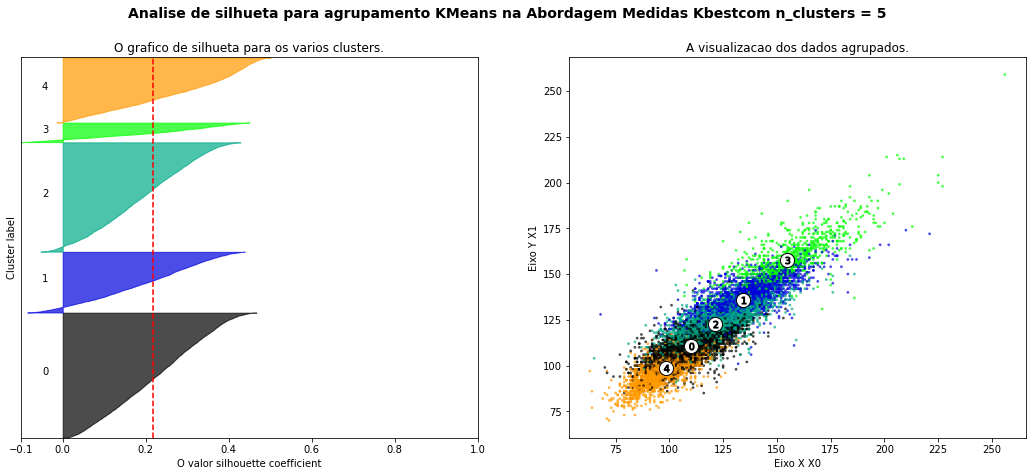

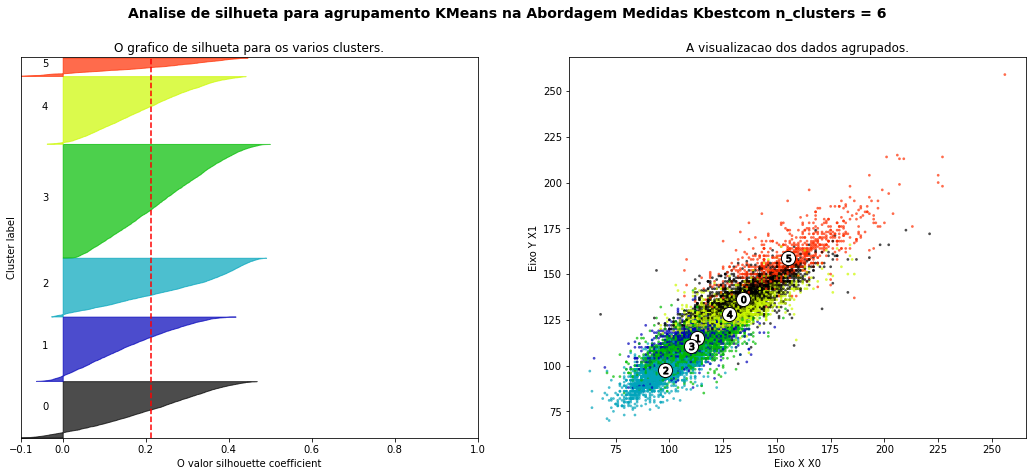

Tempo de execucao: 41.839 s




In [69]:
grupos = grupos_medidas_kbest_funcao
abordagem = 'Medidas Kbest'
aplica_silhouette(dados_medidas_kbest_sem_id,grupos,abordagem)

###  Abordagem 2.2: Random Forest for KBest

In [70]:
grupos = grupos_medidas_kbest_funcao
abordagem = 'Medidas Kbest'
importancia_medidas_kbest = aplica_random_forest(dados_medidas_kbest_sem_id,grupos,abordagem,classes_medidas_kbest)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3     4     5    6
1  1721     0     0     0     0    0
2     0  1983     0     0     0    0
3     0     0  1709     0     0    0
4     0     0     0  3467     0    0
5     0     0     0     0  2054    0
6     0     0     0     0     0  556


=================Teste==============


Accuracy: 0.96 - Recall: 0.96 - F1 Score: 0.97


      1     2     3     4     5    6
1  1100    11     0     0    19    2
2     8  1213     0    25    20    0
3     0     0  1221    32     0    0
4     0    26    38  2190    19    0
5    21    17     0    15  1308    0
6    18     0     0     0     0  357


=================Importancia==============


    features  importance
1  sist 6:15       0.210
3  sist 6:45       0.200
5  sist 7:15       0.173
6  sist 7:30       0.139
4  sist 7:00       0.105
2  sist 6:30       0.097
0  sist 6:00       0.075


In [71]:
dados_completos_medidas_kbest = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_medidas_kbest_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_medidas_kbest,'medidas_kbest')

# Abordagem 3: Estatísticas como entrada

In [72]:
#selecionando variaveis estatisticas


ls_estatistica = [
    'Media Sistolica em 24h',
#    'Media Diastolica em 24h',
#    'Media Sistolica Diurna',
#    'Media Sistolica Matutina',
#    'Media Sistolica Vespertina',
#    'Media Sistolica Daytime',
#    'Media Sistolica Nighttime',
#    'Media Diastolica Diurna',
#    'Media Diastolica Matutina',
#    'Media Diastolica Vespertina',
#    'Media Diastolica Daytime',
#    'Media Diastolica Nighttime',
#    'Variancia Sistolica em 24h',
#    'Variancia Diastolica em 24h',
#    'Mediana Sistolica em 24h',
#    'Mediana Diastolica em 24h',
    'AUC Sistolica em 24h',
    'AUC Diastolica em 24h',
    'AUC PP Daytime',
#    'AUC PP Nighttime',
#    'DP Sistolica em 24h',
#    'DP Diastolica em 24h',
]

dados_estatistica =  dataset_estatistica[ls_estatistica]

In [73]:
#tratar nulos
dados_estatistica_sem_nan = dados_estatistica.fillna(0)

## Abordagem 3: Número de Clusters gerado pelo k-Means

In [74]:
dados_estatistica_sem_id = dados_estatistica_sem_nan
grupos_estatistica_funcao = aplica_kmeans(dados_estatistica_sem_id, 'Medidas Estatistica')
print(grupos_estatistica_funcao)



Numero otimo de cluster - Abordagem Medidas Estatistica: 7


Tempo de execucao: 7.234 s


[4 7 6 ... 4 7 2]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


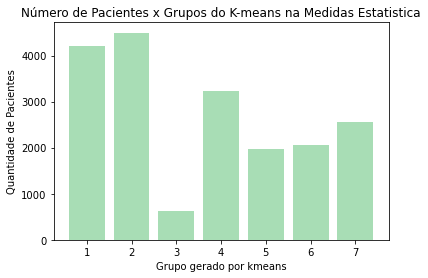

In [75]:
grupos = grupos_estatistica_funcao
abordagem = 'Medidas Estatistica'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_estatistica= grafico_barras_grupos(grupos,abordagem,caminho)

##   Abordagem 3: Método Elbow 

###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

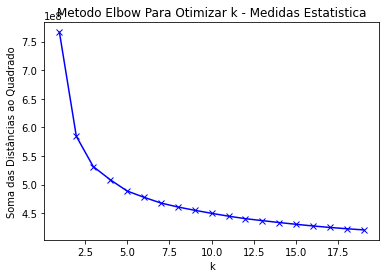

Tempo de execucao: 36.56 s




In [76]:
grupos = grupos_estatistica_funcao
abordagem = 'Medidas Estatistica'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_estatistica_sem_id,abordagem,caminho)

## Abordagem 3: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.38531816167018323
Para n_clusters = 3 O score_silhouette medio e : 0.32632664479746143
Para n_clusters = 4 O score_silhouette medio e : 0.3508918454156399
Para n_clusters = 5 O score_silhouette medio e : 0.3264978747883174
Para n_clusters = 6 O score_silhouette medio e : 0.32612186855231856
Para n_clusters = 7 O score_silhouette medio e : 0.3192453775722989


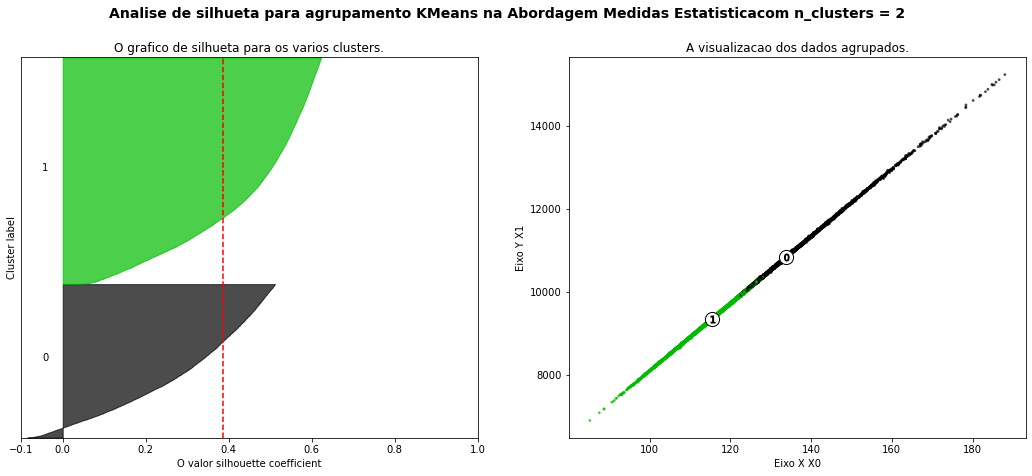

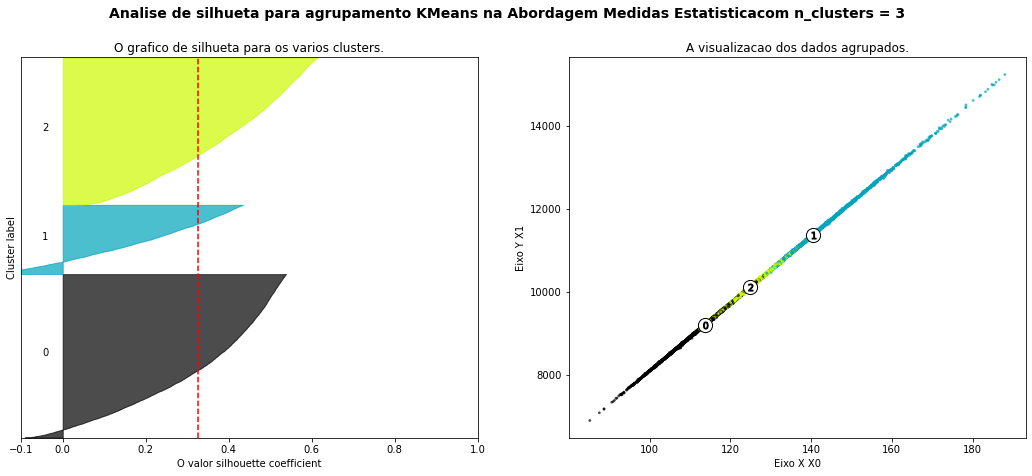

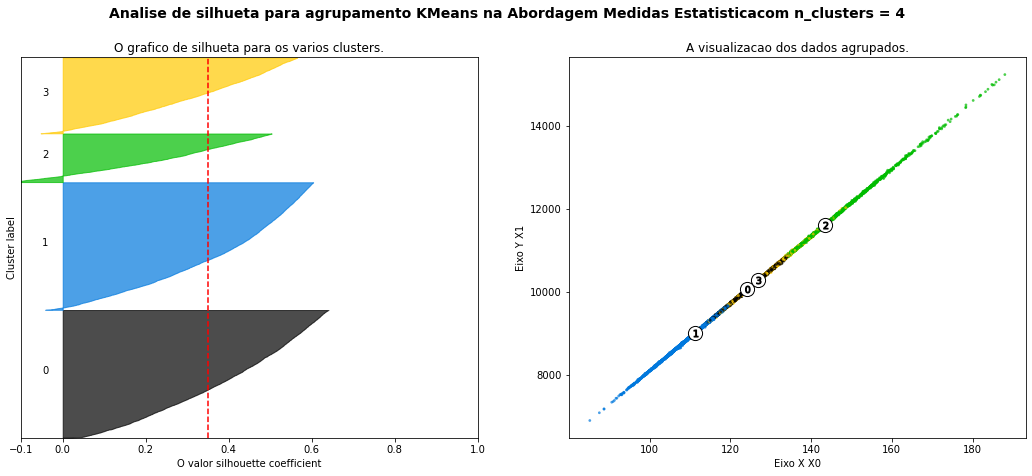

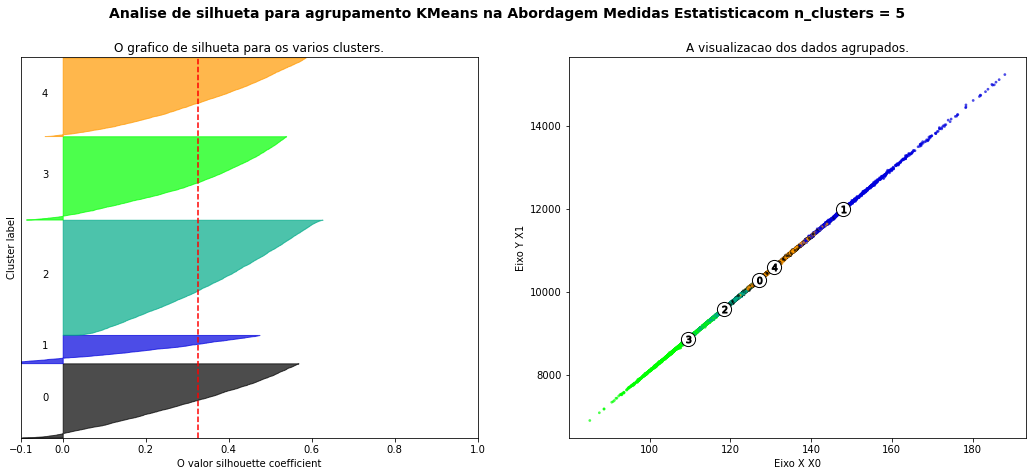

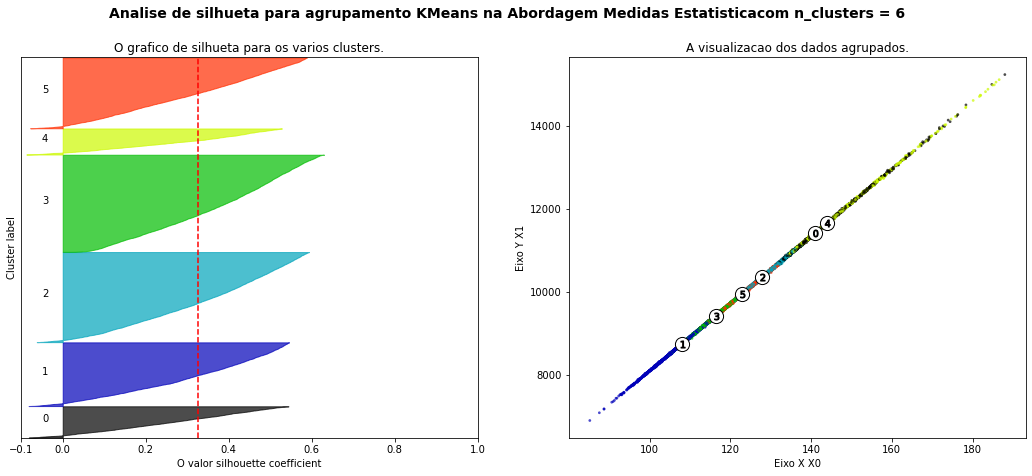

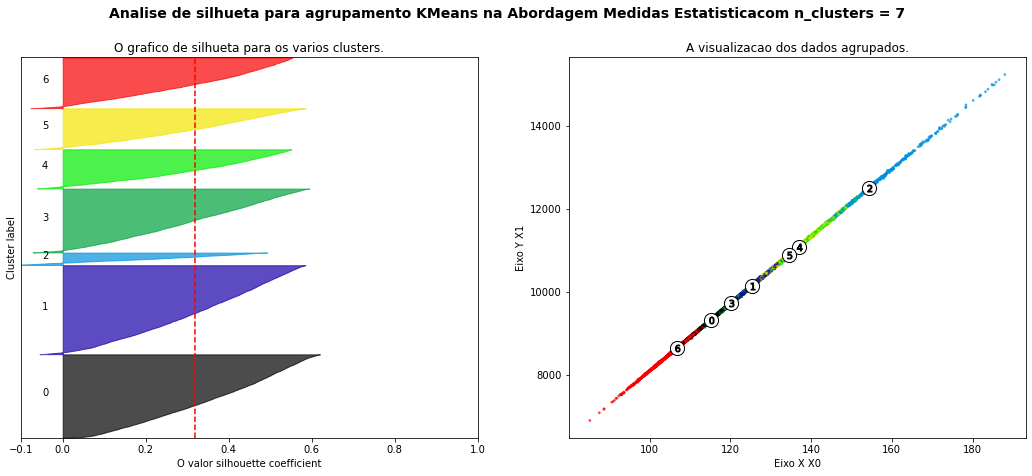

Tempo de execucao: 48.131 s




In [77]:
grupos = grupos_estatistica_funcao
abordagem = 'Medidas Estatistica'
aplica_silhouette(dados_estatistica_sem_id,grupos,abordagem)

### Abordagem 3: Random Forest

In [78]:
grupos = grupos_estatistica_funcao
abordagem = 'Medidas Estatistica'
importancia_estatistica = aplica_random_forest(dados_estatistica_sem_id,grupos,abordagem,classes_estatistica)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2    3     4     5     6     7
1  2503     1    0     0     0     0     0
2     0  2688    0     0     0     0     0
3     0     0  371     0     0     0     0
4     0     0    0  1967     0     0     0
5     0     0    0     0  1222     0     0
6     0     0    0     0     0  1224     0
7     0     0    0     0     0     0  1514


=================Teste==============


Accuracy: 0.99 - Recall: 0.99 - F1 Score: 0.99


      1     2    3     4    5    6     7
1  1693     7    0     2    0    0     2
2     8  1790    0     0    5    4     0
3     0     0  256     0    1    0     0
4     4     2    0  1242    0    7     2
5     0     5    5     0  743    1     0
6     0     1    2     3    4  827     0
7     1     0    0     5    0    0  1038


=================Importancia==============


                 features  importance
0  Media Sistolica em 24h       0.291
2   AUC Diastolica em

In [79]:
dados_completos_estatistica = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_estatistica_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_estatistica,'estatistica')

# Abordagem 4: Padrão de Doenças

In [80]:
#selecionando padrões de doencas

ls_padroes_doencas = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas =  dataset_apos_tratamento[ls_padroes_doencas]

In [81]:
#tratar nulos
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)


In [82]:
#trocar nulos do dataframe
d_p_d = dados_padrao_doencas

In [83]:
##############################################################################################################
#Trocar True e False para 1 e 0
#d_p_d['Hipotensao'] = d_p_d['Hipotensao'].apply(verdadeiro_falso)
#d_p_d['Sistolica Isolada'] = d_p_d['Sistolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Diastolica Isolada'] = d_p_d['Diastolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Dipping'] = d_p_d['Dipping'].apply(verdadeiro_falso)
#d_p_d['Non Dipping'] = d_p_d['Non Dipping'].apply(verdadeiro_falso)
#d_p_d['Extreme Dipping'] = d_p_d['Extreme Dipping'].apply(verdadeiro_falso)
#d_p_d['Reverse Dipping'] = d_p_d['Reverse Dipping'].apply(verdadeiro_falso)
#d_p_d['Morning Surge'] = d_p_d['Morning Surge'].apply(verdadeiro_falso)
#d_p_d['Masked'] = d_p_d['Masked'].apply(verdadeiro_falso)
#d_p_d['Whitecoat'] = d_p_d['Whitecoat'].apply(verdadeiro_falso)
#d_p_d['Normotenso'] = d_p_d['Normotenso'].apply(verdadeiro_falso)

##  Abordagem 4: Número de Clusters gerado pelo k-Means

In [84]:
dados_padrao_doencas_sem_id = dados_padrao_doencas
grupos_padrao_doencas_funcao = aplica_kmeans(dados_padrao_doencas_sem_id, 'Padrao Doencas')
print(grupos_padrao_doencas_funcao)



Numero otimo de cluster - Abordagem Padrao Doencas: 7


Tempo de execucao: 4.937 s


[4 4 3 ... 3 5 4]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


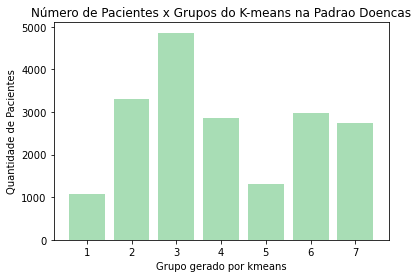

In [85]:
grupos = grupos_padrao_doencas_funcao
abordagem = 'Padrao Doencas'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_padrao_doencas= grafico_barras_grupos(grupos,abordagem,caminho)

##   Abordagem 4: Método Elbow 

###  Método de cálculo do melhor número de cluster para o algoritmo e plota o gráfico

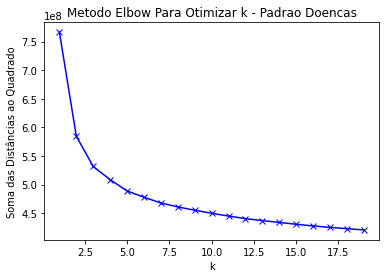

Tempo de execucao: 38.563 s




In [86]:
grupos = grupos_padrao_doencas_funcao
abordagem = 'Padrao Doencas'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_padrao_doencas_sem_id,abordagem,caminho)

## Abordagem 4: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.417066442958284
Para n_clusters = 3 O score_silhouette medio e : 0.5265157717211699
Para n_clusters = 4 O score_silhouette medio e : 0.5543011376775195
Para n_clusters = 5 O score_silhouette medio e : 0.6556366154598832
Para n_clusters = 6 O score_silhouette medio e : 0.6951612758577148
Para n_clusters = 7 O score_silhouette medio e : 0.7595153244566767


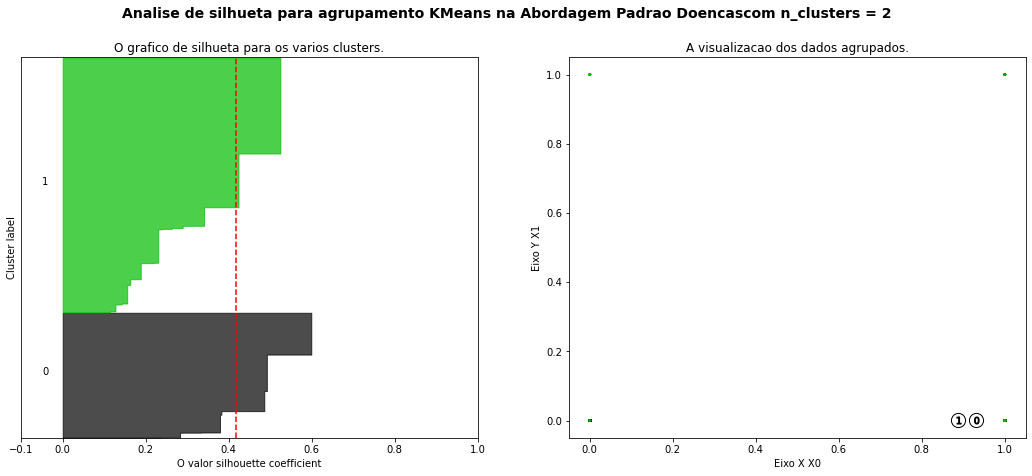

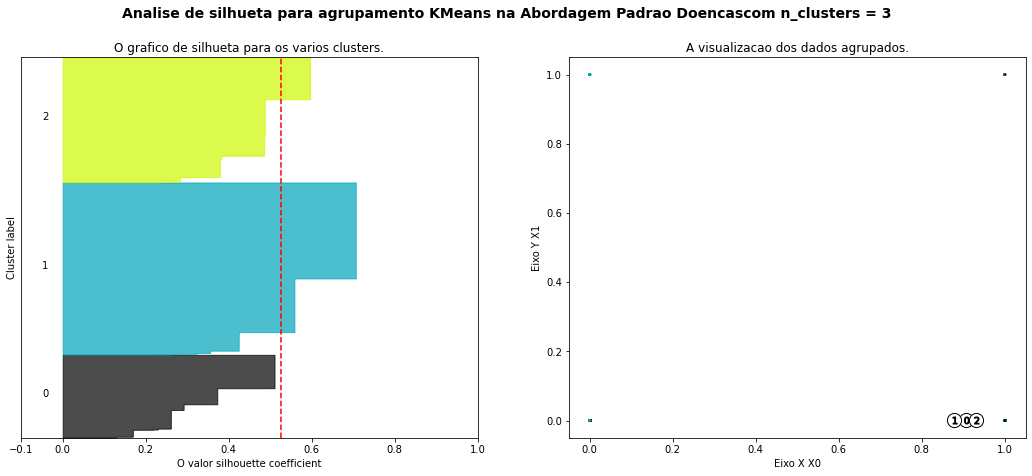

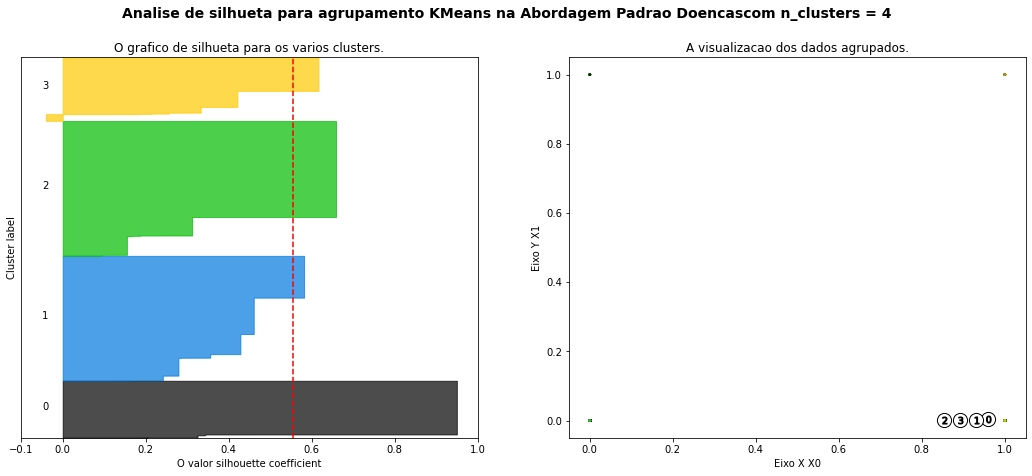

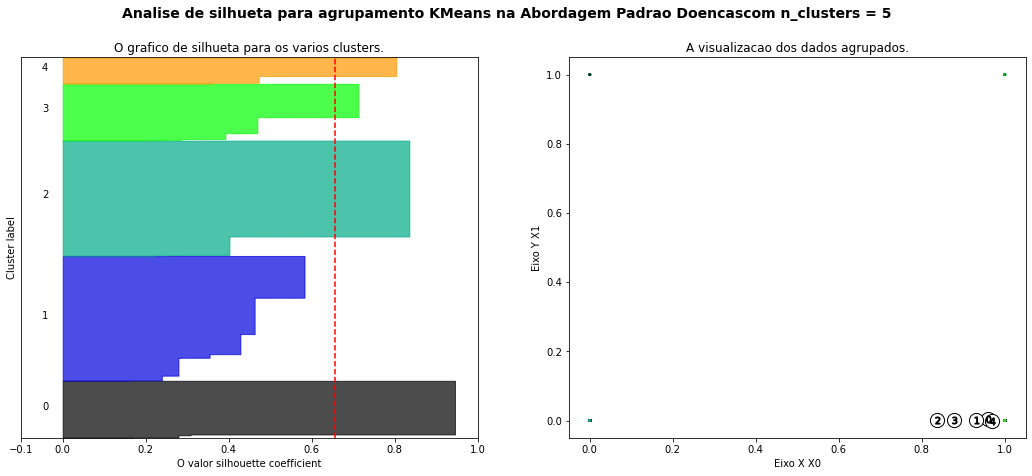

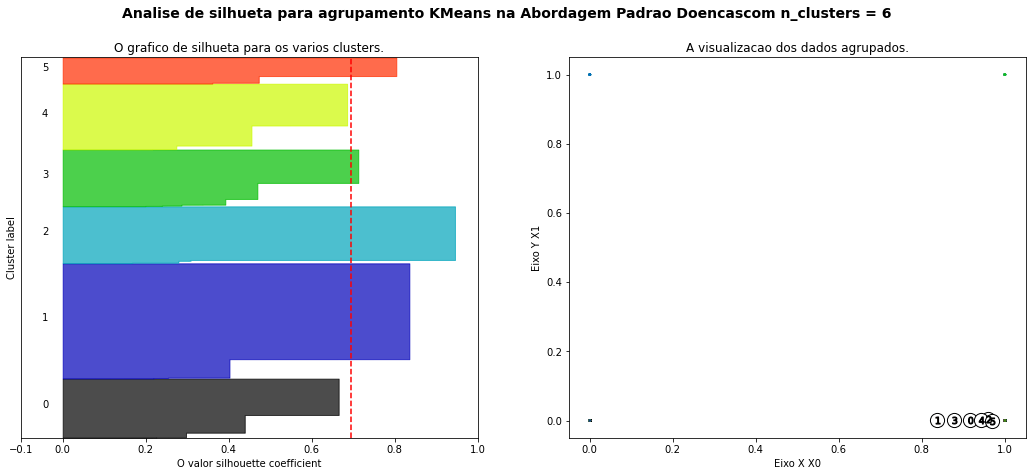

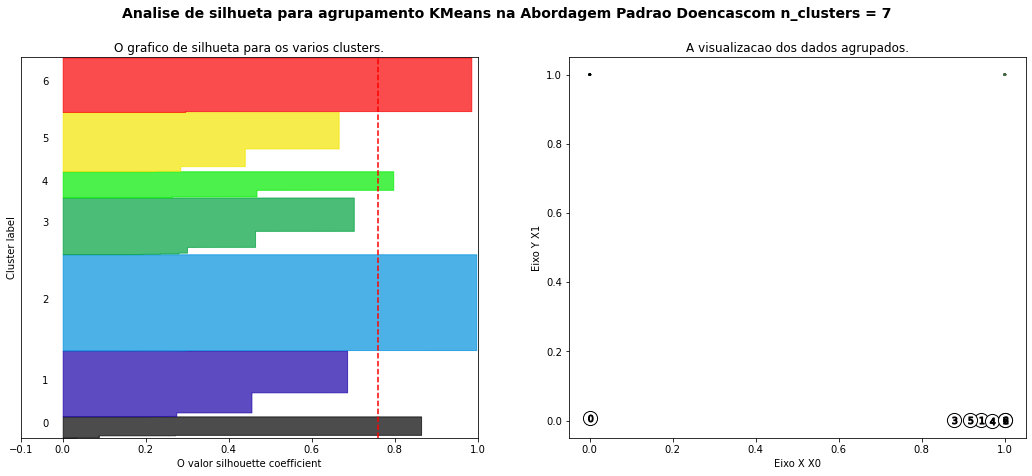

Tempo de execucao: 48.034 s




In [87]:
grupos = grupos_padrao_doencas_funcao
abordagem = 'Padrao Doencas'
aplica_silhouette(dados_padrao_doencas_sem_id,grupos,abordagem)

In [88]:
grupos = grupos_padrao_doencas_funcao
abordagem = 'Padrao Doencas'
importancia_padrao_doencas = aplica_random_forest(dados_padrao_doencas_sem_id,grupos,abordagem,classes_padrao_doencas)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


     1     2     3     4    5     6     7
1  672     0     0     0    0     0     0
2    0  2015     0     0    0     0     0
3    0     0  2905     0    0     0     0
4    0     0     0  1694    0     0     0
5    0     0     0     0  772     0     0
6    0     0     0     0    0  1807     0
7    0     0     0     0    0     0  1625


=================Teste==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


     1     2     3     4    5     6     7
1  401     0     0     0    0     0     0
2    0  1299     0     0    0     0     0
3    0     0  1953     0    0     0     0
4    0     0     0  1165    0     0     0
5    0     0     0     0  544     0     0
6    0     0     0     0    0  1172     0
7    0     0     0     0    0     0  1126


=================Importancia==============


              features  importance
7        Morning Surge       0.202
9            Whitecoat     

In [89]:
dados_completos_padrao_doencas = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_padrao_doencas_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_padrao_doencas,'doenca')

# Abordagem 4.1: Features Selection: Kbest  na Abordagem 4: Doenças

In [90]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

features_mais_importante_ml = SelectKBest(chi2, k=5).fit_transform(dados_padrao_doencas_sem_id, grupos_padrao_doencas_funcao)
features_mais_importante_ml.shape

(19150, 5)

In [91]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

features_mais_importante = pd.DataFrame(features_mais_importante_ml)

In [92]:
# identificação de quais colunas foram escolhidas

lista_colunas_escolhidas = []
# X é o dataset das doenças que precisa ser transformado em df
x_df = pd.DataFrame(dados_padrao_doencas_sem_id)
for coluna_ml in range(len(features_mais_importante.columns)):
    for coluna_base in x_df.columns:
        # para identificar valores únicos
        if set(np.array(x_df[coluna_base]) == np.array(features_mais_importante[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

# Foram escolhidas as colunas 'Diastolica Isolada', 'Dipping','Non Dipping', 'Extreme Dipping', 'Reverse Dipping'

['Dipping',
 'Non Dipping',
 'Extreme Dipping',
 'Reverse Dipping',
 'Morning Surge']

In [93]:
#selecionando padrões de doencas

#ls_doencas_kbest = ['Diastolica Isolada', 'Dipping',
#       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping']

#ls_doencas_kbest = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
#       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
#       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas_kbest =  dataset_apos_tratamento[lista_colunas_escolhidas]

## Abordagem 4.1:  K-means para SelectKbest

In [94]:
dados_padrao_doencas_kbest_sem_id = dados_padrao_doencas_kbest
grupos_padrao_doencas_kbest_funcao = aplica_kmeans(dados_padrao_doencas_sem_id, 'Padrao Doencas Kbest')
print(grupos_padrao_doencas_kbest_funcao)



Numero otimo de cluster - Abordagem Padrao Doencas Kbest: 7


Tempo de execucao: 5.014 s


[4 4 3 ... 3 5 4]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


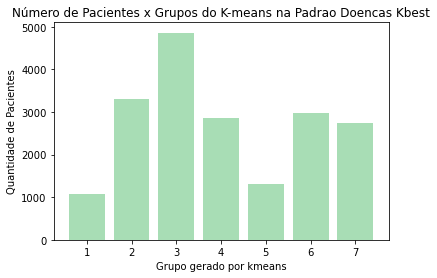

In [95]:
grupos = grupos_padrao_doencas_kbest_funcao
abordagem = 'Padrao Doencas Kbest'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_padrao_doencas_kbest = grafico_barras_grupos(grupos,abordagem,caminho)

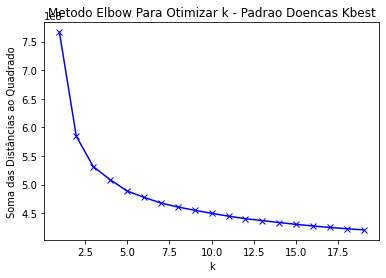

Tempo de execucao: 37.578 s




In [96]:
grupos = grupos_padrao_doencas_kbest_funcao
abordagem = 'Padrao Doencas Kbest'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_padrao_doencas_kbest_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.604080236187501
Para n_clusters = 3 O score_silhouette medio e : 0.775318701042156
Para n_clusters = 4 O score_silhouette medio e : 0.8946668686748049
Para n_clusters = 5 O score_silhouette medio e : 0.9998955613577023
Para n_clusters = 6 O score_silhouette medio e : 0.9999477806788512


C:\Users\marta\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:996: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Para n_clusters = 7 O score_silhouette medio e : 0.9999477806788512


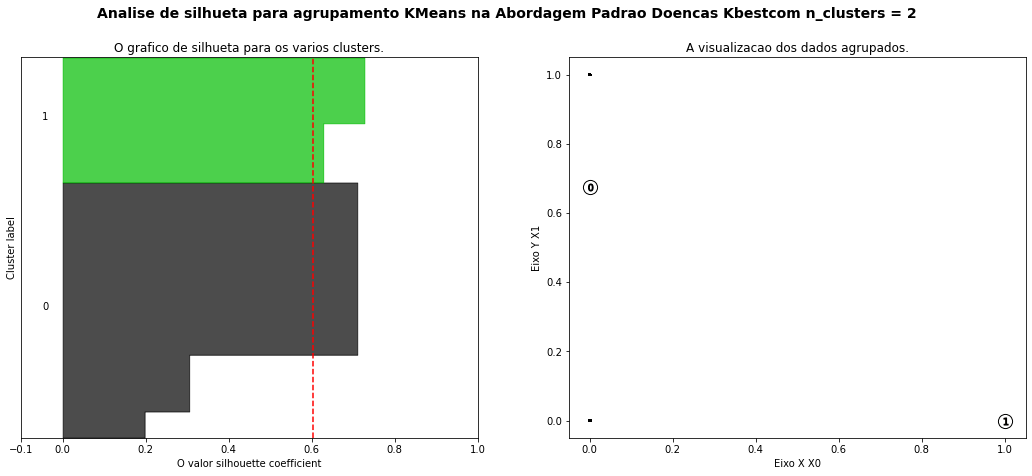

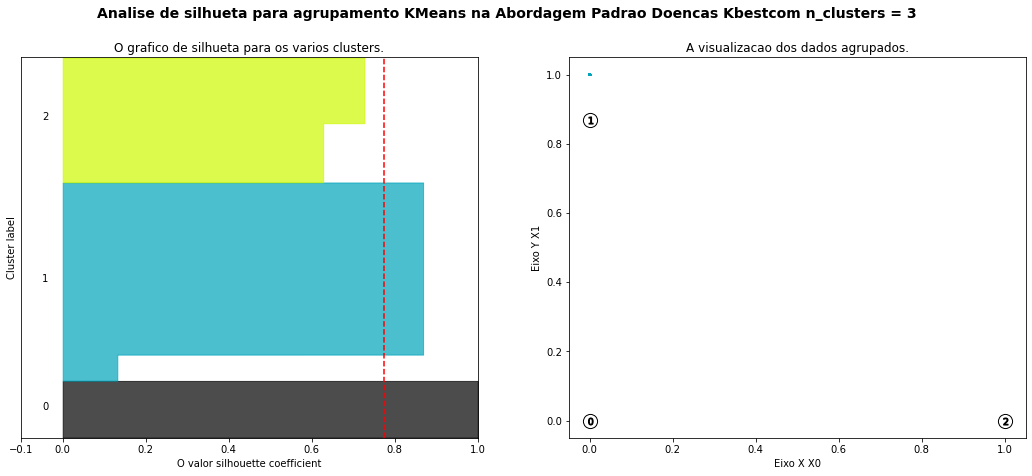

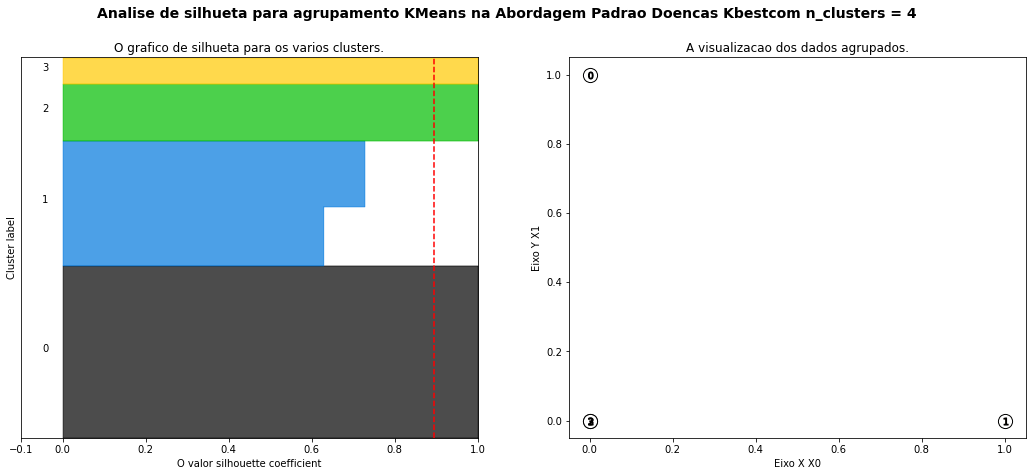

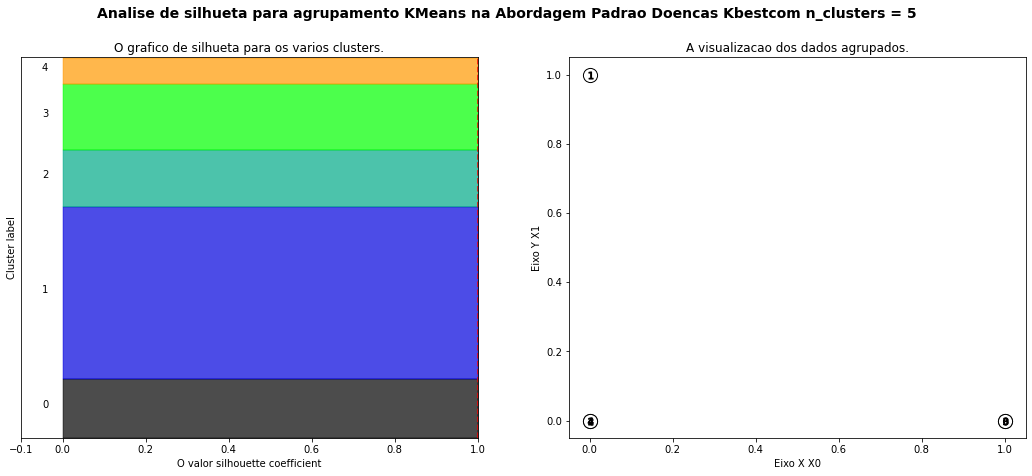

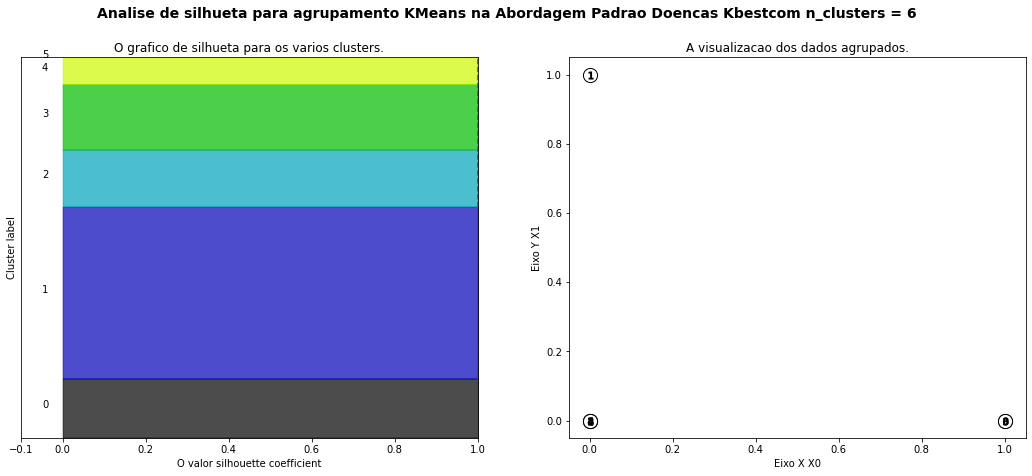

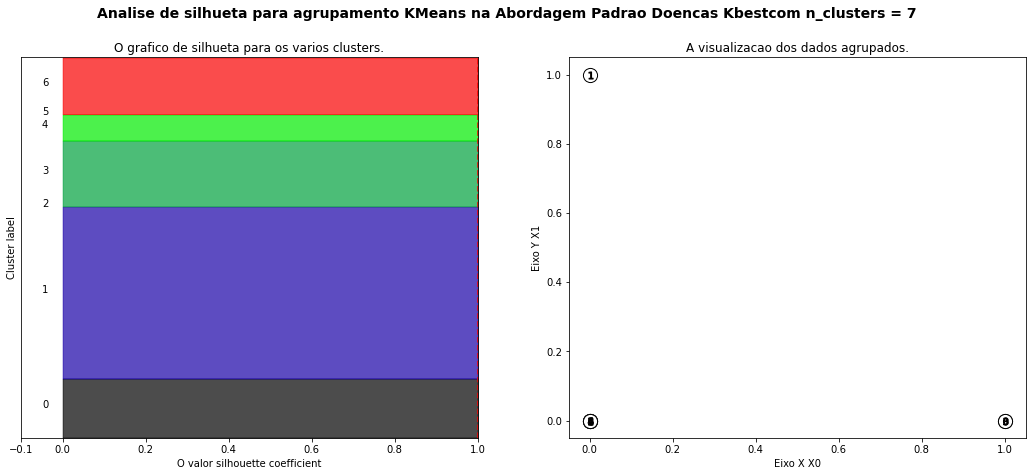

Tempo de execucao: 51.833 s




In [97]:
grupos = grupos_padrao_doencas_kbest_funcao
abordagem = 'Padrao Doencas Kbest'
aplica_silhouette(dados_padrao_doencas_kbest_sem_id,grupos,abordagem)

###  Abordagem 4.1: Random Forest

In [98]:
grupos = grupos_padrao_doencas_kbest_funcao
abordagem = 'Padrao Doencas Kbest'
importancia_padrao_doencas_kbest = aplica_random_forest(dados_padrao_doencas_kbest_sem_id,grupos,abordagem,classes_padrao_doencas_kbest)



=================Validação==============


Accuracy: 0.80 - Recall: 0.71 - F1 Score: 0.67


   1     2     3     4    5     6  7
1  0     0   672     0    0     0  0
2  0  2015     0     0    0     0  0
3  0     0  2905     0    0     0  0
4  0     0     0  1694    0     0  0
5  0     0     0     0  772     0  0
6  0     0     0     0    0  1807  0
7  0     0  1625     0    0     0  0


=================Teste==============


Accuracy: 0.80 - Recall: 0.71 - F1 Score: 0.67


   1     2     3     4    5     6  7
1  0     0   401     0    0     0  0
2  0  1299     0     0    0     0  0
3  0     0  1953     0    0     0  0
4  0     0     0  1165    0     0  0
5  0     0     0     0  544     0  0
6  0     0     0     0    0  1172  0
7  0     0  1126     0    0     0  0


=================Importancia==============


          features  importance
4    Morning Surge       0.296
1      Non Dipping       0.213
3  Reverse Dipping       0.202
0          Dipping       0.198
2  Extreme Dipping    

In [99]:
dados_completos_padrao_doencas_kbest = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_padrao_doencas_kbest_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_padrao_doencas_kbest,'doencas_kbest')

# Abordagem 5 doença sem extremos (Sem Hipotensão e sem Normotenso)

In [100]:
#   Doenças SEM Hipotensão

ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_doencas = ls_doencas[1:]

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
#  Usar esse comando para a abordagem em cada uma das doenças separadamente
#grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

#  Usar esse comando para a abordagem de um range de doenças. Aqui não entrou Hipotensão, nem Normotenso
doenca_sem_extremos = dataset_apos_tratamento[ls_doencas]

In [101]:
dados_doenca_sem_extremos_sem_id = doenca_sem_extremos
grupos_doenca_sem_extremos_funcao = aplica_kmeans(dados_doenca_sem_extremos_sem_id, 'Sem Extremos')
print(grupos_doenca_sem_extremos_funcao)



Numero otimo de cluster - Abordagem Sem Extremos: 8


Tempo de execucao: 4.951 s


[8 8 2 ... 2 7 4]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


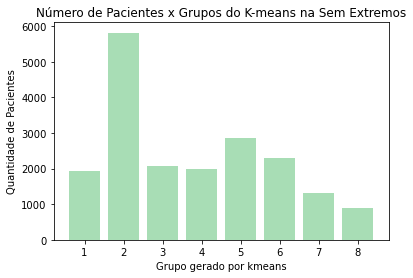

In [102]:
grupos = grupos_doenca_sem_extremos_funcao
abordagem = 'Sem Extremos'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_doenca_sem_extremos = grafico_barras_grupos(grupos,abordagem,caminho)

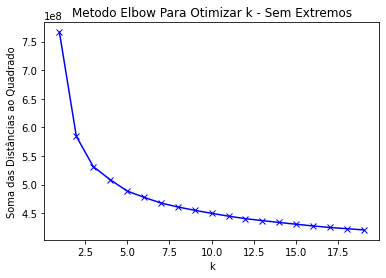

Tempo de execucao: 37.125 s




In [103]:
grupos = grupos_doenca_sem_extremos_funcao
abordagem = 'Sem Extremos'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_doenca_sem_extremos_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.45841810356414925
Para n_clusters = 3 O score_silhouette medio e : 0.585729988619511
Para n_clusters = 4 O score_silhouette medio e : 0.6528931540979196
Para n_clusters = 5 O score_silhouette medio e : 0.758677632509361
Para n_clusters = 6 O score_silhouette medio e : 0.8101202188867902
Para n_clusters = 7 O score_silhouette medio e : 0.8603793834669475
Para n_clusters = 8 O score_silhouette medio e : 0.9194765428468022


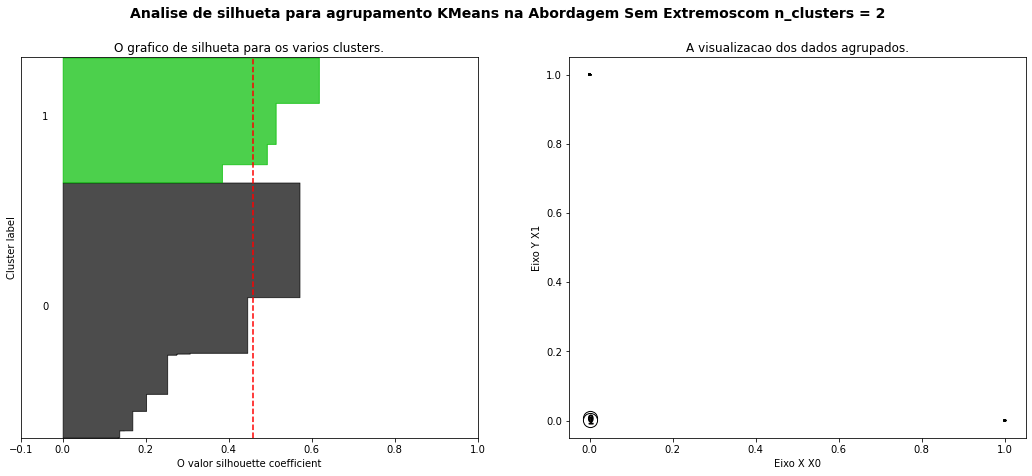

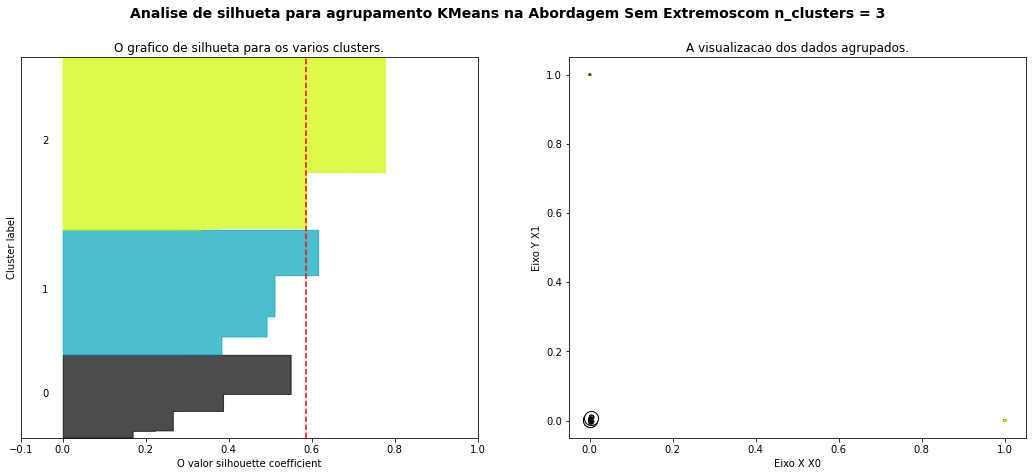

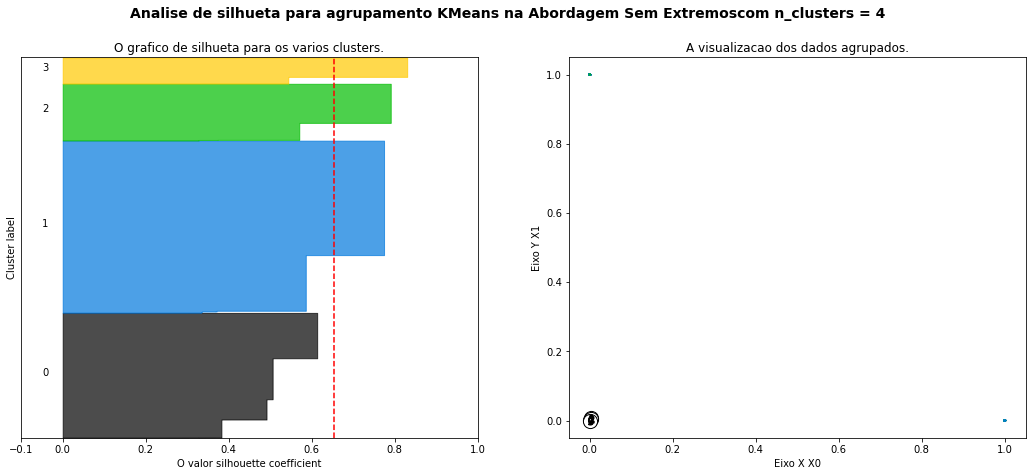

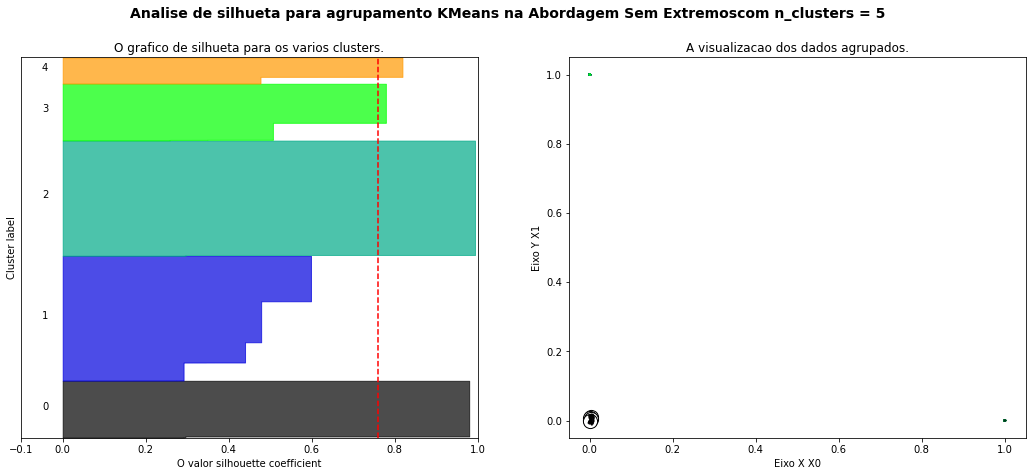

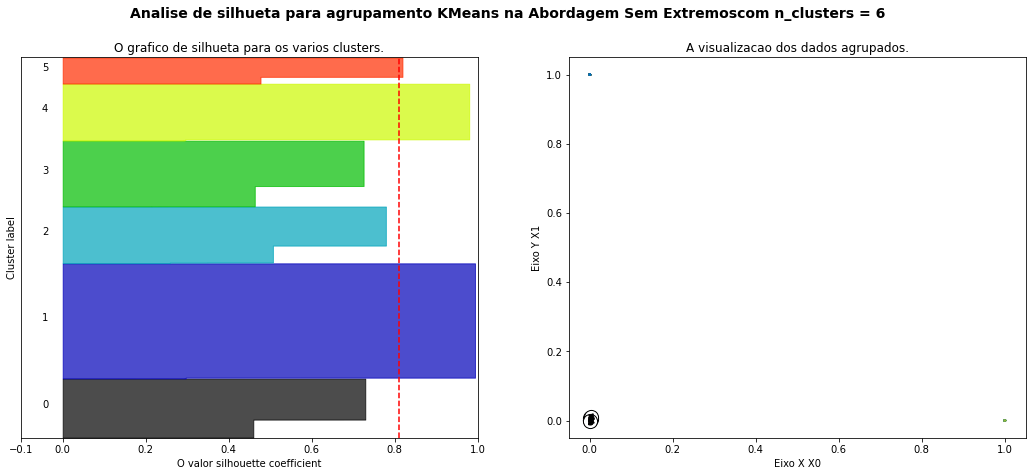

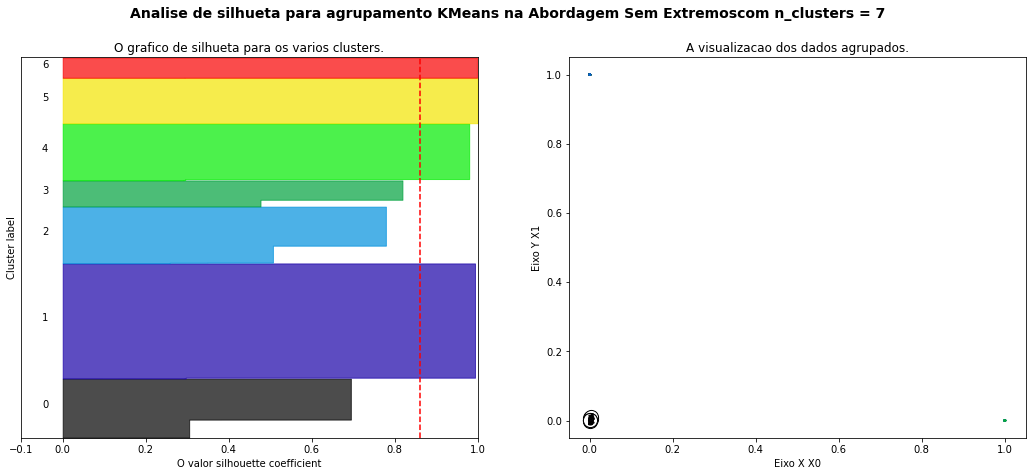

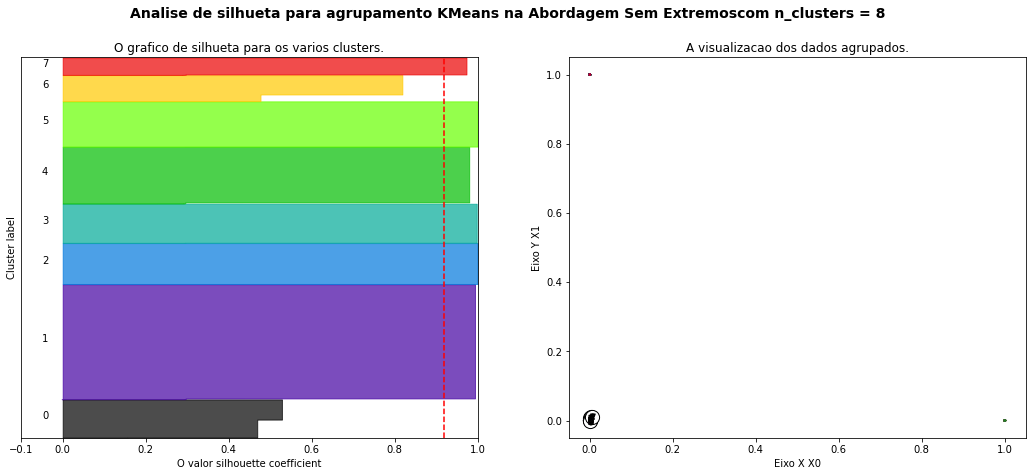

Tempo de execucao: 57.985 s




In [104]:
grupos = grupos_doenca_sem_extremos_funcao
abordagem = 'Sem Extremos'
aplica_silhouette(dados_doenca_sem_extremos_sem_id,grupos,abordagem)

In [105]:
grupos = grupos_doenca_sem_extremos_funcao
abordagem = 'Sem Extremos'
importancia_doenca_sem_extremos = aplica_random_forest(dados_doenca_sem_extremos_sem_id,grupos,abordagem,classes_doenca_sem_extremos)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3     4     5     6    7    8
1  1191     0     0     0     0     0    0    0
2     0  3508     0     0     0     0    0    0
3     0     0  1239     0     0     0    0    0
4     0     0     0  1155     0     0    0    0
5     0     0     0     0  1694     0    0    0
6     0     0     0     0     0  1392    0    0
7     0     0     0     0     0     0  772    0
8     0     0     0     0     0     0    0  539


=================Teste==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


     1     2    3    4     5    6    7    8
1  742     0    0    0     0    0    0    0
2    0  2306    0    0     0    0    0    0
3    0     0  831    0     0    0    0    0
4    0     0    0  823     0    0    0    0
5    0     0    0    0  1174    0    0    0
6    0     0    0    0     0  898    0    0
7    0     0    0    0     0    0  544    0
8    0     0    0    0     0    

In [106]:
dados_completos_doenca_sem_extremos = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_doenca_sem_extremos_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_doenca_sem_extremos,'doenca_sem_extremos')

# Abordagem 6: escolho doença

In [107]:
ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_medidas = list(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].columns)

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

#dados_medidas_novo = np.array(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'])
dados_medidas_novo = dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']

In [108]:
dados_escolho_doenca_sem_id = dados_medidas_novo
grupos_escolho_doenca_funcao =  np.array(dataset_apos_tratamento[ls_doencas[0]]) + 1
print(grupos_escolho_doenca_funcao)

[2 2 2 ... 2 2 2]


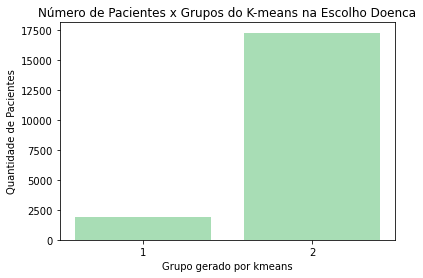

In [109]:
grupos = grupos_escolho_doenca_funcao
abordagem = 'Escolho Doenca'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_escolho_doenca = grafico_barras_grupos(grupos,abordagem,caminho)

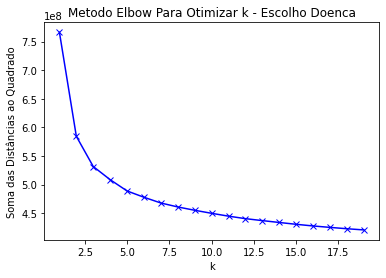

Tempo de execucao: 38.805 s




In [110]:
grupos = grupos_escolho_doenca_funcao
abordagem = 'Escolho Doenca'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_escolho_doenca_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.20556068194132648


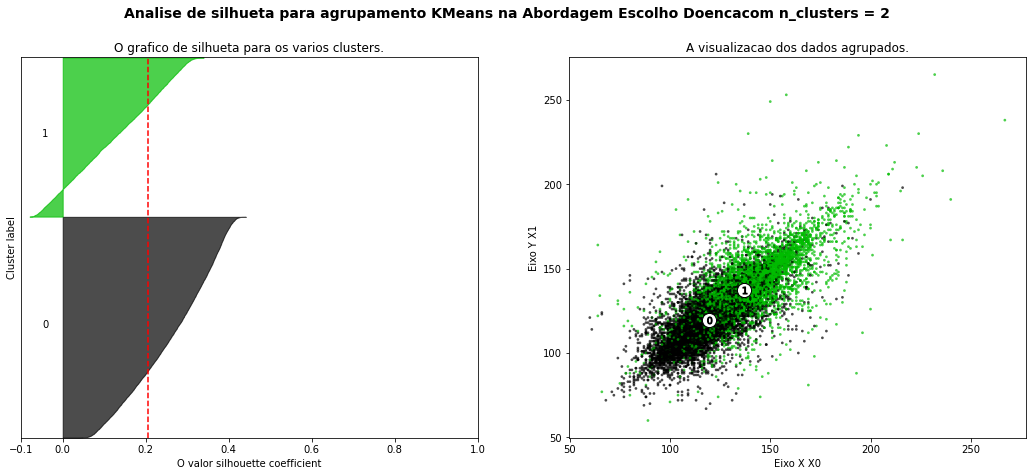

Tempo de execucao: 9.473 s




In [111]:
grupos = grupos_escolho_doenca_funcao
abordagem = 'Escolho Doenca'
aplica_silhouette(dados_escolho_doenca_sem_id,grupos,abordagem)

####  Abordagem 6: Importância das Features Random Forest

In [112]:
grupos = grupos_escolho_doenca_funcao
abordagem = 'Escolho Doenca'
importancia_escolho_doenca = aplica_random_forest(dados_escolho_doenca_sem_id,grupos,abordagem,classes_escolho_doenca)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1      2
1  1196      1
2     0  10293


=================Teste==============


Accuracy: 0.95 - Recall: 0.80 - F1 Score: 0.84


     1     2
1  434   266
2   83  6877


=================Importancia==============


       features  importance
149  diast 4:30       0.028
146  diast 3:00       0.020
144  diast 2:00       0.019
141  diast 0:30       0.018
147  diast 3:30       0.017
..          ...         ...
79    sist 8:15       0.004
12   sist 12:00       0.003
52   sist 22:00       0.003
69    sist 5:30       0.003
3     sist 9:45       0.003

[164 rows x 2 columns]


In [113]:
dados_completos_escolho_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_escolho_doenca_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)
gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

# Abordagem 7: por Categorias 

In [114]:
#convertendo os dados para entrega ao Random - Classifcação
ls_classes = list((dataset_por_classes.drop(list(dataset_por_classes.loc[:,'sist 9:00':'diast 8:45'].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

dados_categorias = dataset_por_classes[ls_classes]

In [115]:
dados_categorias_sem_id = dados_categorias
grupos_categorias_funcao = aplica_kmeans(dados_categorias_sem_id, 'Categorias')
print(grupos_categorias_funcao)



Numero otimo de cluster - Abordagem Categorias: 7


Tempo de execucao: 5.945 s


[4 4 5 ... 5 1 5]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


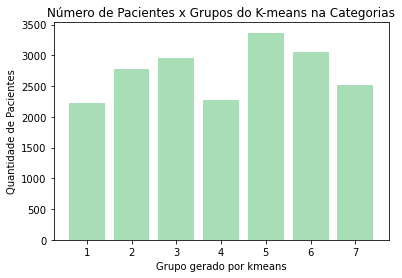

In [116]:
grupos = grupos_categorias_funcao
abordagem = 'Categorias'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_categorias = grafico_barras_grupos(grupos,abordagem,caminho)

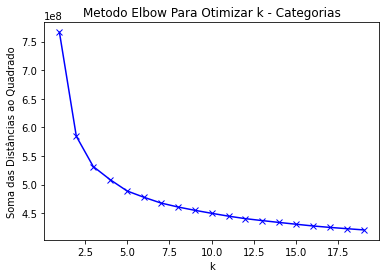

Tempo de execucao: 39.118 s




In [117]:
grupos = grupos_categorias_funcao
abordagem = 'Categorias'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_categorias_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.1979378859445441
Para n_clusters = 3 O score_silhouette medio e : 0.19540640789400573
Para n_clusters = 4 O score_silhouette medio e : 0.18801902139699217
Para n_clusters = 5 O score_silhouette medio e : 0.18494816552382828
Para n_clusters = 6 O score_silhouette medio e : 0.18847826776858742
Para n_clusters = 7 O score_silhouette medio e : 0.2062621943175537


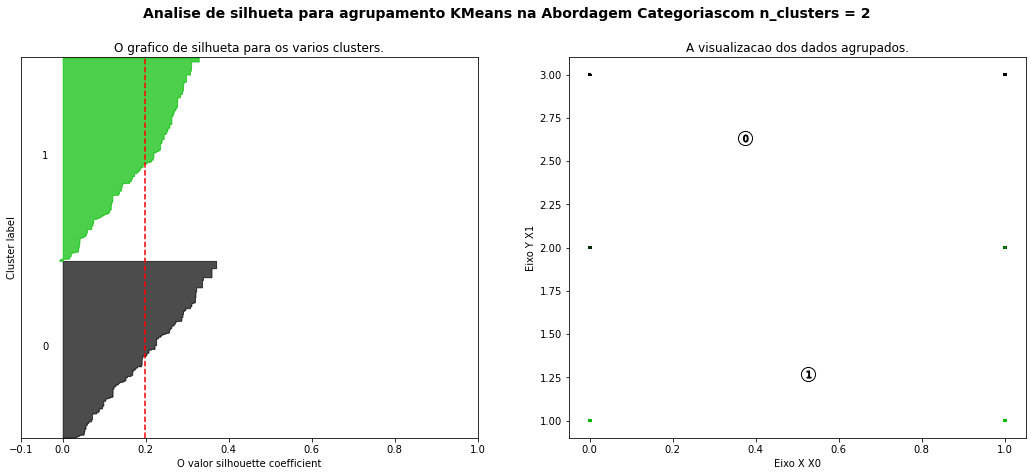

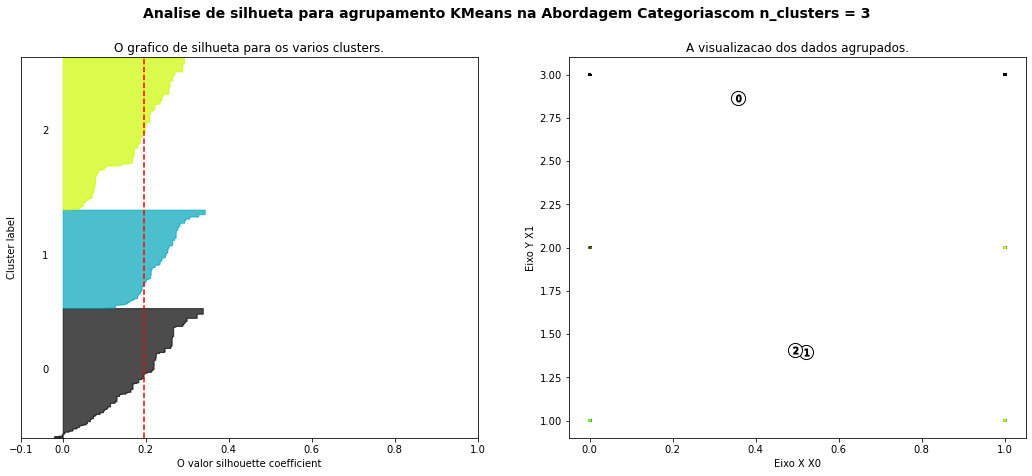

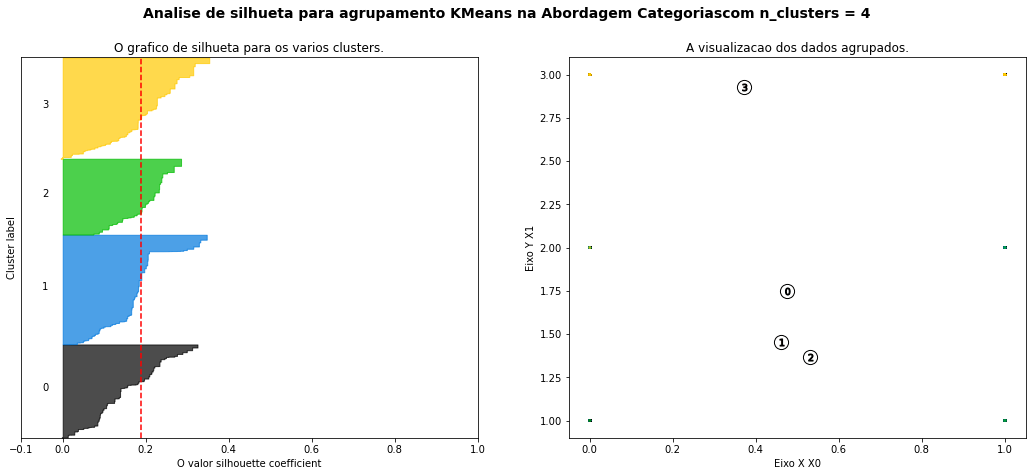

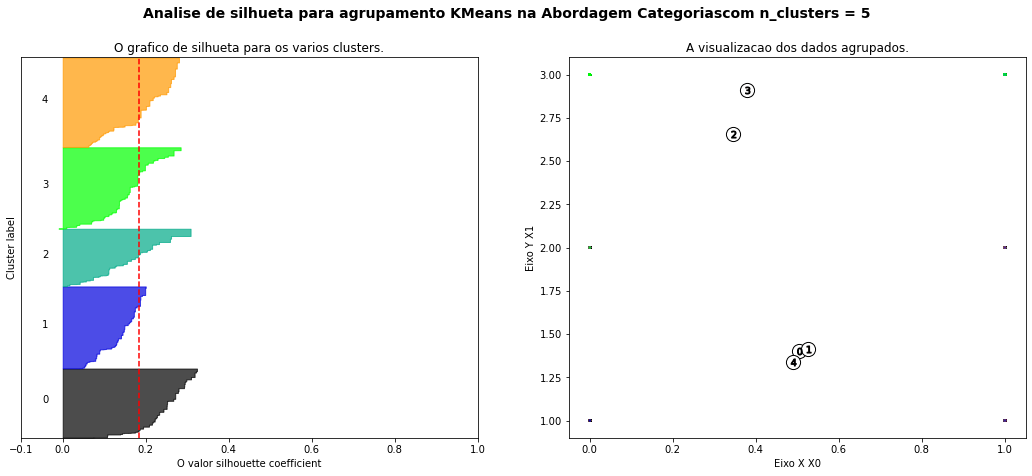

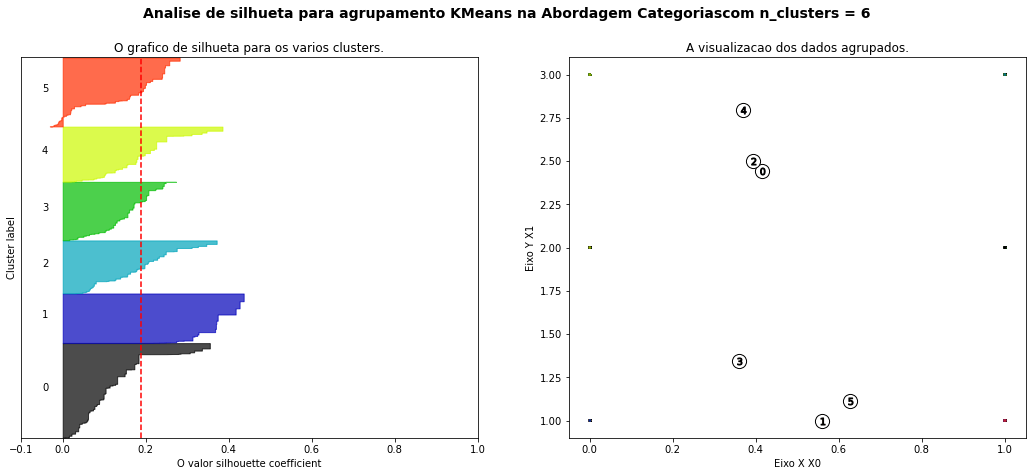

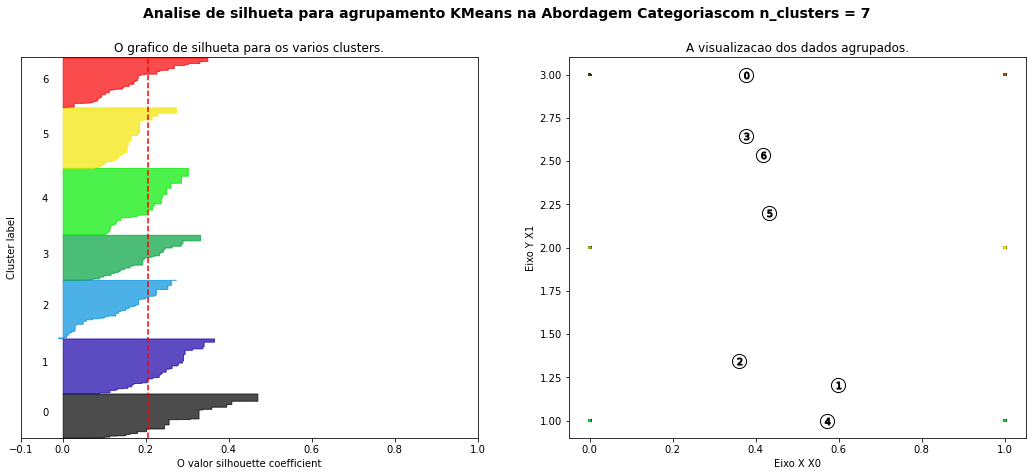

Tempo de execucao: 49.015 s




In [118]:
grupos = grupos_categorias_funcao
abordagem = 'Categorias'
aplica_silhouette(dados_categorias_sem_id,grupos,abordagem)

In [119]:
grupos = grupos_categorias_funcao
abordagem = 'Categorias'
importancia_categorias = aplica_random_forest(dados_categorias_sem_id,grupos,abordagem,classes_categorias)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3     4     5     6     7
1  1299     0     0     0     0     0     0
2     0  1686     0     0     0     0     0
3     0     0  1775     0     0     0     0
4     0     0     0  1342     0     0     0
5     0     0     0     0  2007     0     0
6     0     0     0     0     0  1862     0
7     0     0     0     0     0     0  1519


=================Teste==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


     1     2     3    4     5     6    7
1  931     0     0    0     0     0    0
2    0  1086     0    0     0     0    0
3    0     0  1173    0     0     0    0
4    0     0     0  928     0     0    0
5    0     0     0    0  1360     0    0
6    0     0     0    0     0  1192    0
7    0     0     0    0     0     0  990


=================Importancia==============


              features  importance
1                idade       0.405
2                  

In [120]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_cadastro_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)
gera_arquivos_por_grupo(dados_completos_cadastro,'classes')

# Abordagem 8: Extratificação do Sexo Masculino

In [121]:
#   Gera uma lista com cabeçalhos
dados_masc = dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45']

## Abordagem 8: Número de Clusters gerado pelo k-Means

In [122]:
dados_masc_sem_id = dados_masc
grupos_masc_funcao = aplica_kmeans(dados_masc_sem_id, 'Masc')
print(grupos_masc_funcao)



Numero otimo de cluster - Abordagem Masc: 6


Tempo de execucao: 17.369 s


[6 6 3 ... 1 5 4]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


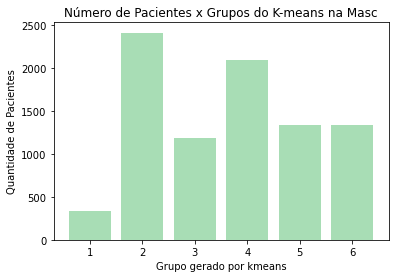

In [123]:
grupos = grupos_masc_funcao
abordagem = 'Masc'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_masc = grafico_barras_grupos(grupos,abordagem,caminho)

##  Abordagem 8: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

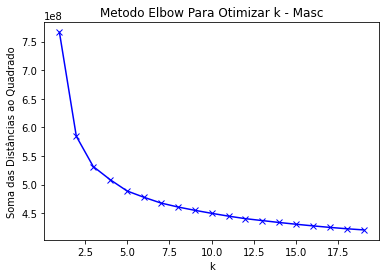

Tempo de execucao: 38.362 s




In [124]:
grupos = grupos_masc_funcao
abordagem = 'Masc'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_masc_sem_id,abordagem,caminho)

## Abordagem 8: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.19919974387375425
Para n_clusters = 3 O score_silhouette medio e : 0.12668027025138778
Para n_clusters = 4 O score_silhouette medio e : 0.08219662847088442
Para n_clusters = 5 O score_silhouette medio e : 0.07605401547732385
Para n_clusters = 6 O score_silhouette medio e : 0.061041853947687914


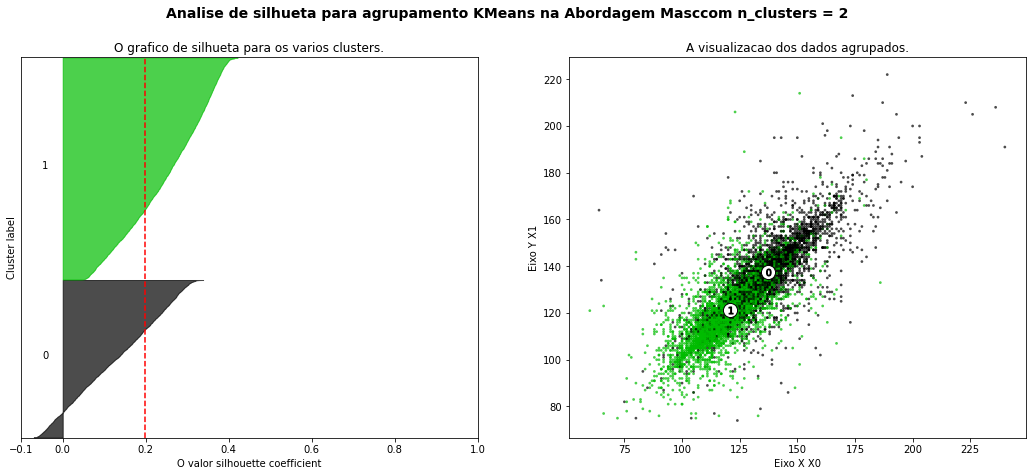

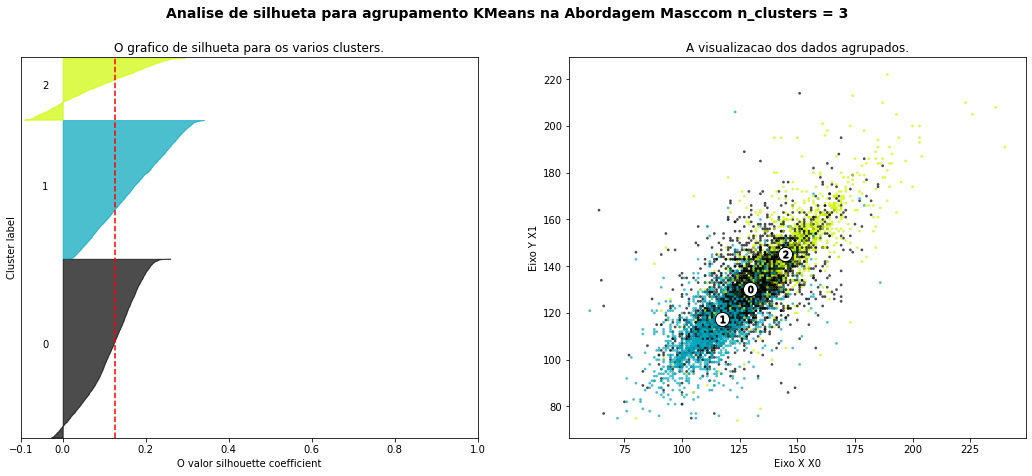

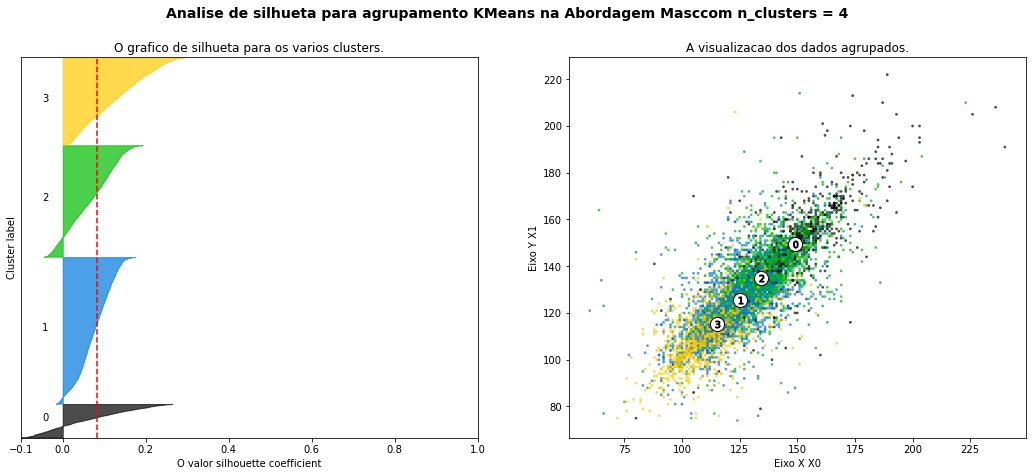

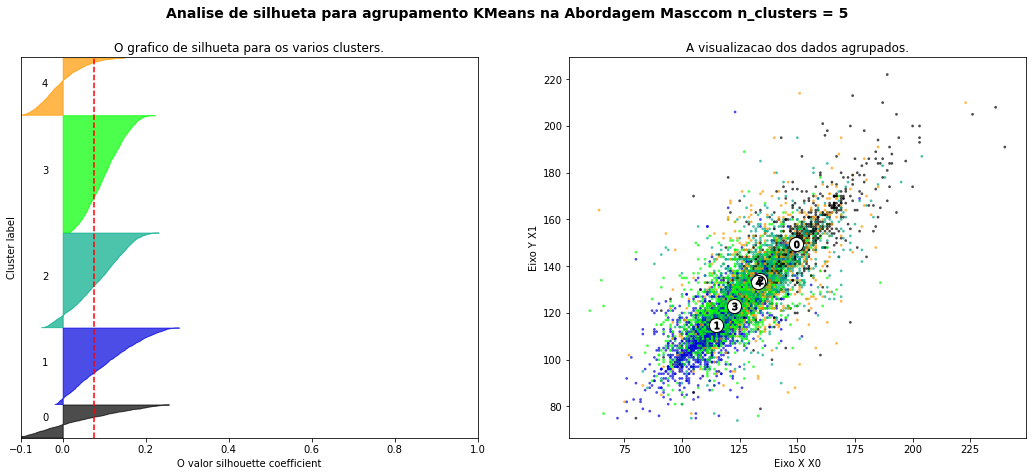

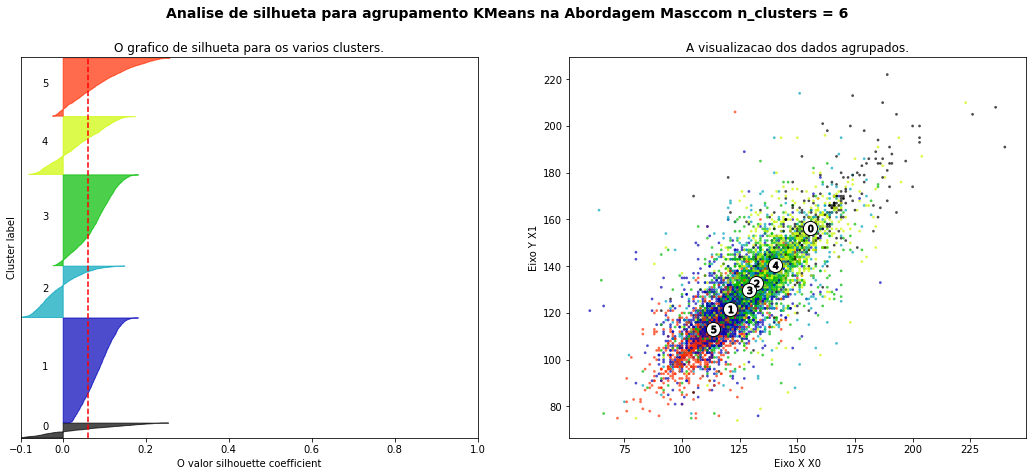

Tempo de execucao: 17.145 s




In [125]:
grupos = grupos_masc_funcao
abordagem = 'Masc'
aplica_silhouette(dados_masc_sem_id,grupos,abordagem)

### Não existe um valor de k clusters que não esteja se intersectando¶

### Abordagem 8: Random Forest

In [126]:
grupos = grupos_masc_funcao
abordagem = 'Masc'
importancia_masc = aplica_random_forest(dados_masc_sem_id,grupos,abordagem,classes_masc)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


     1     2    3     4    5    6
1  205     0    0     0    0    0
2    0  1445    0     0    0    0
3    0     0  710     0    0    0
4    0     0    0  1256    0    0
5    0     0    0     0  790    0
6    0     0    0     0    0  816


=================Teste==============


Accuracy: 0.91 - Recall: 0.89 - F1 Score: 0.91


     1    2    3    4    5    6
1  108    0    1    0   27    0
2    0  930    7   25    0    7
3    0   43  403   24    3    3
4    0   38    6  785    9    0
5    1    0   13   46  484    0
6    0   44    0    0    0  475


=================Importancia==============


        features  importance
46    sist 20:30       0.013
71     sist 6:15       0.013
48    sist 21:00       0.013
35    sist 17:45       0.013
91   diast 11:15       0.013
..           ...         ...
139  diast 23:30       0.003
138  diast 23:00       0.003
152   diast 6:00       0.002
141   diast 0:30 

In [127]:
dados_masc = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 1].copy().reset_index().drop('index',axis=1)
dados_completos_masc = pd.concat([dados_masc.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_masc_funcao}),
                                    dados_masc.loc[:,'sist 9:00':]],
                                   axis=1)
gera_arquivos_por_grupo(dados_completos_masc,'medidas_masc')

# Abordagem 9: Extratificação do Sexo Feminino

In [128]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45
dados_fem = dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45']

## Abordagem 9: Número de Clusters gerado pelo k-Means

In [129]:
dados_fem_sem_id = dados_fem
grupos_fem_funcao = aplica_kmeans(dados_fem_sem_id, 'Fem')
print(grupos_fem_funcao)



Numero otimo de cluster - Abordagem Fem: 7


Tempo de execucao: 20.746 s


[3 5 7 ... 2 7 2]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


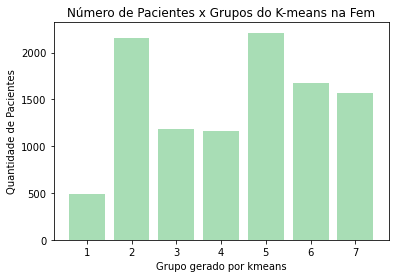

In [130]:
grupos = grupos_fem_funcao
abordagem = 'Fem'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_fem = grafico_barras_grupos(grupos,abordagem,caminho)

##  Abordagem 9: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

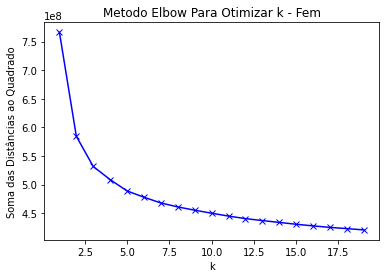

Tempo de execucao: 34.806 s




In [131]:
grupos = grupos_fem_funcao
abordagem = 'Fem'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_fem_sem_id,abordagem,caminho)

## Abordagem 9: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.21439208641481547
Para n_clusters = 3 O score_silhouette medio e : 0.1274214496775501
Para n_clusters = 4 O score_silhouette medio e : 0.11198954559856074
Para n_clusters = 5 O score_silhouette medio e : 0.07731284137453026
Para n_clusters = 6 O score_silhouette medio e : 0.07216562580670084
Para n_clusters = 7 O score_silhouette medio e : 0.05522985045587759


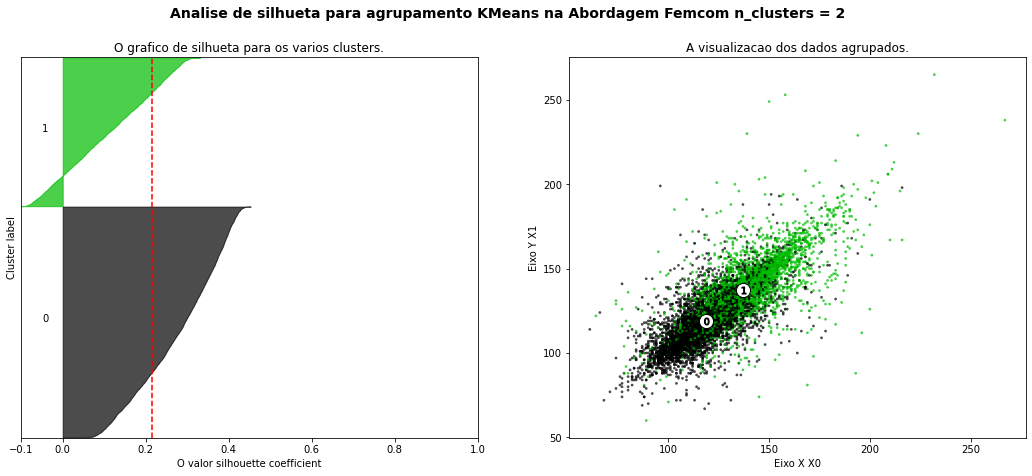

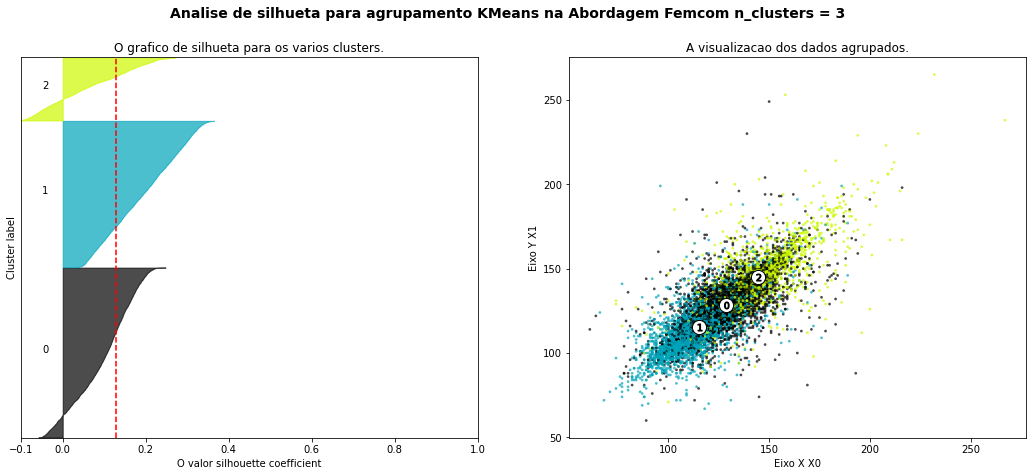

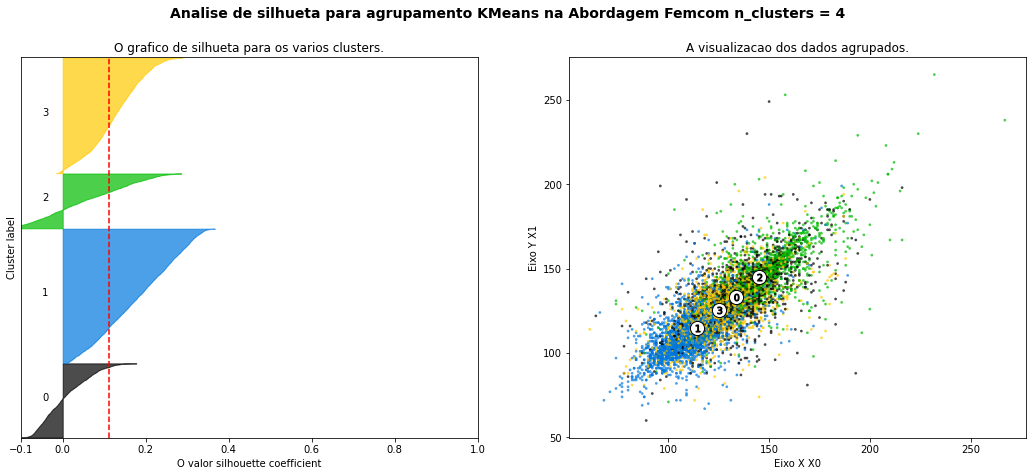

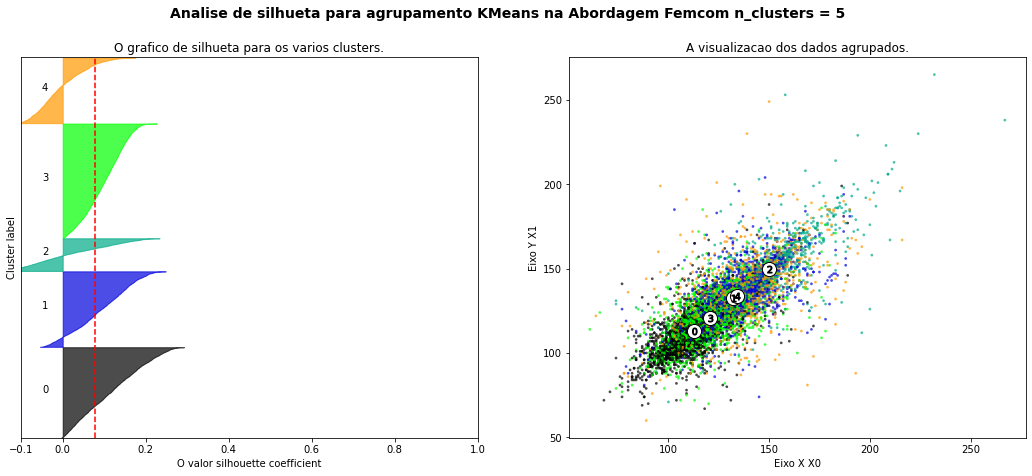

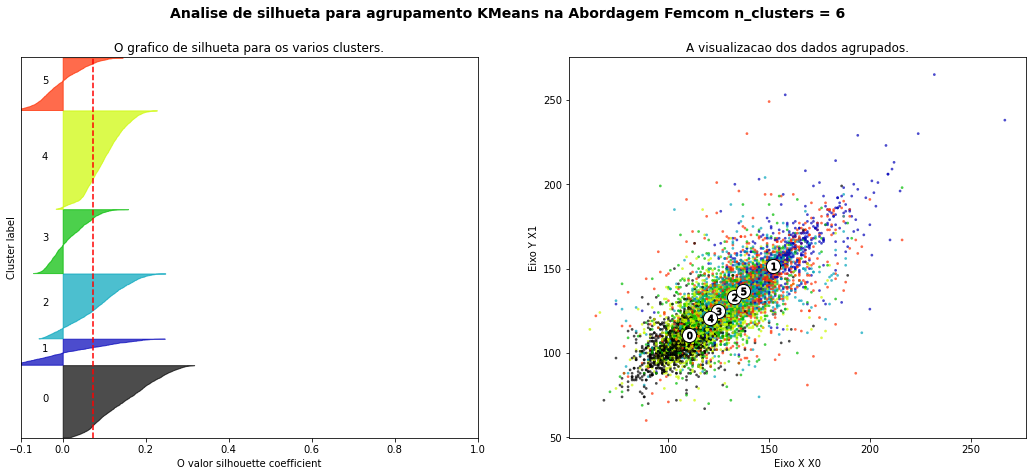

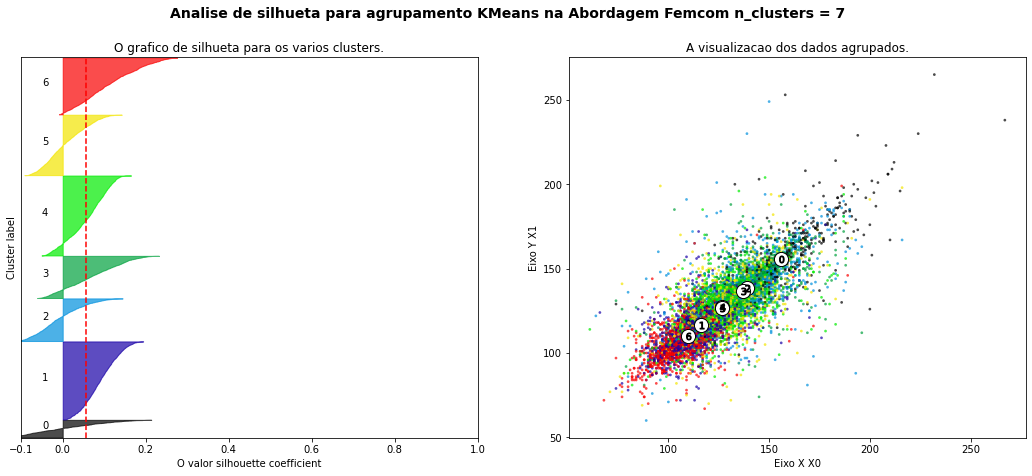

Tempo de execucao: 25.599 s




In [132]:
grupos = grupos_fem_funcao
abordagem = 'Fem'
aplica_silhouette(dados_fem_sem_id,grupos,abordagem)

### Abordagem 9: Random Forest

In [133]:
grupos = grupos_fem_funcao
abordagem = 'Fem'
importancia_fem = aplica_random_forest(dados_fem_sem_id,grupos,abordagem,classes_fem)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


     1     2    3    4     5     6    7
1  287     0    0    0     0     0    0
2    0  1312    0    0     0     0    0
3    0     0  722    0     0     0    0
4    0     0    0  653     0     0    0
5    0     0    0    0  1310     0    0
6    0     0    0    0     0  1043    0
7    0     0    0    0     0     0  940


=================Teste==============


Accuracy: 0.91 - Recall: 0.89 - F1 Score: 0.90


     1    2    3    4    5    6    7
1  162    0   18   21    0    0    0
2    0  787    0    0   29   19   12
3    2    0  395    4   32   25    0
4    2    0    7  455   50    0    0
5    0   24   10    8  854    6    0
6    0   28   11    0   12  567   11
7    0   37    0    0    0   14  577


=================Importancia==============


        features  importance
73     sist 6:45       0.020
71     sist 6:15       0.019
69     sist 5:30       0.012
92   diast 11:30       0.010
98   dia

In [134]:
dados_fem = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 0].copy().reset_index().drop('index',axis=1)
dados_completos_fem = pd.concat([dados_fem.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_fem_funcao}),
                                    dados_fem.loc[:,'sist 9:00':]],
                                   axis=1)
gera_arquivos_por_grupo(dados_completos_fem,'medidas_fem')

# Abordagem 10: Sistólicas separadas

In [135]:
dados_sist = dataset_medidas.loc[:,'sist 9:00':'sist 8:45']

## Abordagem 10: Número de Clusters gerado pelo k-Means

In [136]:
dados_sist_sem_id = dados_sist
grupos_sist_funcao = aplica_kmeans(dados_sist_sem_id, 'Sist')
print(grupos_sist_funcao)



Numero otimo de cluster - Abordagem Sist: 6


Tempo de execucao: 23.33 s


[4 6 1 ... 4 6 4]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


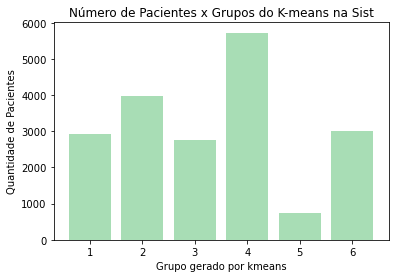

In [137]:
grupos = grupos_sist_funcao
abordagem = 'Sist'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_sist = grafico_barras_grupos(grupos,abordagem,caminho)

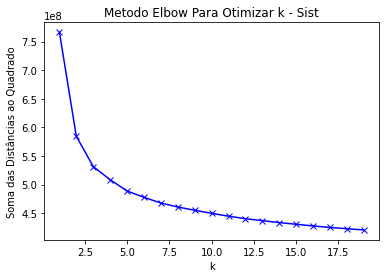

Tempo de execucao: 39.19 s




In [138]:
grupos = grupos_sist_funcao
abordagem = 'Sist'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_sist_sem_id,abordagem,caminho)

### Abordagem 10: Random Forest

Para n_clusters = 2 O score_silhouette medio e : 0.24422726446522333
Para n_clusters = 3 O score_silhouette medio e : 0.15373956949096523
Para n_clusters = 4 O score_silhouette medio e : 0.10506050781862958
Para n_clusters = 5 O score_silhouette medio e : 0.07749168357664177
Para n_clusters = 6 O score_silhouette medio e : 0.07530167946635802


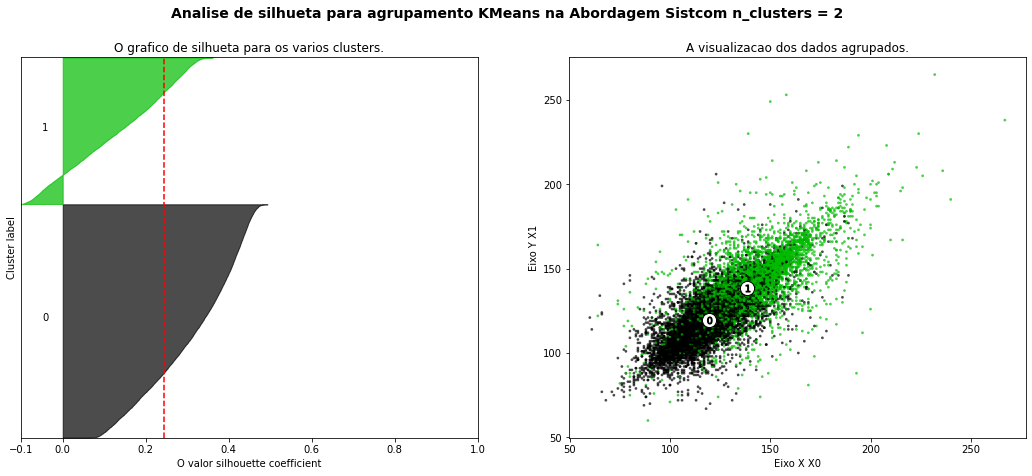

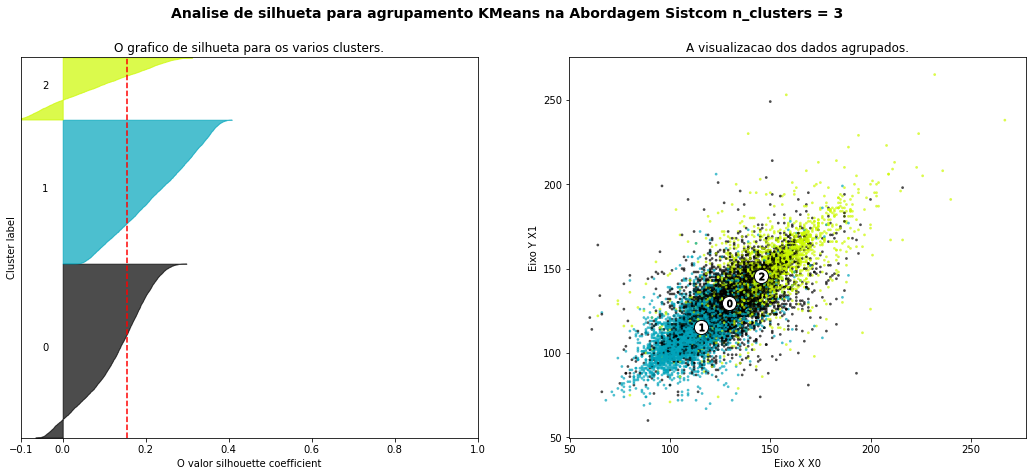

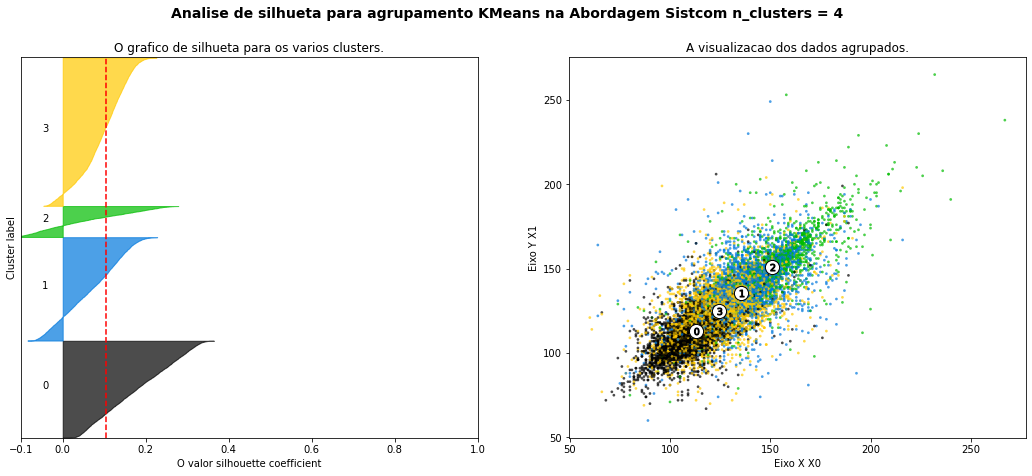

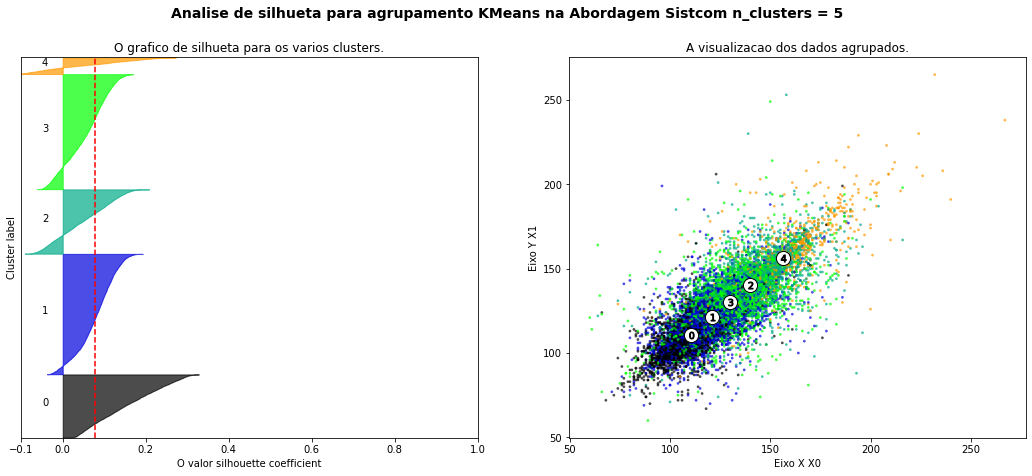

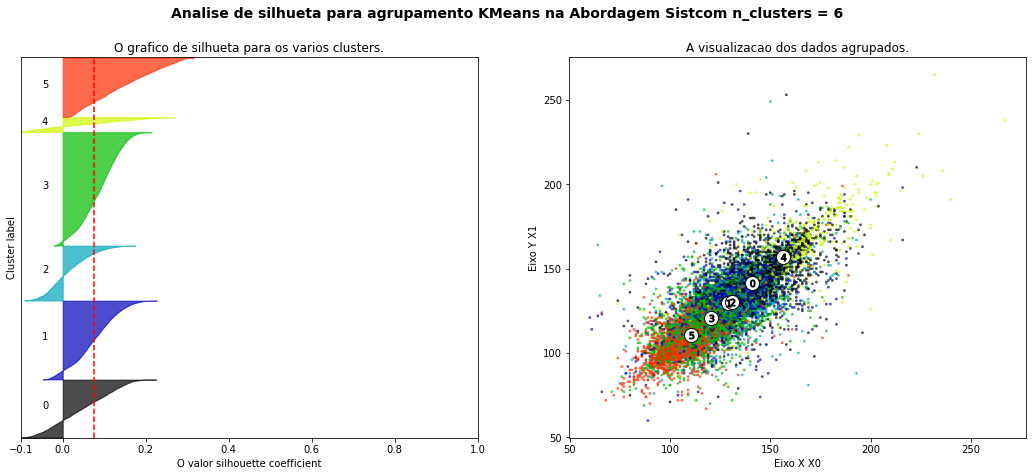

Tempo de execucao: 42.81 s




In [139]:
grupos = grupos_sist_funcao
abordagem = 'Sist'
aplica_silhouette(dados_sist_sem_id,grupos,abordagem)

In [140]:
grupos = grupos_sist_funcao
abordagem = 'Sist'
importancia_sist = aplica_random_forest(dados_sist_sem_id,grupos,abordagem,classes_sist)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3     4    5     6
1  1780     0     0     0    0     0
2     0  2389     0     0    0     0
3     0     0  1637     0    0     0
4     0     0     0  3454    0     0
5     0     0     0     0  446     0
6     0     0     0     0    0  1784


=================Teste==============


Accuracy: 0.92 - Recall: 0.90 - F1 Score: 0.92


      1     2    3     4    5     6
1  1078    48   24     0    0     0
2    30  1458   23    78    0     0
3    28    85  941    75    0     0
4     0    28   21  2211    0     9
5    45     0    0     0  255     0
6     0     0    1   113    0  1109


=================Importancia==============


      features  importance
71   sist 6:15       0.033
73   sist 6:45       0.029
44  sist 20:00       0.022
35  sist 17:45       0.022
22  sist 14:30       0.021
..         ...         ...
55  sist 22:45       0.009
56  sist 23:00       0.009
60   sist 1:00 

In [141]:
dados_completos_sist = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_sist_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_sist,'medidas_sistolica')

# Abordagem 11: Diastólicas 

In [142]:
dados_diast = dataset_medidas.loc[:,'diast 9:00':'diast 8:45']

## Abordagem 11: Número de Clusters gerado pelo k-Means

In [143]:
dados_diast_sem_id = dados_diast
grupos_diast_funcao = aplica_kmeans(dados_diast_sem_id, 'Sist')
print(grupos_diast_funcao)



Numero otimo de cluster - Abordagem Sist: 6


Tempo de execucao: 22.182 s


[6 6 3 ... 6 1 2]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


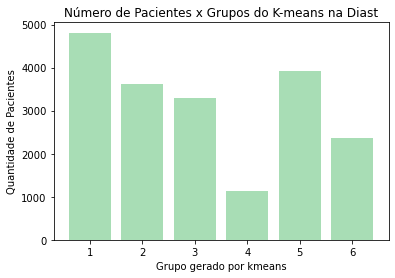

In [144]:
grupos = grupos_diast_funcao
abordagem = 'Diast'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_diast = grafico_barras_grupos(grupos,abordagem,caminho)

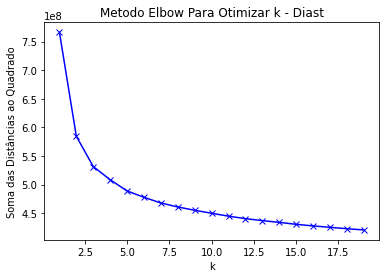

Tempo de execucao: 37.829 s




In [145]:
grupos = grupos_diast_funcao
abordagem = 'Diast'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_diast_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.23824977470546835
Para n_clusters = 3 O score_silhouette medio e : 0.1550791322933913
Para n_clusters = 4 O score_silhouette medio e : 0.11201777598431194
Para n_clusters = 5 O score_silhouette medio e : 0.08388821260484448
Para n_clusters = 6 O score_silhouette medio e : 0.0782999768217676


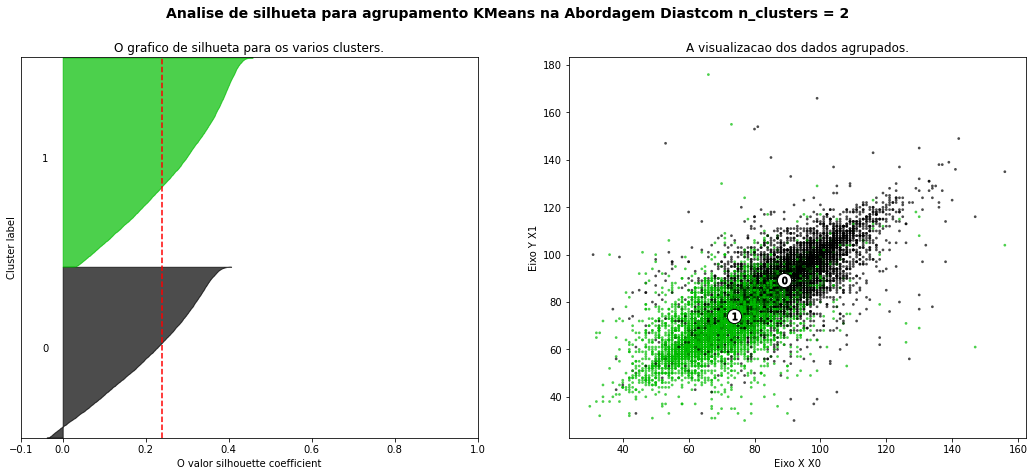

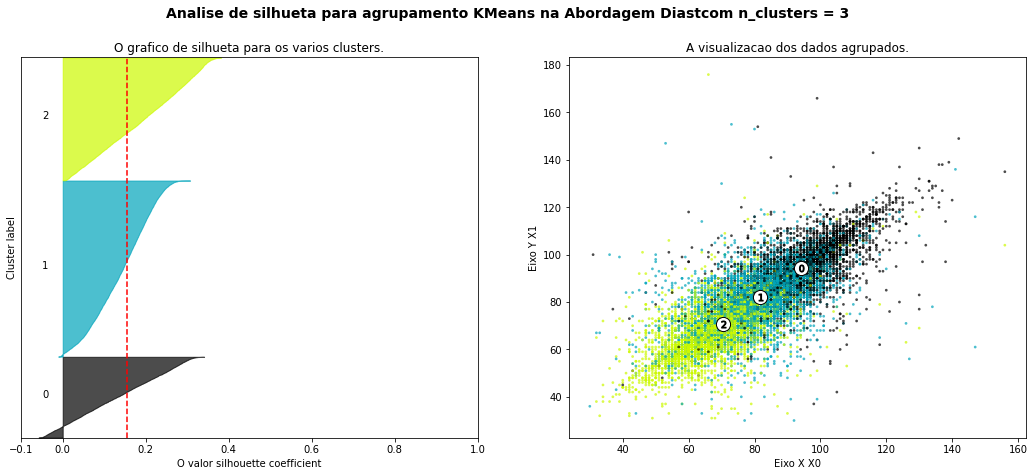

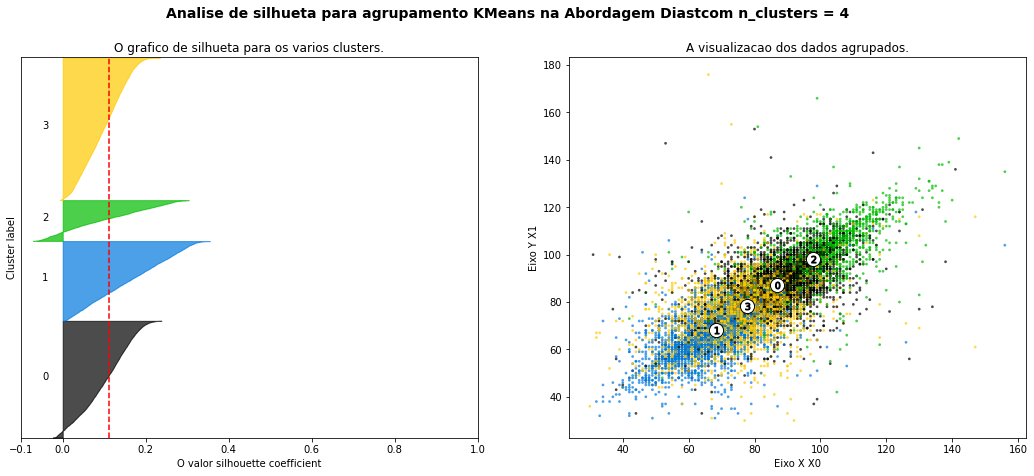

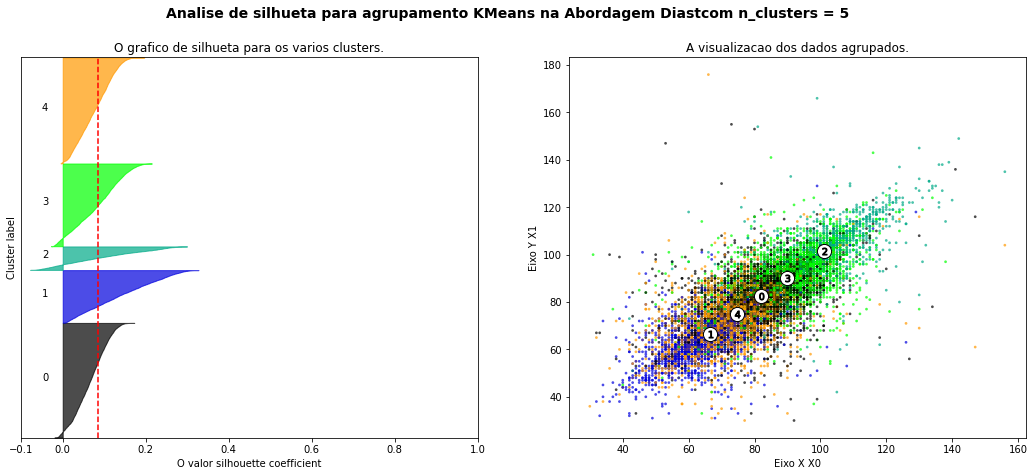

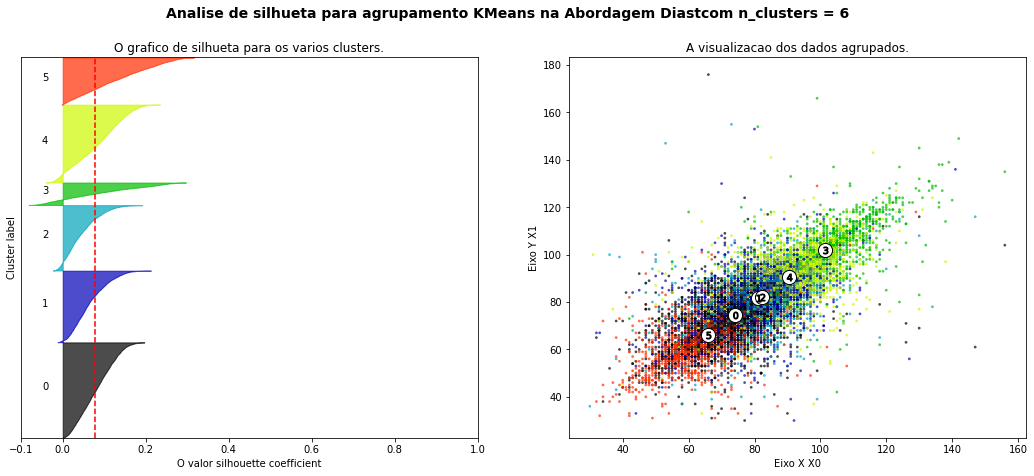

Tempo de execucao: 41.359 s




In [146]:
grupos = grupos_diast_funcao
abordagem = 'Diast'
aplica_silhouette(dados_diast_sem_id,grupos,abordagem)

### Abordagem 11: Random Forest

In [147]:
grupos = grupos_diast_funcao
abordagem = 'Diast'
importancia_diast = aplica_random_forest(dados_diast_sem_id,grupos,abordagem,classes_diast)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3    4     5     6
1  2873     0     0    0     0     0
2     0  2153     0    0     0     0
3     0     0  1960    0     0     0
4     0     0     0  714     0     0
5     0     0     0    0  2373     0
6     0     0     0    0     0  1417


=================Teste==============


Accuracy: 0.92 - Recall: 0.91 - F1 Score: 0.92


      1     2     3    4     5    6
1  1872    24    29    0     0   12
2    61  1292    46    0    60    0
3    82    59  1168    0    30    0
4     0     0     0  362    56    0
5     0    32    18    5  1497    0
6    87     0     0    0     0  868


=================Importancia==============


       features  importance
73   diast 6:45       0.031
71   diast 6:15       0.024
40  diast 19:00       0.022
37  diast 18:15       0.020
35  diast 17:45       0.018
..          ...         ...
57  diast 23:30       0.008
14  diast 12:30       0.008
59   d

In [148]:
dados_completos_diast = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_diast_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_diast,'medidas_diastolica')

# Abordagem 12 Medidas Mais Importantes

In [149]:
ls_importantes = importancia_medidas['features'].iloc[:7].values
ls_importantes

array(['sist 6:45', 'sist 6:15', 'diast 10:45', 'sist 20:15',
       'sist 20:00', 'diast 10:30', 'sist 7:00'], dtype=object)

In [150]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

sist 6:45  sist 6:15  diast 10:45  sist 20:15  sist 20:00  diast 10:30  \
0           94.0      104.0         50.0       119.0       109.0         50.0   
1          111.0      107.0         52.0       104.0       107.0         60.0   
2          136.0      122.0         57.0       144.0       122.0         56.0   
3          104.0      116.0         88.0       127.0       127.0         85.0   
4          116.0      102.0         81.0       124.0       130.0         80.0   
...          ...        ...          ...         ...         ...          ...   
19145      162.0      152.0        121.0       145.0       163.0        117.0   
19146      136.0      146.0         80.0       151.0       125.0         76.0   
19147       96.0       94.0         66.0       108.0       119.0         63.0   
19148      124.0      107.0         71.0       116.0       121.0         60.0   
19149      105.0      102.0         78.0       115.0       115.0         79.0   

       sist 7:00  
0           92.0  
1          113.0  
2          136.0  
3          111.0  
4          124.0  
...          ...  
19145      166.0  
19146      116.0  
19147       95.0  
19148      133.0  
19149      108.0  

[19150 rows x 7 columns]

In [151]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

Wall time: 7.99 s


7

In [152]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

## K-means Abordagem: Medidas Mais Importantes

In [153]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [154]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

Wall time: 374 ms


array([5, 4, 1, ..., 5, 4, 5])

In [155]:
#medidas_importantes.drop(['grupo'],axis=1,inplace=True)

In [156]:
medidas_importantes['grupo'] = grupos_medidas_importantes + 1
medidas_importantes

<ipython-input-156-c662c30a2a00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medidas_importantes['grupo'] = grupos_medidas_importantes + 1


sist 6:45  sist 6:15  diast 10:45  sist 20:15  sist 20:00  diast 10:30  \
0           94.0      104.0         50.0       119.0       109.0         50.0   
1          111.0      107.0         52.0       104.0       107.0         60.0   
2          136.0      122.0         57.0       144.0       122.0         56.0   
3          104.0      116.0         88.0       127.0       127.0         85.0   
4          116.0      102.0         81.0       124.0       130.0         80.0   
...          ...        ...          ...         ...         ...          ...   
19145      162.0      152.0        121.0       145.0       163.0        117.0   
19146      136.0      146.0         80.0       151.0       125.0         76.0   
19147       96.0       94.0         66.0       108.0       119.0         63.0   
19148      124.0      107.0         71.0       116.0       121.0         60.0   
19149      105.0      102.0         78.0       115.0       115.0         79.0   

       sist 7:00  grupo  
0           92.0      6  
1          113.0      5  
2          136.0      2  
3          111.0      1  
4          124.0      1  
...          ...    ...  
19145      166.0      4  
19146      116.0      2  
19147       95.0      6  
19148      133.0      5  
19149      108.0      6  

[19150 rows x 8 columns]

In [157]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes.loc[:,'grupo'],dataset_apos_tratamento.loc[:,'sist 9:00':]], axis=1)
df_medidas_importantes


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      6      105.0  ...   
1      29.4  2018-12-26 07:39:41      5      103.0  ...   
2      25.8  2018-12-26 08:06:19      2      147.0  ...   
3      24.2  2018-12-26 08:19:06      1      140.0  ...   
4      40.6  2018-12-26 08:26:59      1      113.0  ...   
...     ...                  ...    ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      4      163.0  ...   
19146  26.9  2020-09-10 16:21:02      2      114.0  ...   
19147  33.3  2020-09-10 16:44:53      6      107.0  ...   
19148  25.0  2020-09-10 17:25:50      5       94.0  ...   
19149  30.9  2020-09-10 17:42:01      6      111.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           61.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           80.0               10674.0                 6154.0   
3                           80.5               10679.5                 6420.5   
4                           77.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19145                      118.0               12224.5                 9265.0   
19146                       83.0               10970.0                 6819.0   
19147                       62.5                9245.0                 4935.5   
19148                       69.5                8989.5                 5660.0   
19149                       87.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.58   
1              2915.0             606.0                 7.38   
2              3721.0             751.5                12.48   
3              3642.0             602.5                16.14   
4              2405.0             566.0                11.88   
...               ...               ...                  ...   
19145          2439.0             474.5                17.26   
19146          3319.0             738.0                16.85   
19147          3556.0             713.5                13.56   
19148          2815.5             460.0                13.69   
19149          2400.5             612.0                13.38   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     10.99               15                39   
1                      6.89                9                23   
2                     13.02               19                20   
3                     10.58               23                11   
4                     12.65               14                15   
...                     ...              ...               ...   
19145                 13.89               64                75   
19146                 13.18               32                27   
19147                  8.00               15     

# Abordagem 13: redução das categorias das covariáveis Gênero, Idade e IMC

In [158]:
dados_simplificado = pd.DataFrame()
dados_simplificado['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dados_simplificado['genero'] = dataset_apos_tratamento['genero']
dados_simplificado['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe_13)
dados_simplificado['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe_13)
dados_simplificado = pd.concat([dados_simplificado, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dados_simplificado[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
#dados_simplificado

In [159]:
dados_simplificado_sem_id = dados_simplificado
grupos_simplificado_funcao = aplica_kmeans(dados_simplificado_sem_id, 'Simplificado')
print(grupos_simplificado_funcao)



Numero otimo de cluster - Abordagem Simplificado: 5


Tempo de execucao: 40.407 s


[3 3 3 ... 5 5 5]


C:\Users\marta\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


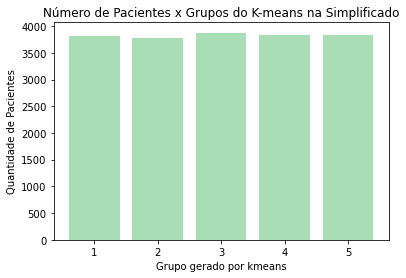

In [160]:
grupos = grupos_simplificado_funcao
abordagem = 'Simplificado'
caminho = DIR_KMEANS / 'graficos' / f'grafico_kmeans_grupo_pacientes_{abordagem.lower().replace(" ","_")}.svg'
classes_simplificado = grafico_barras_grupos(grupos,abordagem,caminho)

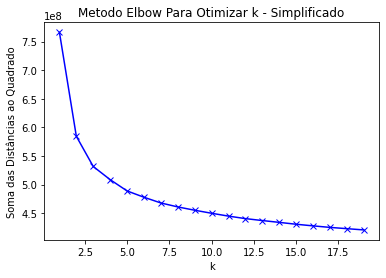

Tempo de execucao: 34.283 s




In [161]:
grupos = grupos_simplificado_funcao
abordagem = 'Simplificado'
caminho = DIR_KMEANS / 'graficos' / f'metodo_elbow_{abordagem.lower().replace(" ","_")}.svg'
aplica_elbow(dados_simplificado_sem_id,abordagem,caminho)

Para n_clusters = 2 O score_silhouette medio e : 0.6240256134673678
Para n_clusters = 3 O score_silhouette medio e : 0.5867265403501986
Para n_clusters = 4 O score_silhouette medio e : 0.564274833101281
Para n_clusters = 5 O score_silhouette medio e : 0.548162488692648


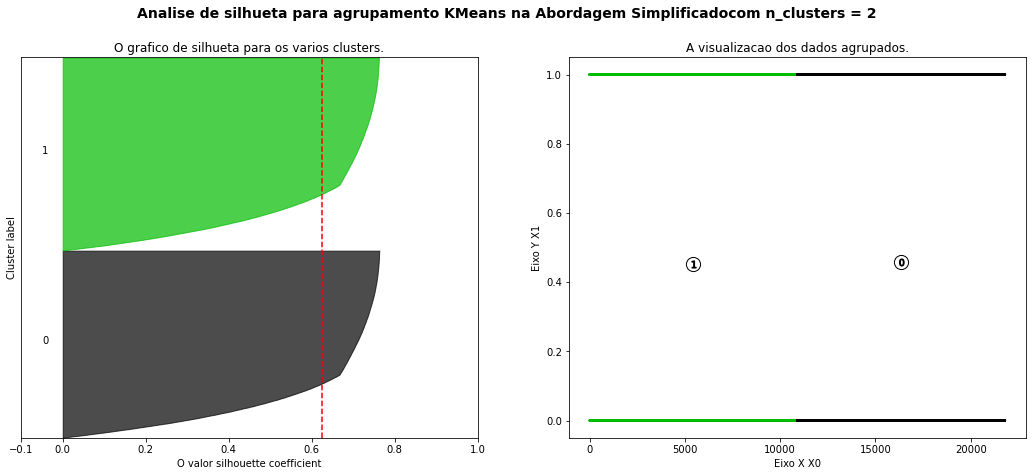

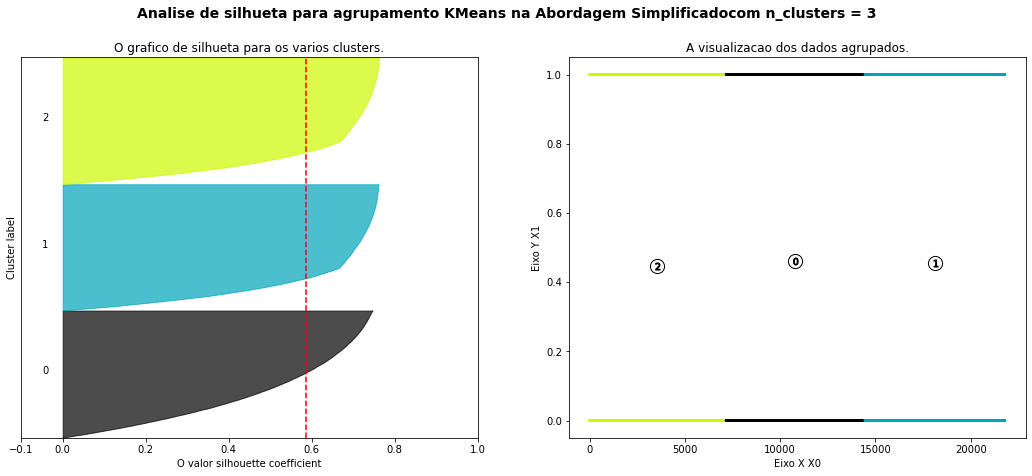

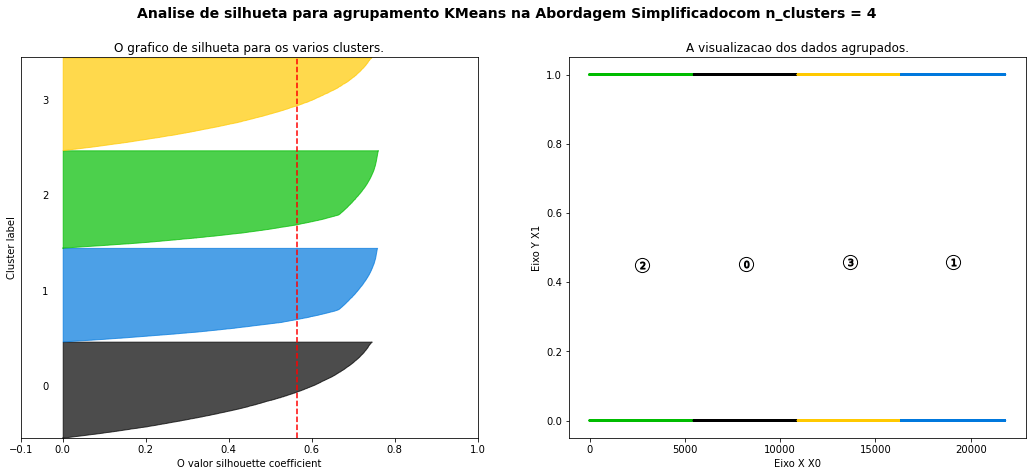

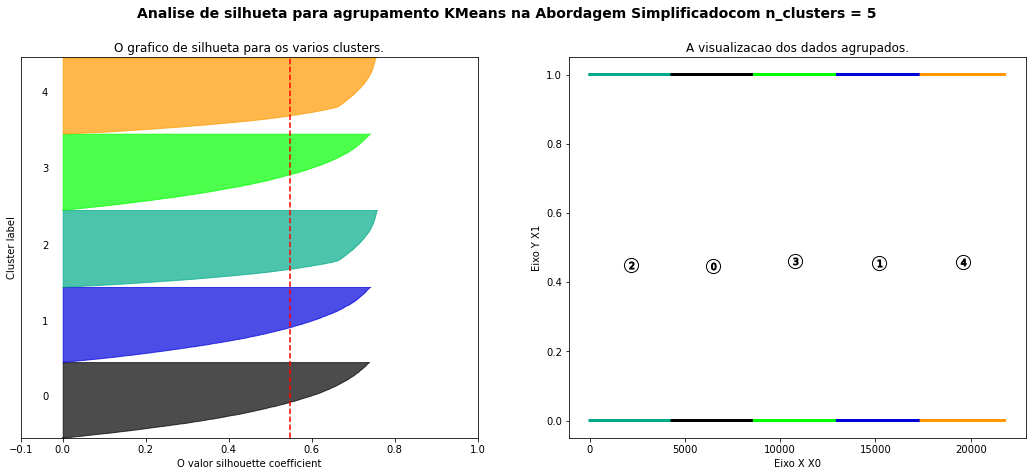

Tempo de execucao: 39.508 s




In [162]:
grupos = grupos_simplificado_funcao
abordagem = 'Simplificado'
aplica_silhouette(dados_simplificado_sem_id,grupos,abordagem)

In [163]:
grupos = grupos_simplificado_funcao
abordagem = 'Simplificado'
importancia_simplificado = aplica_random_forest(dados_simplificado_sem_id,grupos,abordagem,classes_simplificado)



=================Validação==============


Accuracy: 1.00 - Recall: 1.00 - F1 Score: 1.00


      1     2     3     4     5
1  2282     0     0     0     0
2     0  2229     0     0     0
3     0     0  2360     0     0
4     0     0     0  2306     0
5     0     0     0     0  2313


=================Teste==============


Accuracy: 0.96 - Recall: 0.96 - F1 Score: 0.96


      1     2     3     4     5
1  1493     5     7    26     0
2    10  1465     1    64    14
3     5     0  1510     1     0
4    59    62     1  1410     4
5     0    24     0     3  1496


=================Importancia==============


                 features  importance
0    numero_identificacao       0.329
82              sist 8:00       0.005
69              sist 3:30       0.005
158            diast 6:30       0.005
123           diast 18:15       0.004
..                    ...         ...
170    Diastolica Isolada       0.000
173       Extreme Dipping       0.000
174       Reverse Dipping       0.000
175  

In [164]:
dados_completos_simplificado = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    pd.DataFrame({'grupo':grupos_simplificado_funcao}),
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

gera_arquivos_por_grupo(dados_completos_simplificado,'simplificado')

In [165]:
#dados_completos_categorias_reduzido = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
#                                    pd.DataFrame({'grupo':grupos_categorias_reduzido_funcao}),
#                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
#                                   axis=1)
#
#gera_arquivos_por_grupo(dados_completos_categorias_reduzido,'categorias_reduzido')

In [166]:
##convertendo os dados para entrega ao Random - Classifcação
#
##ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)
#
##genero_M_F1 = {"genero": {"M":1, "F":0}}
##dataset_por_classes = dataset_por_classes.replace(genero_M_F1)
#
#ls_simples = list((dataset_simples.drop(list(dataset_simples.loc[:,'Hipotensao':].columns),axis=1)).drop('numero_identificacao',axis=1).columns)
#
#array_simples = np.array(dataset_simples[ls_simples])
#
#dataset_simples[ls_simples].head()

In [167]:
##calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)

#sum_of_squares = calculate_wcss(array_simples)
#n_simples = optimal_number_of_clusters(sum_of_squares)
#print (n_simples)


In [168]:
##   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)
#
#kmeans_simples = KMeans(n_clusters=n_simples, random_state=42).fit(array_simples)
#
#
##listar os grupos 
#
#grupos_simples = kmeans_simples.fit_predict(array_simples)
#
#
#grupos_simples
#

In [169]:
#  Inclui a coluna Grupo no dataset que será gravado no final
#dataset_simples['grupo'] = grupos_simples 
#dataset_simples['grupo'] = dataset_simples['grupo'] + 1

In [170]:
#from sklearn.ensemble import RandomForestClassifier
#
##parametro simples do modelo
#random_forest_classes = RandomForestClassifier(n_estimators=50)
#
##base para modelo
#classes = []
#qtds = []
#
#contagem = Counter(grupos_classes)
#
#for i in range(0,n_classes):
#    classes.append(i)
#    qtds.append(contagem[i])
#
#plt.bar(classes,qtds,color="#a8ddb5")
#plt.xticks(classes)
#plt.ylabel('Quantidade de Pacientes')
#plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
#plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
#fig = plt.gcf()
#fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
#plt.show()

In [171]:
#train_ratio = 0.75
#validation_ratio = 0.15
#test_ratio = 0.10
#
## Feature Selection
#x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)
#
## Feature Selection
#x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)
#
## Aplicação do modelo Random Forest no conjunto de dados de treino
#random_forest_classes.fit(x_train, y_train)

In [172]:
#### Abordagem 7: VALIDAÇÃO

#calcular acuracia, recall e f1
#y_prev_val = random_forest_classes.predict(x_val)
#
#accuracy = accuracy_score(y_val, y_prev_val)
#recall = recall_score(y_val, y_prev_val,average='macro')
#f1 = f1_score(y_val, y_prev_val,average='macro')
#
#print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))
#
##Matriz de Confusão
#mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

In [173]:
#### Abordagem 7: TESTE

#calcular acuracia, recall e f1
#y_prev_test = random_forest_classes.predict(x_test)
#
#accuracy = accuracy_score(y_test, y_prev_test)
#recall = recall_score(y_test, y_prev_test,average='macro')
#f1 = f1_score(y_test, y_prev_test,average='macro')
#
#print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))
#
##Matriz de Confusão
#mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

In [174]:
# Importância para Categorias

#importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})
#
#importancia = importancia.sort_values('importance',ascending=False)
#
#importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_categoria.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
#importancia

# Função para gravar os outputs

In [175]:
#def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
#                        sep=";", encoding="latin1", index=False)
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#    true_false_1_0 = {True:1, False:0}
#    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
#        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
#    
#    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_compara_todos_pacientes.csv", 
#                        sep=";", encoding="latin1", index=False)
#    if (abordagem == 'medidas'):
#        try:
#            df_grupo123 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 1) | (todos_dados_grupo['grupo'] == 2) | (todos_dados_grupo['grupo'] == 3)]
#            df_grupo123.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo123.csv", 
#                            sep=";", encoding="latin1", index=False)
#
#            df_grupo45 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 4) | (todos_dados_grupo['grupo'] == 5)]
#            df_grupo45.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo45.csv", 
#                            sep=";", encoding="latin1", index=False)
#
#            df_grupo67 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 6) | (todos_dados_grupo['grupo'] == 7)]
#            df_grupo67.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo67.csv", 
#                            sep=";", encoding="latin1", index=False)
#        except:
#            pass

In [176]:
#gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

##  Grava arquivo da abordagem 1 - Cadastro e Medidas

In [177]:
#'def gera_arquivos_por_grupo(todos_dados_grupo):
#'    grupos = list(set(todos_dados_grupo['grupo'].values))
#'    
#'    for grupo in grupos:
#'        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#'        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_cadastro_grupo_{grupo}.csv", 
#'                        sep=";", encoding="latin1", index=False)
#'
#'
#'#gera_arquivos_por_grupo(todos_dados_grupo)

In [178]:
#dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
#                                    dataset_padrao_doenca['grupo'],
#                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
#                                   axis=1)
#
#genero_M_F = {"genero": {1: "M", 0: "F"}}
#dados_completos_cadastro = dados_completos_cadastro.replace(genero_M_F)

In [179]:
#gera_arquivos_por_grupo(dados_completos_cadastro,'cadastro')

In [180]:
#dados_completos_cadastro[dados_completos_cadastro['grupo'] == 2]

In [181]:
#dados_completos_cadastro = dados_completos_generico
#dados_completos_cadastro['grupo'] = dataset_padrao_doenca['grupo']

In [182]:
#gera_arquivos_por_grupo(dados_completos_cadastro)

##  Grava arquivo da abordagem 2 - Medidas

In [183]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS /  f"KMEANS_approach_medidas_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [184]:
#dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
#                                    dados_medidas_sem_id['grupo'],
#                                    dataset_apos_tratamento.loc[:,'data_exame':]],
#                                   axis=1)
#
#genero_M_F = {"genero": {1: "M", 0: "F"}}
#dados_completos_medidas = dados_completos_medidas.replace(genero_M_F)

In [185]:
def identifica_cluster_binario(valor,cluster):
    if valor == cluster:
        return 1
    else:
        return 0
    
def dataFrameClasse(df):
    genero_1_0 = {"genero": {"M":1, "F":0}}
    df_classe = df.copy()
    df_classe = df_classe.replace(genero_1_0)
    df_classe.idade = df_classe.idade.apply(faixas_etarias_classe)
    df_classe.IMC = df_classe.IMC.apply(faixas_imc_classe)
    for grupo in set(dados_completos_medidas.grupo):
        df_classe[f'C{grupo}'] = df_classe.grupo.apply(identifica_cluster_binario,cluster=grupo)
    return df_classe

In [186]:
#df_teste = dataFrameClasse(dados_completos_medidas)
#df_teste.head()
#print (df_teste.shape)

In [187]:
#dados_completos_medidas

In [188]:
#len(dados_completos_medidas)

In [189]:
#gera_arquivos_por_grupo(dados_completos_medidas)

In [190]:
#gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

In [191]:
#dados_completos_medidas[dados_completos_medidas['grupo'] == 1].describe()

##  Grava arquivo da abordagem 3 - Estatísticas

In [192]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_estatistica_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [193]:
#dados_completos_estatistica = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
#                                    dados_estatistica_sem_nan['grupo'],
#                                    dataset_apos_tratamento.loc[:,'data_exame':]],
#                                   axis=1)
#
#genero_M_F = {"genero": {1: "M", 0: "F"}}
#dados_completos_estatistica = dados_completos_estatistica.replace(genero_M_F)

In [194]:
#gera_arquivos_por_grupo(dados_completos_estatistica)

In [195]:
#gera_arquivos_por_grupo(dados_completos_estatistica,'estatistica')

##   Grava arquivo da abordagem 4 - DOENÇAS

In [196]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        print(df_grupo)
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_doenca_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [197]:
#dados_completos_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
#                                    dataset_padrao_doenca['grupo'],
#                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
#                                   axis=1)
#
#genero_M_F = {"genero": {1: "M", 0: "F"}}
#dados_completos_doenca = dados_completos_doenca.replace(genero_M_F)
#
#
#gera_arquivos_por_grupo(dados_completos_doenca,'doenca')

In [198]:
#gera_arquivos_por_grupo(dados_completos_doenca)

In [199]:
#gera_arquivos_por_grupo(dados_completos_doenca,'doenca')

In [200]:
#dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')

In [201]:
#arquivo_whitecoat = pd.concat([dataset[dataset['Whitecoat'] == True].loc[:,'numero_identificacao'],
#                               dataset[dataset['Whitecoat'] == True].loc[:,'Whitecoat']],axis=1)
#
#arquivo_whitecoat.to_csv(DIR_KMEANS / "KMEANS_validando_whitecoat.csv", 
#                        sep=";", encoding="latin1", index=False)

## Grava arquivo da abordagem A5: Doenças sem Hipertensão e Normotenso

In [202]:
#gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

In [203]:
#dados_completos_escolho_doenca

##   Grava arquivo da abordagem 7: CATEGORIAS

In [204]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_classes_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [205]:
#dados_completos_classes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
#                                    dataset_por_classes['grupo'],
#                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
#                                   axis=1)
#
#genero_M_F = {"genero": {1: "M", 0: "F"}}
#dados_completos_classes = dados_completos_classes.replace(genero_M_F)

In [206]:
#gera_arquivos_por_grupo(dados_completos_classes)

In [207]:
#gera_arquivos_por_grupo(dados_completos_classes,'classes')

In [208]:
#gera_arquivos_por_grupo(df_medidas_importantes,'medidas_importantes')

##   Grava arquivo da abordagem 8 e 9: Sexo

In [209]:
#gera_arquivos_por_grupo(dataset_masc_apos_kmeans,'medidas_masc')

In [210]:
#gera_arquivos_por_grupo(dataset_fem_apos_kmeans,'medidas_fem')

In [211]:
#dataset_masc_apos_kmeans[dataset_masc_apos_kmeans['grupo'] == 1]

In [212]:
#dataset_fem_apos_kmeans[dataset_fem_apos_kmeans['grupo'] == 1]

##   Grava arquivo da abordagem 10 e 11

In [213]:
#gera_arquivos_por_grupo(dataset_sistolica_apos_kmeans,'medidas_sistolica')

In [214]:
#gera_arquivos_por_grupo(dataset_diastolica_apos_kmeans,'medidas_diastolica')

### Grava arquivo da abordagem 13

In [215]:
#dados_completos_simples = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
#                                    dataset_simples['grupo'],
#                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
#                                   axis=1)
#
#genero_M_F = {"genero": {1: "M", 0: "F"}}
#dados_completos_simples = dados_completos_simples.replace(genero_M_F)
#dados_completos_simples

In [216]:
#gera_arquivos_por_grupo(dados_completos_simples,'simplificado')

# Identificação do Centróide nas diversas abordagens

In [217]:
l = ['a','b','c']

In [218]:
for a,b in enumerate(l):
    print(a,b)

0 a
1 b
2 c
